# CMIP6 Visualizations

Heavily modified from Molly's code; made more efficient with ChatGPT

## Prepare data

After this code is ran, all 4 sections below can be ran independent of one another

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import os

In [2]:
# Function to load the dataset
def open_series(fpath_stem, which_date, which_gcm, which_ssp):
    this_fpath = os.path.expanduser(fpath_stem + '{}-gcm_data_{}_{}_compiled_output.nc'.format(which_date, which_gcm, which_ssp))
    return xr.open_dataset(this_fpath)

In [3]:
# # How to load the dataset:
# dataset = open_series(base, date, gcm, ssp)

# # Print the dataset overview
# print(dataset)

# # Print the keys to see all variable names
# print(dataset.keys())

In [4]:
# 'gfdl-esm4_r1i1p1f1' is the problem GCM...
# Define variables
base = '/Users/ziggygoddard/Documents/summer24/'
gcm_list = ['mpi-esm1-2-hr_r1i1p1f1', 'mri-esm2-0_r1i1p1f1', 'ipsl-cm6a-lr_r1i1p1f1',
            'ukesm1-0-ll_r1i1p1f2', 'gfdl-esm4_r1i1p1f1']
date_list = ['2024-06-19', '2024-06-20'] # both dates are essential in this case, not sure why
ssp_list = ['ssp126', 'ssp370', 'ssp585']
n_roll = 3

# 1. Seasonal runoff

## Functions

In [5]:
# Calculate seasonal runoff
def calc_seasonal(this_ds):
    melt1 = this_ds.melt_on_glacier_monthly
    melt2 = this_ds.melt_off_glacier_monthly
    melt3 = this_ds.liq_prcp_off_glacier_monthly
    melt4 = this_ds.liq_prcp_on_glacier_monthly

    # Calculate total liquid precipitation
    total_liq_prcp_m = melt3.sum(dim='rgi_id').dropna(dim='time') + melt4.sum(dim='rgi_id').dropna(dim='time')

    # Calculate total runoff
    this_sum = melt1.sum(dim='rgi_id').dropna(dim='time') + melt2.sum(dim='rgi_id').dropna(dim='time') + total_liq_prcp_m
    nonzero_sum = this_sum.where(this_sum != 0, drop=True)
    nonzero_sum *= 1e-9

    return nonzero_sum

In [6]:
# Select a year and take the mean runoff of all GCMs for this year
def season_sliced(keys, dictionary, time):
    new_df = pd.DataFrame()
    for k in keys:
        new = dictionary[k]
        new = new.isel(time=time)
        new = pd.DataFrame(new)
        new_df[k] = new
    new_df['mean'] = new_df.transpose().mean()
    return new_df

In [7]:
# Calculate monthly runoff for a given runoff value
def rtype_calc_monthly(keys, dictionary, runoff):
    dataframe = pd.DataFrame()
    for k in keys:
        rtype_gcm = dictionary[k]
        if runoff == 'total_liq_prcp_m':
            rtype = rtype_gcm['liq_prcp_off_glacier_m'] + rtype_gcm['liq_prcp_on_glacier_m']
        else:
            if runoff.endswith('_m'):
                rtype = rtype_gcm[runoff]
            else:
                rtype = rtype_gcm[runoff + '_monthly']  # Assuming your data keys end with '_monthly'
        rtype = pd.DataFrame(rtype)
        dataframe[k] = rtype
    dataframe['mean'] = dataframe.transpose().mean()
    return dataframe

In [8]:
# # For whatever reason, this code does not load the datasets right
# # Load datasets and calculate seasonal values
# all_monthly_dict = {}
# season_unroll = {}
# for gcm in gcm_list:
#     for date in date_list:
#         for ssp in ssp_list:
#             filepath = base + '{}-gcm_data_{}_{}_compiled_output.nc'.format(date, gcm, ssp)
#             if os.path.exists(filepath):
#                 ssp_value = open_series(fpath_stem=base, which_date=date, which_gcm=gcm, which_ssp=ssp)
#                 k = '{}-{}'.format(gcm, ssp)
#                 all_monthly_dict[k] = ssp_value
#                 season_unroll[k] = calc_seasonal(ssp_value)

In [9]:
# Load datasets and calculate seasonal values
all_monthly_dict = {}
season_unroll = {}

for date in date_list:
    for gcm in gcm_list:
        for ssp in ssp_list:
            filepath = f"{base}{date}-gcm_data_{gcm}_{ssp}_compiled_output.nc"
            if os.path.exists(filepath):
                try:
                    ssp_value = xr.open_dataset(filepath)
                    k = f"{gcm}-{ssp}"
                    all_monthly_dict[k] = ssp_value
                    season_unroll[k] = calc_seasonal(ssp_value)
                    print(f"Loaded and processed: {filepath}")
                except Exception as e:
                    print(f"Failed to process {filepath}: {e}")
                    #pass # un-comment this out if print statements not wanted
            else:
                print(f"File missing: {filepath}")
                #pass

# Check the contents of all_monthly_dict
print(f"Loaded datasets: {list(all_monthly_dict.keys())}")

Loaded and processed: /Users/ziggygoddard/Documents/summer24/2024-06-19-gcm_data_mpi-esm1-2-hr_r1i1p1f1_ssp126_compiled_output.nc
Loaded and processed: /Users/ziggygoddard/Documents/summer24/2024-06-19-gcm_data_mpi-esm1-2-hr_r1i1p1f1_ssp370_compiled_output.nc
Loaded and processed: /Users/ziggygoddard/Documents/summer24/2024-06-19-gcm_data_mpi-esm1-2-hr_r1i1p1f1_ssp585_compiled_output.nc
Loaded and processed: /Users/ziggygoddard/Documents/summer24/2024-06-19-gcm_data_mri-esm2-0_r1i1p1f1_ssp126_compiled_output.nc
Loaded and processed: /Users/ziggygoddard/Documents/summer24/2024-06-19-gcm_data_mri-esm2-0_r1i1p1f1_ssp370_compiled_output.nc
Loaded and processed: /Users/ziggygoddard/Documents/summer24/2024-06-19-gcm_data_mri-esm2-0_r1i1p1f1_ssp585_compiled_output.nc
Loaded and processed: /Users/ziggygoddard/Documents/summer24/2024-06-19-gcm_data_ipsl-cm6a-lr_r1i1p1f1_ssp126_compiled_output.nc
Loaded and processed: /Users/ziggygoddard/Documents/summer24/2024-06-19-gcm_data_ipsl-cm6a-lr_r1i1p1

In [10]:
# Rolling and summing values
dict_roll = {}
rtype_roll = {}
rtype_calc_s = {}
rtype_calc_e = {}

In [11]:
for k in season_unroll.keys():
    season_roll = season_unroll[k].roll(month_2d=n_roll, roll_coords=False)
    dict_roll[k] = season_roll
    rtype_season = all_monthly_dict[k].roll(month_2d=n_roll, roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_roll[k] = rtype_sum

    df_key = rtype_roll[k]
    df_m_s = df_key.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
    df_m_s.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
    df_m_s = df_m_s.clip(0)
    rtype_calc_s[k] = df_m_s

    df_m_e = df_key.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
    df_m_e.columns = [c.replace('_monthly', '_m') for c in df_m_e.columns]
    df_m_e = df_m_e.clip(0)
    rtype_calc_e[k] = df_m_e

## Plot runoff

### Plot runoff components

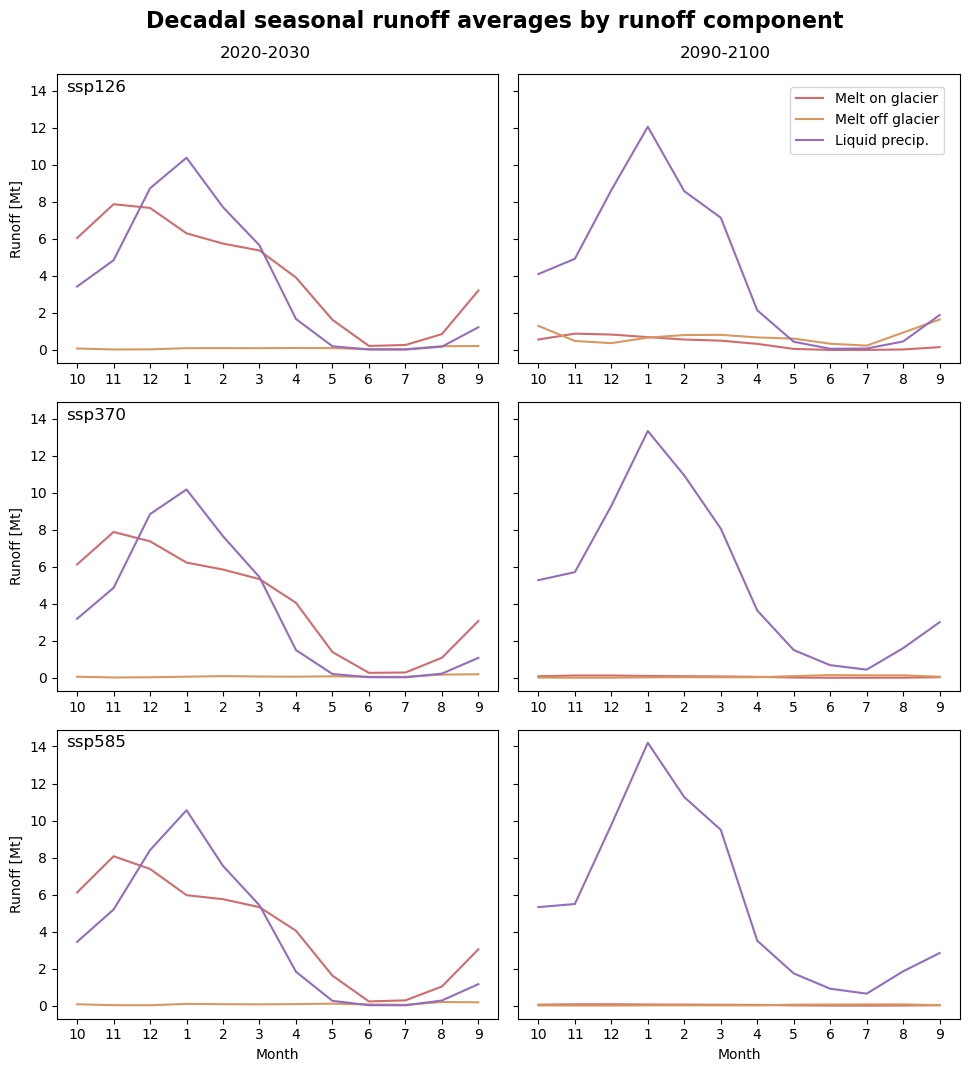

In [12]:
# Function to calculate and visualize runoff
def plot_runoff(axes, rtype_calc_s, rtype_calc_e, index2, season_roll, season_roll2, ssp, row):
    runoff_variables = ['melt_on_glacier_m', 'melt_off_glacier_m', 'total_liq_prcp_m']
    colors = ['#d16b6c', '#d9985f', '#946cbd']
    labels = ['Melt on glacier', 'Melt off glacier', 'Liquid precip.']
    s_keys = rtype_calc_s.keys()

    # Store lines for the legend
    lines = []

    for i, r in enumerate(runoff_variables):
        if r == 'total_liq_prcp_m':
            runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s, 'total_liq_prcp_m')
            runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e, 'total_liq_prcp_m')
        else:
            runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s, r)
            runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e, r)
        
        line1, = axes[row, 0].plot(index2, runoff_s['mean'], label=labels[i], color=colors[i])
        line2, = axes[row, 1].plot(index2, runoff_e['mean'], label=labels[i], color=colors[i])
        
        if row == 0:
            lines.append(line1)

    for col in range(2):
        ax = axes[row, col]
        ax.set(xticks=season_roll['month_2d'].values,
                xticklabels=season_roll2['month_2d'].values)

    # Set x-axis labels only for the bottom row
    for ax in axes[-1, :]:
        ax.set_xlabel('Month')

    axes[row, 0].set(ylabel=f'Runoff [Mt]')

    return lines, labels

# Create a 3x2 grid of subplots
f, axes = plt.subplots(3, 2, figsize=(10, 11), sharey=True)

# Plotting for each SSP
all_lines = []
all_labels = []
for row, ssp in enumerate(ssp_list):
    ssp_keys = [key for key in season_unroll.keys() if ssp in key]
    season_roll2 = season_unroll[ssp_keys[0]].roll(month_2d=n_roll, roll_coords=True)
    index1 = season_unroll[ssp_keys[0]]
    index2 = index1['month_2d']
    
    lines, labels = plot_runoff(axes, 
                                {k: v for k, v in rtype_calc_s.items() if ssp in k}, 
                                {k: v for k, v in rtype_calc_e.items() if ssp in k}, 
                                index2, season_roll, season_roll2, ssp, row)

    # Add SSP label in the upper left corner of each plot on the left
    if row < 3:
        axes[row, 0].text(0.02, 0.98, ssp, transform=axes[row, 0].transAxes,
                          verticalalignment='top', horizontalalignment='left',
                          fontsize=12)
    
    if row == 0:
        all_lines.extend(lines)
        all_labels.extend(labels)

# Add a single overarching title
plt.suptitle('Decadal seasonal runoff averages by runoff component', y=0.97, fontsize=16, fontweight='bold')

# Add titles above each column of plots
f.text(0.27, 0.93, '2020-2030', ha='center', va='center', fontsize=12)
f.text(0.73, 0.93, '2090-2100', ha='center', va='center', fontsize=12)

# Add a single legend
# f.legend(all_lines, all_labels, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=len(all_labels), frameon=False)
axes[0, 1].legend(all_lines, all_labels, loc='upper left', bbox_to_anchor=(0.6, 0.98))

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title and legend
plt.show()


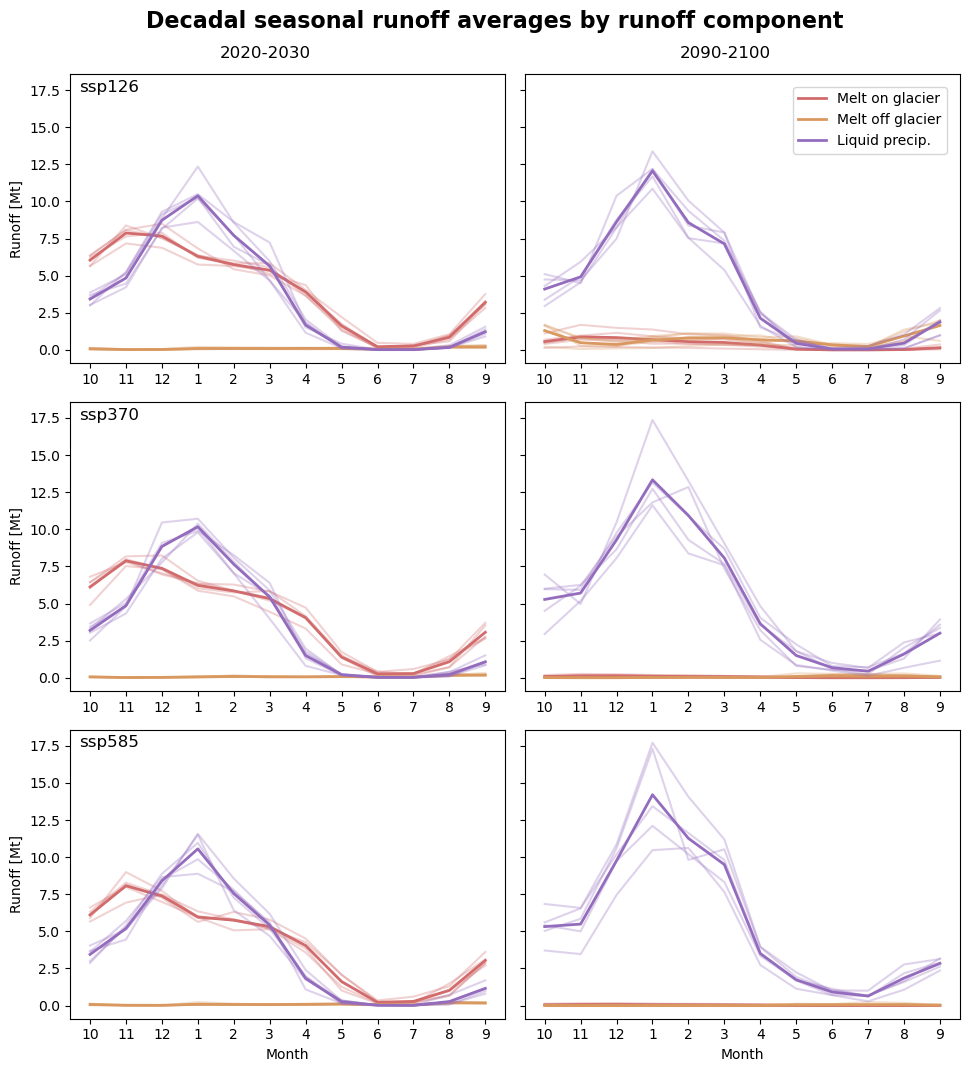

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate and visualize runoff
def plot_runoff(axes, rtype_calc_s, rtype_calc_e, index2, season_roll, season_roll2, ssp, row):
    runoff_variables = ['melt_on_glacier_m', 'melt_off_glacier_m', 'total_liq_prcp_m']
    colors = ['#d16b6c', '#d9985f', '#946cbd']
    labels = ['Melt on glacier', 'Melt off glacier', 'Liquid precip.']
    s_keys = list(rtype_calc_s.keys())

    # Store lines for the legend
    lines = []

    for i, r in enumerate(runoff_variables):
        # Plot individual GCMs
        for gcm in s_keys:
            if r == 'total_liq_prcp_m':
                if 'liq_prcp_off_glacier_m' in rtype_calc_s[gcm].columns and 'liq_prcp_on_glacier_m' in rtype_calc_s[gcm].columns:
                    liq_prcp_total_s = rtype_calc_s[gcm]['liq_prcp_off_glacier_m'] + rtype_calc_s[gcm]['liq_prcp_on_glacier_m']
                    liq_prcp_total_e = rtype_calc_e[gcm]['liq_prcp_off_glacier_m'] + rtype_calc_e[gcm]['liq_prcp_on_glacier_m']
                    axes[row, 0].plot(index2, liq_prcp_total_s, color=colors[i], alpha=0.3)
                    axes[row, 1].plot(index2, liq_prcp_total_e, color=colors[i], alpha=0.3)
            else:
                if r in rtype_calc_s[gcm].columns and r in rtype_calc_e[gcm].columns:
                    axes[row, 0].plot(index2, rtype_calc_s[gcm][r], color=colors[i], alpha=0.3)
                    axes[row, 1].plot(index2, rtype_calc_e[gcm][r], color=colors[i], alpha=0.3)
        
        # Calculate and plot the mean
        if r == 'total_liq_prcp_m':
            runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s, 'total_liq_prcp_m')
            runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e, 'total_liq_prcp_m')
        else:
            runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s, r)
            runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e, r)

        line1, = axes[row, 0].plot(index2, runoff_s['mean'], label=labels[i], color=colors[i], linewidth=2)
        line2, = axes[row, 1].plot(index2, runoff_e['mean'], label=labels[i], color=colors[i], linewidth=2)
        
        if row == 0:
            lines.append(line1)

    for col in range(2):
        ax = axes[row, col]
        ax.set(xticks=season_roll['month_2d'].values,
                xticklabels=season_roll2['month_2d'].values)

    # Set x-axis labels only for the bottom row
    for ax in axes[-1, :]:
        ax.set_xlabel('Month')

    axes[row, 0].set(ylabel=f'Runoff [Mt]')

    return lines, labels

# Create a 3x2 grid of subplots
f, axes = plt.subplots(3, 2, figsize=(10, 11), sharey=True)

# Plotting for each SSP
all_lines = []
all_labels = []
for row, ssp in enumerate(ssp_list):
    ssp_keys = [key for key in season_unroll.keys() if ssp in key]
    season_roll2 = season_unroll[ssp_keys[0]].roll(month_2d=n_roll, roll_coords=True)
    index1 = season_unroll[ssp_keys[0]]
    index2 = index1['month_2d']
    
    lines, labels = plot_runoff(axes, 
                                {k: v for k, v in rtype_calc_s.items() if ssp in k}, 
                                {k: v for k, v in rtype_calc_e.items() if ssp in k}, 
                                index2, season_roll, season_roll2, ssp, row)

    # Add SSP label in the upper left corner of each plot on the left
    if row < 3:
        axes[row, 0].text(0.02, 0.98, ssp, transform=axes[row, 0].transAxes,
                          verticalalignment='top', horizontalalignment='left',
                          fontsize=12)
    
    if row == 0:
        all_lines.extend(lines)
        all_labels.extend(labels)

# Add a single overarching title
plt.suptitle('Decadal seasonal runoff averages by runoff component', y=0.97, fontsize=16, fontweight='bold')

# Add titles above each column of plots
f.text(0.27, 0.93, '2020-2030', ha='center', va='center', fontsize=12)
f.text(0.73, 0.93, '2090-2100', ha='center', va='center', fontsize=12)

# Add a single legend
axes[0, 1].legend(all_lines, all_labels, loc='upper left', bbox_to_anchor=(0.6, 0.98))

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title and legend
plt.show()


/var/folders/q4/r3b9pkcx6bn5djf1vxnj5xkr0000gn/T/ipykernel_41088/2520762995.py:67: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to make space for the super title and legend


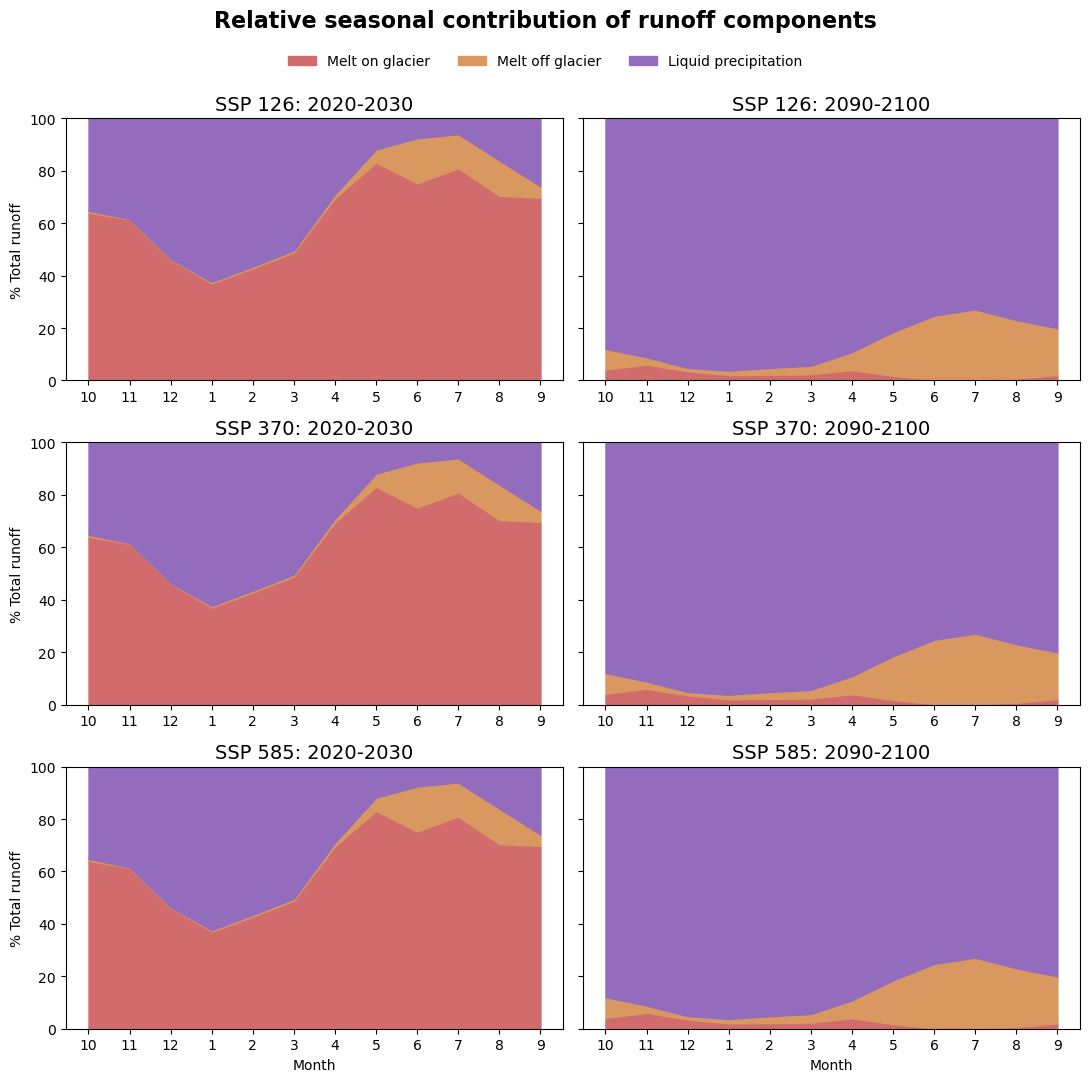

In [14]:
def plot_relative_contribution_filled_monthly(rtype_calc_s, rtype_calc_e, index2, ssp_list, season_roll, season_roll2, y_max=300, legend_loc='upper center'):
    # Define the runoff variables of interest
    runoff_variables = ['melt_on_glacier_m', 'melt_off_glacier_m', 'total_liq_prcp_m']

    f, axes = plt.subplots(3, 2, figsize=(11, 11), sharey=True, constrained_layout=True)

    colors = ['#d16b6c', '#d9985f', '#946cbd']
    labels = ['Melt on glacier', 'Melt off glacier', 'Liquid precipitation']

    for row, ssp in enumerate(ssp_list):
        lower_bounds_s = lower_bounds_e = None  # Initialize lower bounds within the loop for each SSP
        for r, color, label in zip(runoff_variables, colors, labels):
            # Calculate mean monthly runoff for the specified variable
            runoff_s = rtype_calc_monthly(rtype_calc_s.keys(), rtype_calc_s, r)
            runoff_e = rtype_calc_monthly(rtype_calc_e.keys(), rtype_calc_e, r)

            # Calculate total monthly runoff
            total_s = sum(rtype_calc_monthly(rtype_calc_s.keys(), rtype_calc_s, rv)['mean'] for rv in runoff_variables)
            total_e = sum(rtype_calc_monthly(rtype_calc_e.keys(), rtype_calc_e, rv)['mean'] for rv in runoff_variables)

            # Calculate relative contribution as a percentage
            relative_contrib_s = (runoff_s['mean'] / total_s) * 100
            relative_contrib_e = (runoff_e['mean'] / total_e) * 100

            # Initialize arrays to store lower bounds of filled areas
            if lower_bounds_s is None:
                lower_bounds_s = np.zeros_like(relative_contrib_s)
                lower_bounds_e = np.zeros_like(relative_contrib_e)

            # Plot filled area with stacked contributions
            axes[row, 0].fill_between(index2, lower_bounds_s, lower_bounds_s + relative_contrib_s, label=label, color=color, alpha=1)
            axes[row, 1].fill_between(index2, lower_bounds_e, lower_bounds_e + relative_contrib_e, label=label, color=color, alpha=1)

            # Update lower bounds for next component
            lower_bounds_s += relative_contrib_s
            lower_bounds_e += relative_contrib_e

        axes[row, 0].set_ylabel(f'% Total runoff')

        for ax in axes[row, :]:
            ax.legend().set_visible(False)
            ax.set_ylim(0, y_max)

            # Set xticks and xticklabels for all axes
            ax.set(xticks=season_roll['month_2d'].values,
                   xticklabels=season_roll2['month_2d'].values)

    # Set x-axis labels only for the bottom row
    for ax in axes[-1, :]:
        ax.set_xlabel('Month')

    # Set titles for the columns (this could be done more efficiently but it works
    axes[0, 0].set_title('SSP 126: 2020-2030', fontsize=14)
    axes[1, 0].set_title('SSP 370: 2020-2030', fontsize=14)
    axes[2, 0].set_title('SSP 585: 2020-2030', fontsize=14)
    axes[0, 1].set_title('SSP 126: 2090-2100', fontsize=14)
    axes[1, 1].set_title('SSP 370: 2090-2100', fontsize=14)
    axes[2, 1].set_title('SSP 585: 2090-2100', fontsize=14)

    # Create a single legend at the specified location
    handles, labels = axes[0, 0].get_legend_handles_labels()
    f.legend(handles, labels, loc=legend_loc, bbox_to_anchor=(0.5, 0.95), ncol=len(runoff_variables), frameon=False)

    # Set single title at the top of the figure
    f.suptitle('Relative seasonal contribution of runoff components', fontsize=16, fontweight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to make space for the super title and legend
    plt.show()

# Example usage for all SSPs
plot_relative_contribution_filled_monthly(
    {k: v for k, v in rtype_calc_s.items() if any(ssp in k for ssp in ssp_list)}, 
    {k: v for k, v in rtype_calc_e.items() if any(ssp in k for ssp in ssp_list)}, 
    index2, ssp_list, season_roll, season_roll2,
    y_max=100,  # Set the y-axis maximum value
    legend_loc='upper center'  # Control the legend placement
)

### Plot total runoff (decadal)

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Define keys for each SSP
key_dict = {
    'ssp126': [key for key in season_unroll.keys() if 'ssp126' in key],
    'ssp370': [key for key in season_unroll.keys() if 'ssp370' in key],
    'ssp585': [key for key in season_unroll.keys() if 'ssp585' in key]
}

# Function to calculate decadal mean
def calculate_decadal_mean(keys, dictionary, start_year, end_year):
    new_df = pd.DataFrame()
    for k in keys:
        new = dictionary[k].sel(time=slice(start_year, end_year))
        new_mean = new.mean(dim='time')
        new_df[k] = new_mean
    new_df['mean'] = new_df.mean(axis=1)
    return new_df

# Define decades
decades = [(2020, 2030), (2090, 2100)]
decade_labels = ['2020-2030', '2090-2100']

fig, axs = plt.subplots(len(ssps), len(decades), figsize=(12, 9), sharey=True, constrained_layout=True)

for i, ssp in enumerate(ssps):
    for j, (start_year, end_year) in enumerate(decades):
        ssp_keys = key_dict[ssp]
        gcm_data = []

        # Calculate decadal mean
        season_t = calculate_decadal_mean(ssp_keys, dict_roll, start_year, end_year)
        xvals = np.asarray(season_t.index) + 1
        ax = axs[i, j]
        
        for key in ssp_keys:
            ax.plot(xvals, season_t[key], color='lightblue', alpha=0.9, linewidth=1)  # Plot individual GCMs
            gcm_data.append(season_t[key].values)

        # Calculate and plot the mean GCM
        if gcm_data:
            mean_gcm = np.mean(gcm_data, axis=0)
            ax.plot(xvals, mean_gcm, color='black', linewidth=2, label='Mean GCM')

        if j == 0:
            ax.set_ylabel(f'Runoff [Mt]', labelpad=10)  # Adjust label padding
        
        if i == len(ssps) - 1:
            ax.set_xlabel('Month')
            ax.set_xticks(season_roll['month_2d'].values)
            ax.set_xticklabels(season_roll2['month_2d'].values)
            ax.xaxis.set_ticks_position('bottom')  # Ensure ticks are shown on the bottom axis
        else:
            ax.set_xticks(season_roll['month_2d'].values)  # Keep x-axis ticks for all rows
            ax.set_xticklabels([])  # Remove x-axis labels for plots not on the bottom row

        # Place SSP label on the far right side
        if j == len(decades) - 1:
            ax.text(1.02, 0.5, ssp, transform=ax.transAxes, ha='left', va='center', fontsize=12, fontweight='bold')
        
        ax.grid(False)  # Remove grid lines

        # Set title for each column
        if i == 0:
            ax.set_title(f'{decade_labels[j]}', fontsize=14)

# Move legend to top right plot
axs[0, -1].legend(loc='upper right')

plt.suptitle('Multi-GCM Seasonal Runoff for Selected Decades', fontweight='bold', fontsize=16)
plt.show()


NameError: name 'ssps' is not defined

In [24]:
# Temporal shift in peak runoff
# Function to calculate decadal mean
def calculate_decadal_mean(keys, dictionary, start_year, end_year):
    decadal_means = {}
    for k in keys:
        # Select time slice for the decade and calculate mean
        decadal_mean = dictionary[k].sel(time=slice(start_year, end_year)).mean(dim='time')
        decadal_means[k] = decadal_mean
    return decadal_means

# Function to find peak runoff month for a given decadal mean
def find_peak_month(decadal_means):
    peak_months = {}
    for k, data in decadal_means.items():
        # Find the month with the maximum runoff
        peak_month = data.idxmax(dim='month_2d').values
        peak_months[k] = peak_month
    return peak_months

# Calculate peak runoff difference between two decades
def calculate_peak_runoff_difference(ssp_keys, dict_roll, decade1, decade2):
    peak_diffs = {}

    for ssp in ssp_keys.keys():
        keys = ssp_keys[ssp]

        # Calculate decadal mean for both decades
        season_t1_means = calculate_decadal_mean(keys, dict_roll, decade1[0], decade1[1])
        season_t2_means = calculate_decadal_mean(keys, dict_roll, decade2[0], decade2[1])

        # Find peak runoff month for each decade
        peak_months1 = find_peak_month(season_t1_means)
        peak_months2 = find_peak_month(season_t2_means)

        # Calculate the temporal difference for each GCM and take the average
        diffs = [(peak_months2[k] - peak_months1[k]) % 12 for k in keys]
        peak_diff = np.mean(diffs)
        peak_diffs[ssp] = peak_diff

    return peak_diffs

# Define decades
decade1 = (2020, 2030)
decade2 = (2090, 2100)

# Calculate peak runoff difference for each SSP
peak_runoff_differences = calculate_peak_runoff_difference(key_dict, dict_roll, decade1, decade2)

# Print the peak runoff differences
print("Peak runoff differences (in months) between 2020-2030 and 2090-2100 for each SSP:")
for ssp, diff in peak_runoff_differences.items():
    print(f"{ssp}: {diff}")


Peak runoff differences (in months) between 2020-2030 and 2090-2100 for each SSP:
ssp126: 0.2
ssp370: 0.4
ssp585: 0.4


### Plot total runoff for four years

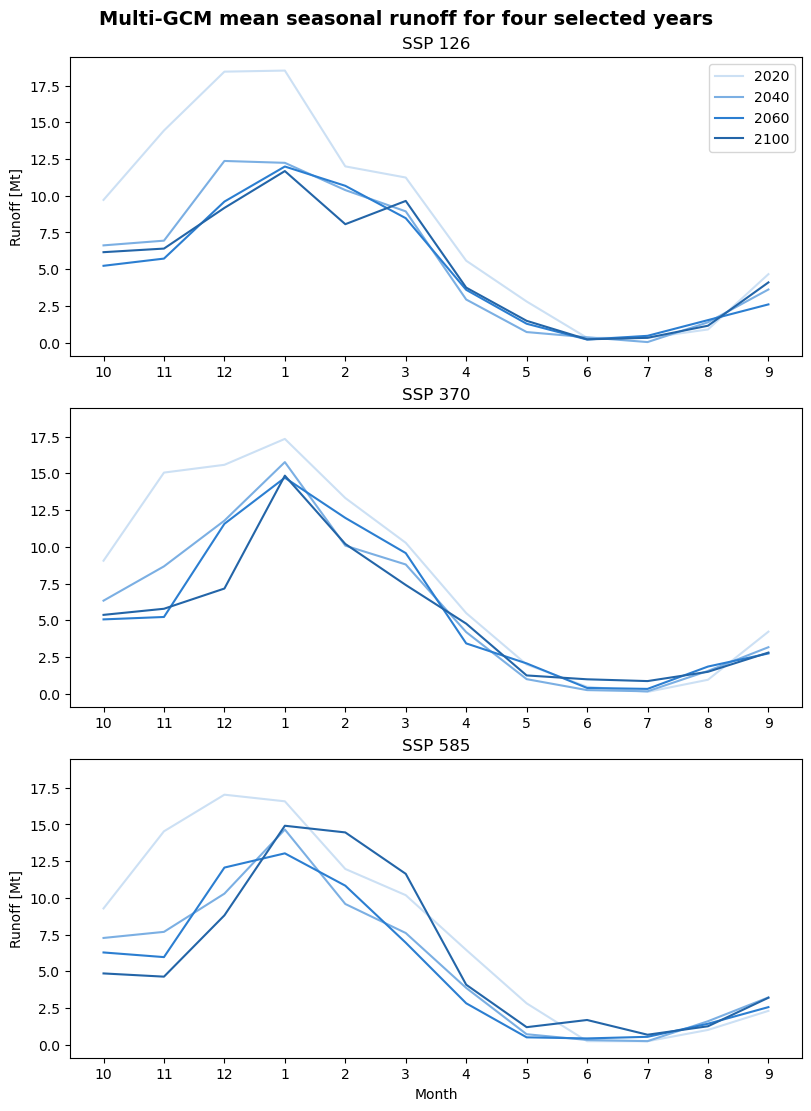

In [16]:
# Define keys for each SSP
key_dict = {
    'ssp126': [key for key in season_unroll.keys() if 'ssp126' in key],
    'ssp370': [key for key in season_unroll.keys() if 'ssp370' in key],
    'ssp585': [key for key in season_unroll.keys() if 'ssp585' in key]
}

# Plot mean-GCM time slices
time = [0, 20, 40, 80]
color_ts = ['#cce0f4', '#7bafe3', '#2b7ed1', '#2365a8']

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 11), sharey=True, constrained_layout=True)

t_idx = 0
for t in time:
    season_t = season_sliced(key_dict['ssp126'], dict_roll, t)
    xvals = np.asarray(season_t.index) + 1
    ax1.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx += 1

t_idx = 0
for t in time:
    season_t = season_sliced(key_dict['ssp370'], dict_roll, t)
    xvals = np.asarray(season_t.index) + 1
    ax2.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx += 1

t_idx = 0
for t in time:
    season_t = season_sliced(key_dict['ssp585'], dict_roll, t)
    xvals = np.asarray(season_t.index) + 1
    ax3.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx += 1

ax1.set(xticks=season_roll['month_2d'].values,
        xticklabels=season_roll2['month_2d'].values,
        title='SSP 126',
        ylabel='Runoff [Mt]')
ax2.set(xticks=season_roll['month_2d'].values,
        xticklabels=season_roll2['month_2d'].values,
        title='SSP 370')
ax3.set(xticks=season_roll['month_2d'].values,
        xticklabels=season_roll2['month_2d'].values,
        title='SSP 585',
        xlabel='Month',
        ylabel='Runoff [Mt]')
ax1.legend()

plt.suptitle('Multi-GCM mean seasonal runoff for four selected years', fontweight='bold', fontsize=14)
plt.show()

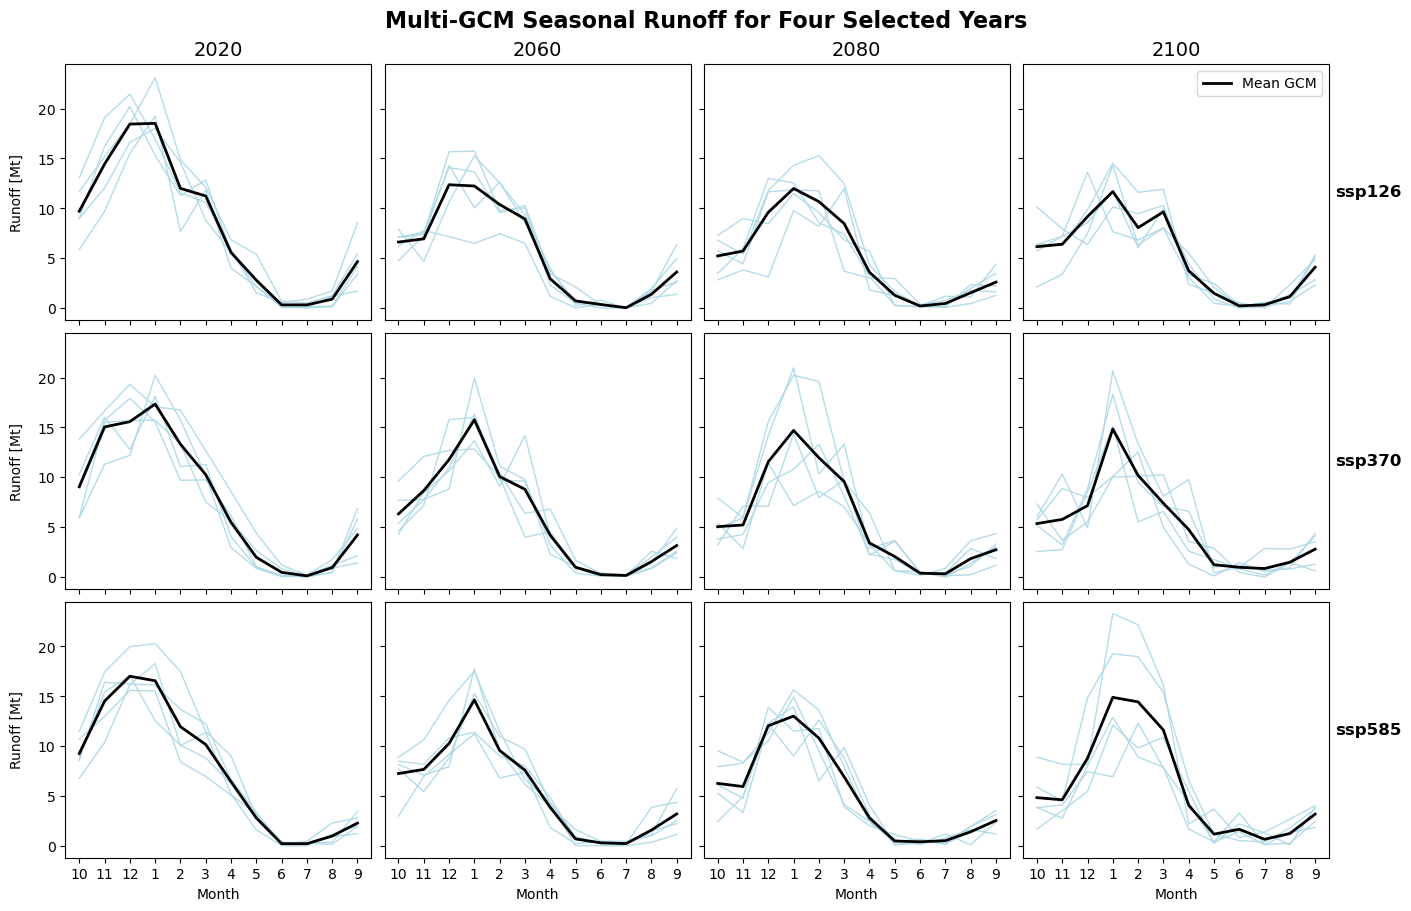

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Define keys for each SSP
key_dict = {
    'ssp126': [key for key in season_unroll.keys() if 'ssp126' in key],
    'ssp370': [key for key in season_unroll.keys() if 'ssp370' in key],
    'ssp585': [key for key in season_unroll.keys() if 'ssp585' in key]
}

# Plot individual GCM time slices and their mean
time = [0, 20, 40, 80]
years = [2020, 2040, 2060, 2100]
ssps = ['ssp126', 'ssp370', 'ssp585']

fig, axs = plt.subplots(len(ssps), len(time), figsize=(14, 9), sharey=True, constrained_layout=True)

for i, ssp in enumerate(ssps):
    for j, (t, year) in enumerate(zip(time, years)):
        ssp_keys = key_dict[ssp]
        gcm_data = []

        for key in ssp_keys:
            season_t = season_sliced([key], dict_roll, t)  # Extract data for the current GCM
            xvals = np.asarray(season_t.index) + 1
            ax = axs[i, j]
            ax.plot(xvals, season_t['mean'], color='lightblue', alpha=0.9, linewidth=1)  # Plot individual GCMs
            gcm_data.append(season_t['mean'].values)

        # Calculate and plot the mean GCM
        if gcm_data:
            mean_gcm = np.mean(gcm_data, axis=0)
            ax.plot(xvals, mean_gcm, color='black', linewidth=2, label='Mean GCM')

        if j == 0:
            ax.set_ylabel(f'Runoff [Mt]', labelpad=10)  # Adjust label padding
        
        if i == len(ssps) - 1:
            ax.set_xlabel('Month')
            ax.set_xticks(season_roll['month_2d'].values)
            ax.set_xticklabels(season_roll2['month_2d'].values)
            ax.xaxis.set_ticks_position('bottom')  # Ensure ticks are shown on the bottom axis
        else:
            ax.set_xticks(season_roll['month_2d'].values)  # Keep x-axis ticks for all rows
            ax.set_xticklabels([])  # Remove x-axis labels for plots not on the bottom row

        # Place SSP label on the far right side
        if j == len(time) - 1:
            ax.text(1.02, 0.5, ssp, transform=ax.transAxes, ha='left', va='center', fontsize=12, fontweight='bold')
        
        ax.grid(False)  # Remove grid lines
        #ax.set_title(f'{year}', fontsize=14)  # Set year as title

        axs[0, 0].set_title('2020', fontsize=14)
        axs[0, 1].set_title('2060', fontsize=14)
        axs[0, 2].set_title('2080', fontsize=14)
        axs[0, 3].set_title('2100', fontsize=14)

# Move legend to top right plot
axs[0, -1].legend(loc='upper right')

plt.suptitle('Multi-GCM Seasonal Runoff for Four Selected Years', fontweight='bold', fontsize=16)
plt.show()

In [18]:
# Statistical summary for above plot

# Define keys for each SSP
key_dict = {
    'ssp126': [key for key in season_unroll.keys() if 'ssp126' in key],
    'ssp370': [key for key in season_unroll.keys() if 'ssp370' in key],
    'ssp585': [key for key in season_unroll.keys() if 'ssp585' in key]
}

# Plot individual GCM time slices and their mean
time = [0, 20, 40, 80]
years = [2020, 2040, 2060, 2100]
ssps = ['ssp126', 'ssp370', 'ssp585']

percent_diff_gcm = []
percent_diff_ssp = []

# Calculate percent difference between highest and lowest GCM for each year and SSP
for i, ssp in enumerate(ssps):
    for j, year in enumerate(years):
        ssp_keys = key_dict[ssp]
        gcm_data = []
        
        for key in ssp_keys:
            season_t = season_sliced([key], dict_roll, time[j])  # Extract data for the current GCM and year
            gcm_data.append(season_t['mean'].values.sum())  # Sum of mean values
        
        max_gcm = np.max(gcm_data)
        min_gcm = np.min(gcm_data)
        percent_diff = (max_gcm - min_gcm) / min_gcm * 100
        
        percent_diff_gcm.append((year, ssp, percent_diff))

# Calculate percent difference between SSPs for each year
for j, year in enumerate(years):
    ssp_data = []
    for ssp in ssps:
        ssp_keys = key_dict[ssp]
        ssp_total = 0
        for key in ssp_keys:
            season_t = season_sliced([key], dict_roll, time[j])  # Extract data for the current SSP and year
            ssp_total += season_t['mean'].values.sum()  # Sum of mean values
        ssp_data.append(ssp_total)
    
    max_ssp = np.max(ssp_data)
    min_ssp = np.min(ssp_data)
    percent_diff = (max_ssp - min_ssp) / min_ssp * 100
    percent_diff_ssp.append((year, percent_diff))

# Print statistical summary
print("Statistical Summary based on Total Runoff (sum of mean monthly values):")
for year, ssp, percent_diff in percent_diff_gcm:
    print(f"Year: {year}, SSP: {ssp}")
    print(f"  Percent Difference Between Highest and Lowest GCM: {percent_diff:.2f}%")
    print()

print("Percent Difference Between SSPs for Each Year:")
for year, percent_diff in percent_diff_ssp:
    print(f"Year: {year}")
    print(f"  Percent Difference Between SSPs: {percent_diff:.2f}%")
    print()


Statistical Summary based on Total Runoff (sum of mean monthly values):
Year: 2020, SSP: ssp126
  Percent Difference Between Highest and Lowest GCM: 44.73%

Year: 2040, SSP: ssp126
  Percent Difference Between Highest and Lowest GCM: 39.73%

Year: 2060, SSP: ssp126
  Percent Difference Between Highest and Lowest GCM: 76.27%

Year: 2100, SSP: ssp126
  Percent Difference Between Highest and Lowest GCM: 28.37%

Year: 2020, SSP: ssp370
  Percent Difference Between Highest and Lowest GCM: 35.06%

Year: 2040, SSP: ssp370
  Percent Difference Between Highest and Lowest GCM: 6.68%

Year: 2060, SSP: ssp370
  Percent Difference Between Highest and Lowest GCM: 95.69%

Year: 2100, SSP: ssp370
  Percent Difference Between Highest and Lowest GCM: 72.71%

Year: 2020, SSP: ssp585
  Percent Difference Between Highest and Lowest GCM: 39.48%

Year: 2040, SSP: ssp585
  Percent Difference Between Highest and Lowest GCM: 42.58%

Year: 2060, SSP: ssp585
  Percent Difference Between Highest and Lowest GCM: 22

In [17]:
## keeping this due to ease of copy + paste

# import matplotlib.pyplot as plt
# import xarray as xr
# import numpy as np
# import pandas as pd
# import os

# # Function to load the dataset
# def open_series(fpath_stem, which_date, which_gcm, which_ssp):
#     this_fpath = os.path.expanduser(fpath_stem + '{}-gcm_data_{}_{}_compiled_output.nc'.format(which_date, which_gcm, which_ssp))
#     return xr.open_dataset(this_fpath)

# # Calculate seasonal runoff
# def calc_seasonal(this_ds):
#     melt1 = this_ds.melt_on_glacier_monthly
#     melt2 = this_ds.melt_off_glacier_monthly
#     melt3 = this_ds.liq_prcp_off_glacier_monthly
#     melt4 = this_ds.liq_prcp_on_glacier_monthly

#     # Calculate total liquid precipitation
#     total_liq_prcp_m = melt3.sum(dim='rgi_id').dropna(dim='time') + melt4.sum(dim='rgi_id').dropna(dim='time')

#     # Calculate total runoff
#     this_sum = melt1.sum(dim='rgi_id').dropna(dim='time') + melt2.sum(dim='rgi_id').dropna(dim='time') + total_liq_prcp_m
#     nonzero_sum = this_sum.where(this_sum != 0, drop=True)
#     nonzero_sum *= 1e-9

#     return nonzero_sum

# # Select a year and take the mean runoff of all GCMs for this year
# def season_sliced(keys, dictionary, time):
#     new_df = pd.DataFrame()
#     for k in keys:
#         new = dictionary[k]
#         new = new.isel(time=time)
#         new = pd.DataFrame(new)
#         new_df[k] = new
#     new_df['mean'] = new_df.transpose().mean()
#     return new_df

# # Calculate monthly runoff for a given runoff value
# def rtype_calc_monthly(keys, dictionary, runoff):
#     dataframe = pd.DataFrame()
#     for k in keys:
#         rtype_gcm = dictionary[k]
#         if runoff == 'total_liq_prcp_m':
#             rtype = rtype_gcm['liq_prcp_off_glacier_m'] + rtype_gcm['liq_prcp_on_glacier_m']
#         else:
#             if runoff.endswith('_m'):
#                 rtype = rtype_gcm[runoff]
#             else:
#                 rtype = rtype_gcm[runoff + '_monthly']  # Assuming your data keys end with '_monthly'
#         rtype = pd.DataFrame(rtype)
#         dataframe[k] = rtype
#     dataframe['mean'] = dataframe.transpose().mean()
#     return dataframe

# # Function to calculate and visualize runoff
# def plot_runoff(rtype_calc_s, rtype_calc_e, index2, ssp, season_roll, season_roll2):
#     runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'total_liq_prcp_m']  # Add total_liq_prcp_m here
#     s_keys = rtype_calc_s.keys()

#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
    
#     for r in runoff_variables:
#         if r == 'total_liq_prcp_m':
#             runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s, 'total_liq_prcp_m')
#             runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e, 'total_liq_prcp_m')
#         else:
#             runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s, r)
#             runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e, r)
        
#         ax1.plot(index2, runoff_s['mean'], label=r)
#         ax2.plot(index2, runoff_e['mean'], label=r)

#     ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
#     ax2.set(title='2090-2100')

#     for ax in (ax1, ax2):
#         ax.set(xticks=season_roll['month_2d'].values,
#                xticklabels=season_roll2['month_2d'].values,
#                xlabel='Calendar Month')
#         ax.legend()

#     plt.ylim([-0.5, 15])
#     plt.suptitle(f'Runoff Comparison for {ssp}')
#     plt.show()

# # Define variables
# base = '/Users/ziggygoddard/Documents/summer24/'
# gcm_list = ['gfdl-esm4_r1i1p1f1', 'mpi-esm1-2-hr_r1i1p1f1', 'mri-esm2-0_r1i1p1f1',
#                'ipsl-cm6a-lr_r1i1p1f1', 'ukesm1-0-ll_r1i1p1f2']
# date_list = ['2024-06-12', '2024-06-17']
# ssp_list = ['ssp126', 'ssp370', 'ssp585']
# n_roll = 3

# # Load datasets and calculate seasonal values
# all_monthly_dict = {}
# season_unroll = {}
# for gcm in gcm_list:
#     for date in date_list:
#         for ssp in ssp_list:
#             filepath = base + '{}-gcm_data_{}_{}_compiled_output.nc'.format(date, gcm, ssp)
#             if os.path.exists(filepath):
#                 ssp_value = open_series(fpath_stem=base, which_date=date, which_gcm=gcm, which_ssp=ssp)
#                 k = '{}-{}'.format(gcm, ssp)
#                 all_monthly_dict[k] = ssp_value
#                 season_unroll[k] = calc_seasonal(ssp_value)

# # Rolling and summing values
# dict_roll = {}
# rtype_roll = {}
# rtype_calc_s = {}
# rtype_calc_e = {}

# for k in season_unroll.keys():
#     season_roll = season_unroll[k].roll(month_2d=n_roll, roll_coords=False)
#     dict_roll[k] = season_roll
#     rtype_season = all_monthly_dict[k].roll(month_2d=n_roll, roll_coords=True)
#     rtype_sum = rtype_season.sum(dim='rgi_id')
#     rtype_roll[k] = rtype_sum

#     df_key = rtype_roll[k]
#     df_m_s = df_key.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
#     df_m_s.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
#     df_m_s = df_m_s.clip(0)
#     rtype_calc_s[k] = df_m_s

#     df_m_e = df_key.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
#     df_m_e.columns = [c.replace('_monthly', '_m') for c in df_m_e.columns]
#     df_m_e = df_m_e.clip(0)
#     rtype_calc_e[k] = df_m_e

# # Plotting for each SSP
# for ssp in ssp_list:
#     ssp_keys = [key for key in season_unroll.keys() if ssp in key]
#     season_roll2 = season_unroll[ssp_keys[0]].roll(month_2d=n_roll, roll_coords=True)
#     index1 = season_unroll[ssp_keys[0]]
#     index2 = index1['month_2d']
    
#     plot_runoff({k: v for k, v in rtype_calc_s.items() if ssp in k}, 
#                 {k: v for k, v in rtype_calc_e.items() if ssp in k}, 
#                 index2, ssp, season_roll, season_roll2)

# # Define keys for each SSP
# key_dict = {
#     'ssp126': list(season_unroll.keys()),
#     'ssp370': list(season_unroll.keys()),
#     'ssp585': list(season_unroll.keys())
# }


In [18]:
## see this code if you don't want to sum precip components

# import matplotlib.pyplot as plt
# import xarray as xr
# import numpy as np
# import pandas as pd
# import os

# # Function to load the dataset
# def open_series(fpath_stem, which_date, which_gcm, which_ssp):
#     this_fpath = os.path.expanduser(fpath_stem + '{}-gcm_data_{}_{}_compiled_output.nc'.format(which_date, which_gcm, which_ssp))
#     return xr.open_dataset(this_fpath)

# # Calculate seasonal runoff
# def calc_seasonal(this_ds):
#     melt1 = this_ds.melt_on_glacier_monthly
#     melt2 = this_ds.melt_off_glacier_monthly
#     melt3 = this_ds.liq_prcp_off_glacier_monthly
#     melt4 = this_ds.liq_prcp_on_glacier_monthly

#     this_sum = melt1.sum(dim='rgi_id').dropna(dim='time') + melt2.sum(dim='rgi_id').dropna(dim='time') + melt3.sum(dim='rgi_id').dropna(dim='time') + melt4.sum(dim='rgi_id').dropna(dim='time')
#     nonzero_sum = this_sum.where(this_sum != 0, drop=True)
#     nonzero_sum *= 1e-9

#     return nonzero_sum

# # Select a year and take the mean runoff of all GCMs for this year
# def season_sliced(keys, dictionary, time):
#     new_df = pd.DataFrame()
#     for k in keys:
#         new = dictionary[k]
#         new = new.isel(time=time)
#         new = pd.DataFrame(new)
#         new_df[k] = new
#     new_df['mean'] = new_df.transpose().mean()
#     return new_df

# # Calculate monthly runoff for a given runoff value
# def rtype_calc_monthly(keys, dictionary, runoff):
#     dataframe = pd.DataFrame()
#     for k in keys:
#         rtype_gcm = dictionary[k]
#         rtype = rtype_gcm[runoff]
#         rtype = pd.DataFrame(rtype)
#         dataframe[k] = rtype
#         dataframe['mean'] = dataframe.transpose().mean()
#     return dataframe

# # Function to calculate and visualize runoff
# def plot_runoff(rtype_calc_s, rtype_calc_e, index2, ssp, season_roll, season_roll2):
#     runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
#     s_keys = rtype_calc_s.keys()

#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

#     for r in runoff_variables:
#         runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s, r)
#         runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e, r)
#         ax1.plot(index2, runoff_s['mean'], label=r)
#         ax2.plot(index2, runoff_e['mean'], label=r)

#     ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
#     ax2.set(title='2090-2100')

#     for ax in (ax1, ax2):
#         ax.set(xticks=season_roll['month_2d'].values,
#                xticklabels=season_roll2['month_2d'].values,
#                xlabel='Calendar Month')
#         ax.legend()

#     plt.ylim([-0.5, 15])
#     plt.suptitle(f'Runoff Comparison for {ssp}')
#     plt.show()
    
# # 'gfdl-esm4_r1i1p1f1', 
# # Define variables
# base = '/Users/ziggygoddard/Documents/summer24/'
# gcm_list = ['mpi-esm1-2-hr_r1i1p1f1', 'mri-esm2-0_r1i1p1f1',
#                'ipsl-cm6a-lr_r1i1p1f1', 'ukesm1-0-ll_r1i1p1f2']
# date_list = ['2024-06-12', '2024-06-17', '2024-06-19']
# ssp_list = ['ssp126', 'ssp370', 'ssp585']
# n_roll = 3

# # Load datasets and calculate seasonal values
# all_monthly_dict = {}
# season_unroll = {}
# for gcm in gcm_list:
#     for date in date_list:
#         for ssp in ssp_list:
#             filepath = base + '{}-gcm_data_{}_{}_compiled_output.nc'.format(date, gcm, ssp)
#             if os.path.exists(filepath):
#                 ssp_value = open_series(fpath_stem=base, which_date=date, which_gcm=gcm, which_ssp=ssp)
#                 k = '{}-{}'.format(gcm, ssp)
#                 all_monthly_dict[k] = ssp_value
#                 season_unroll[k] = calc_seasonal(ssp_value)

# # Rolling and summing values
# dict_roll = {}
# rtype_roll = {}
# rtype_calc_s = {}
# rtype_calc_e = {}

# for k in season_unroll.keys():
#     season_roll = season_unroll[k].roll(month_2d=n_roll, roll_coords=False)
#     dict_roll[k] = season_roll
#     rtype_season = all_monthly_dict[k].roll(month_2d=n_roll, roll_coords=True)
#     rtype_sum = rtype_season.sum(dim='rgi_id')
#     rtype_roll[k] = rtype_sum

#     df_key = rtype_roll[k]
#     df_m_s = df_key.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
#     df_m_s.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
#     df_m_s = df_m_s.clip(0)
#     rtype_calc_s[k] = df_m_s

#     df_m_e = df_key.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
#     df_m_e.columns = [c.replace('_monthly', '_m') for c in df_m_e.columns]
#     df_m_e = df_m_e.clip(0)
#     rtype_calc_e[k] = df_m_e

# # Plotting for each SSP
# for ssp in ssp_list:
#     ssp_keys = [key for key in season_unroll.keys() if ssp in key]
#     season_roll2 = season_unroll[ssp_keys[0]].roll(month_2d=n_roll, roll_coords=True)
#     index1 = season_unroll[ssp_keys[0]]
#     index2 = index1['month_2d']

#     plot_runoff({k: v for k, v in rtype_calc_s.items() if ssp in k},
#                 {k: v for k, v in rtype_calc_e.items() if ssp in k},
#                 index2, ssp, season_roll, season_roll2)

In [19]:
# # This is code to check missing and loaded files
# base = '/Users/ziggygoddard/Documents/summer24/'
 
# gcm_list = ['mpi-esm1-2-hr_r1i1p1f1', 'mri-esm2-0_r1i1p1f1', 
#             'ipsl-cm6a-lr_r1i1p1f1', 'ukesm1-0-ll_r1i1p1f2', 'gfdl-esm4_r1i1p1f1']
# date_list = ['2024-06-19', '2024-06-20']
# ssp_list = ['ssp126', 'ssp370', 'ssp585']

# missing_files = []
# all_monthly_dict = {}
# season_unroll = {}

# for date in date_list:
#     for gcm in gcm_list:
#         for ssp in ssp_list:
#             filepath = f"{base}{date}-gcm_data_{gcm}_{ssp}_compiled_output.nc"
#             if os.path.exists(filepath):
#                 try:
#                     ssp_value = xr.open_dataset(filepath)
#                     k = f"{gcm}-{ssp}"
#                     all_monthly_dict[k] = ssp_value
#                     season_unroll[k] = calc_seasonal(ssp_value)
#                     print(f"Loaded and processed: {filepath}")
#                 except Exception as e:
#                     pass
#             else:
#                 pass

# if missing_files:
#     print("Missing files:")
#     for file in missing_files:
#         print(file)

# 2. Annual runoff

In [19]:
# Prepare data, already done at top of notebook
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Function: load the dataset
def open_series(fpath_stem, which_date, which_gcm, which_ssp):
    this_fpath = fpath_stem + '{}-gcm_data_{}_{}_compiled_output.nc'.format(which_date, which_gcm, which_ssp)
    if os.path.exists(this_fpath):
        this_ds = xr.open_dataset(this_fpath)
        return this_ds

# Define the file path, dates, GCMs, and RCPs
base = '/Users/ziggygoddard/Documents/summer24/' 
gcm_list = ['mpi-esm1-2-hr_r1i1p1f1', 'mri-esm2-0_r1i1p1f1', 'ipsl-cm6a-lr_r1i1p1f1', 
            'ukesm1-0-ll_r1i1p1f2', 'gfdl-esm4_r1i1p1f1']
date_list = ['2024-06-19', '2024-06-20']
ssp_list = ['ssp126', 'ssp370', 'ssp585']

## Functions

In [12]:
# Function to calculate annual runoff
def calc_annual_runoff(data_array):
    # Sum over the month_2d dimension to get annual data
    annual_sum = data_array.sum(dim='month_2d')
    return annual_sum

In [13]:
# Function to calculate annual runoff components
def calc_annual_runoff_components(this_ds):
    melt_on_glacier = this_ds.melt_on_glacier_monthly.sum(dim='month_2d').sum(dim='rgi_id').dropna(dim='time').sel(time=slice(None, '2101'))
    melt_off_glacier = this_ds.melt_off_glacier_monthly.sum(dim='month_2d').sum(dim='rgi_id').dropna(dim='time').sel(time=slice(None, '2101'))
    liq_prcp_off_glacier = this_ds.liq_prcp_off_glacier_monthly.sum(dim='month_2d').sum(dim='rgi_id').dropna(dim='time').sel(time=slice(None, '2101'))
    liq_prcp_on_glacier = this_ds.liq_prcp_on_glacier_monthly.sum(dim='month_2d').sum(dim='rgi_id').dropna(dim='time').sel(time=slice(None, '2101'))

    annual_liq_prcp = liq_prcp_off_glacier + liq_prcp_on_glacier

    melt_on_glacier *= 1e-9
    melt_off_glacier *= 1e-9
    annual_liq_prcp *= 1e-9

    return {
        'melt_on_glacier': melt_on_glacier,
        'melt_off_glacier': melt_off_glacier,
        'annual_liq_prcp': annual_liq_prcp
    }

In [14]:
# Dictionary to store annual runoff for each GCM and SSP scenario
annual_runoff_dict = {}

for date in date_list:
    for gcm in gcm_list:
        for ssp in ssp_list:
            filepath = f"{base}{date}-gcm_data_{gcm}_{ssp}_compiled_output.nc"
            if os.path.exists(filepath):
                try:
                    ssp_value = xr.open_dataset(filepath)
                    k = f"{gcm}-{ssp}"
                    annual_runoff_dict[k] = calc_annual_runoff_components(ssp_value)
                    #print(f"Loaded and processed annual runoff for: {filepath}")
                except Exception as e:
                    #print(f"Failed to process {filepath}: {e}")
                    pass
            else:
                #print(f"File missing: {filepath}")
                pass

# Check the contents of annual_runoff_dict
#print(f"Loaded annual runoff datasets: {list(annual_runoff_dict.keys())}")

In [15]:
# Function to calculate the mean annual runoff across GCMs for each ssp scenario
def calculate_mean_annual_runoff(annual_runoff_dict, ssps):
    mean_annual_runoff = {}
    for ssp in ssps:
        ssp_data = [annual_runoff for scenario, annual_runoff in annual_runoff_dict.items() if ssp in scenario]
        if ssp_data:
            combined = {component: xr.concat([data[component] for data in ssp_data], dim='gcm').mean(dim='gcm') for component in ssp_data[0]}
            mean_annual_runoff[ssp] = combined
    return mean_annual_runoff

In [16]:
# Function to calculate total annual runoff
def calc_total_annual_runoff(annual_runoff_components):
    total_runoff = (annual_runoff_components['melt_on_glacier'] + 
                    annual_runoff_components['melt_off_glacier'] + 
                    annual_runoff_components['annual_liq_prcp'])
    return total_runoff

In [17]:
# Calculate total annual runoff for each scenario
total_annual_runoff_dict = {}
for key, components in annual_runoff_dict.items():
    total_annual_runoff_dict[key] = calc_total_annual_runoff(components)

## Plot total runoff + variance

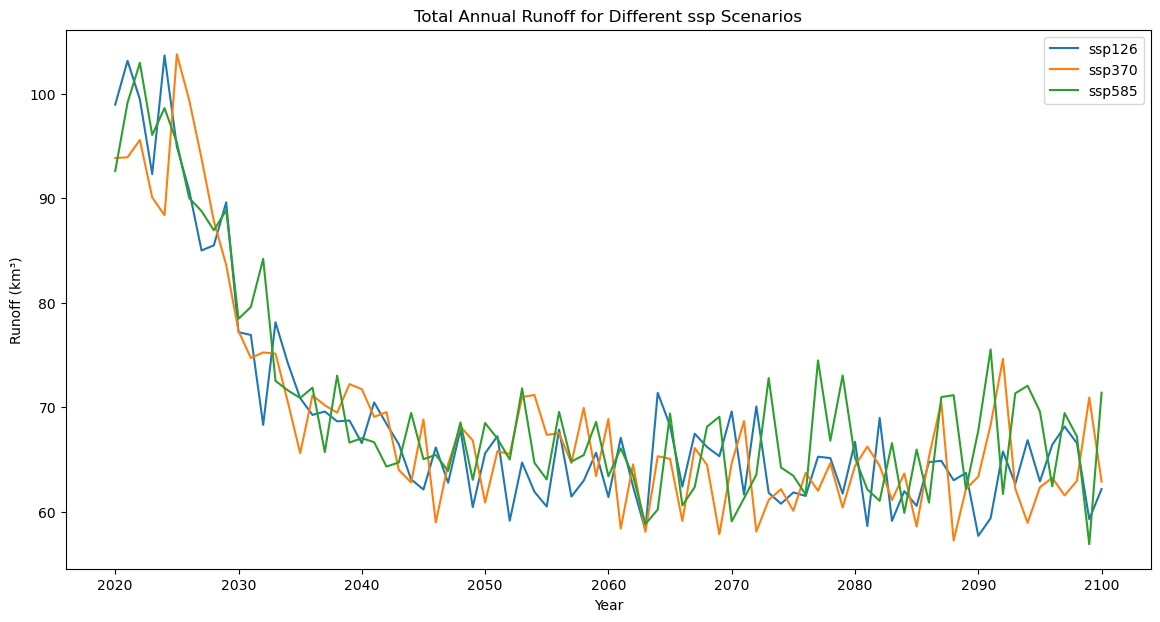

In [26]:
# Plotting total annual runoff
def plot_total_annual_runoff(total_annual_runoff_dict, ssps):
    plt.figure(figsize=(14, 7))
    
    for ssp in ssps:
        ssp_data = [runoff.sel(time=slice(None, '2101')) for scenario, runoff in total_annual_runoff_dict.items() if ssp in scenario]
        if ssp_data:
            combined_runoff = xr.concat(ssp_data, dim='gcm').mean(dim='gcm')
            combined_runoff.plot(label=ssp)

        # Set x-axis ticks to show years in increments of 20
        years = ssp_data[0]['time'].values  # Assuming the time coordinate is consistent across datasets

    plt.title('Total Annual Runoff for Different ssp Scenarios')
    plt.xlabel('Year')
    plt.ylabel('Runoff (km³)')
    plt.legend()
    plt.show()

plot_total_annual_runoff(total_annual_runoff_dict, ssp_list)

In [27]:
# # This plots values for both GCMs rather than mean. Bad visual, but useful to see how to do it.

# def plot_total_annual_runoff(total_annual_runoff_dict, ssps, plot_individual_gcms=False):
#     plt.figure(figsize=(14, 7))
    
#     for ssp in ssps:
#         if plot_individual_gcms:
#             for scenario, runoff in total_annual_runoff_dict.items():
#                 if ssp in scenario:
#                     runoff.sel(time=slice(None, '2101')).plot(label=f'{scenario}')
#         else:
#             ssp_data = [runoff.sel(time=slice(None, '2101')) for scenario, runoff in total_annual_runoff_dict.items() if ssp in scenario]
#             if ssp_data:
#                 combined_runoff = xr.concat(ssp_data, dim='gcm').mean(dim='gcm')
#                 combined_runoff.plot(label=ssp)

#     plt.title('Total Annual Runoff for Different ssp Scenarios')
#     plt.xlabel('Year')
#     plt.ylabel('Runoff (km³)')
#     plt.legend()
#     plt.show()

# plot_total_annual_runoff(total_annual_runoff_dict, ssp_list, plot_individual_gcms=True)

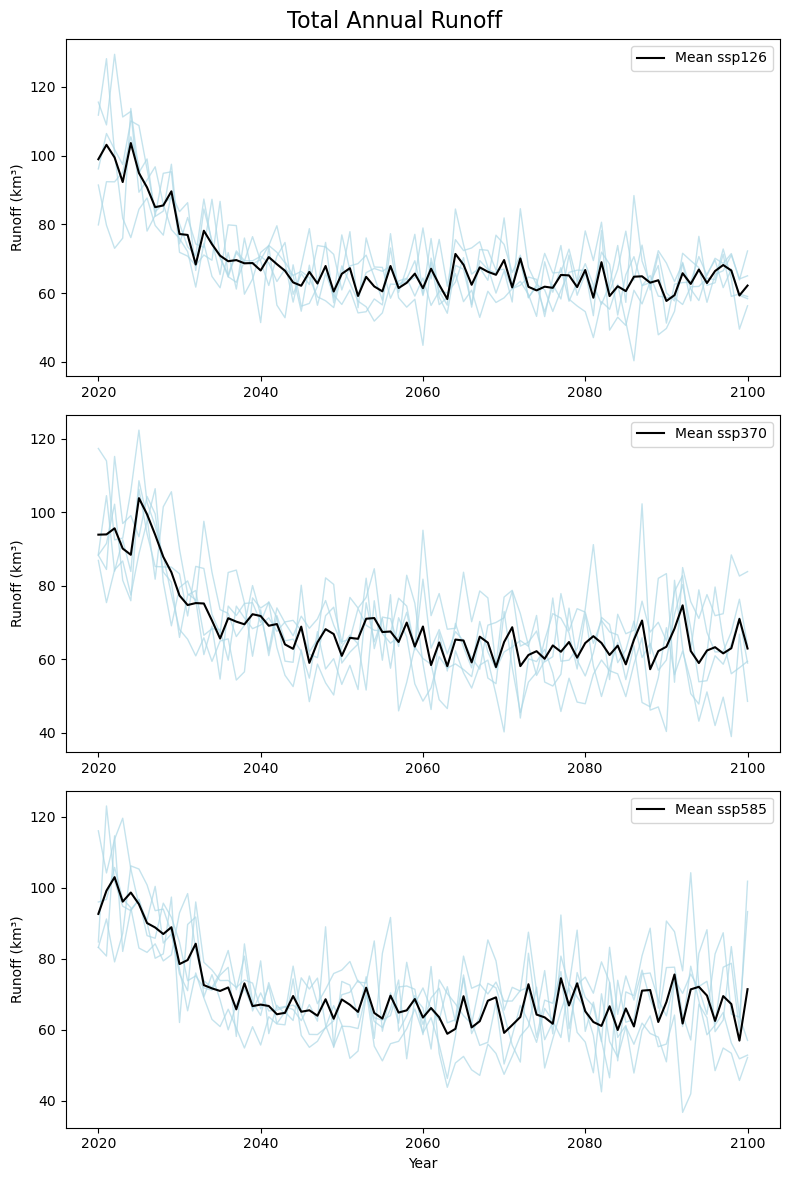

In [60]:
def plot_total_annual_runoff(total_annual_runoff_dict, ssps, window=1): # smooth with window value
    plt.figure(figsize=(8, 4 * len(ssps)))  # Adjusting figure size to accommodate multiple subplots
    
    for idx, ssp in enumerate(ssps):
        ax = plt.subplot(len(ssps), 1, idx + 1)
        
        ssp_data = [runoff.sel(time=slice(None, '2101')) for scenario, runoff in total_annual_runoff_dict.items() if ssp in scenario]
        
        if ssp_data:
            smoothed_data = [runoff.rolling(time=window, center=True).mean() for runoff in ssp_data]

            for runoff in smoothed_data:
                runoff.plot(ax=ax, color='lightblue', alpha=0.7, linewidth=1)  # Plot individual GCMs in light blue
                
            combined_runoff = xr.concat(smoothed_data, dim='gcm').mean(dim='gcm')
            combined_runoff.plot(ax=ax, color='black', linewidth=1.5, label=f'Mean {ssp}')  # Plot mean in black
            
        ax.set_ylabel('Runoff (km³)')
        ax.legend()
        
        # Set x-axis ticks to show years in increments of 20
        years = ssp_data[0]['time'].values  # Assuming the time coordinate is consistent across datasets
        ax.set_xticks(np.arange(years[0], years[-1] + 1, 20))

        # Only set x-axis label for the bottom subplot
        if idx == len(ssps) - 1:
            ax.set_xlabel('Year')
        else:
            ax.set_xlabel('')  # Remove x-axis label for top subplots
    
    plt.suptitle(f'Total Annual Runoff', fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming total_annual_runoff_dict and ssp_list are already defined
plot_total_annual_runoff(total_annual_runoff_dict, ssp_list)


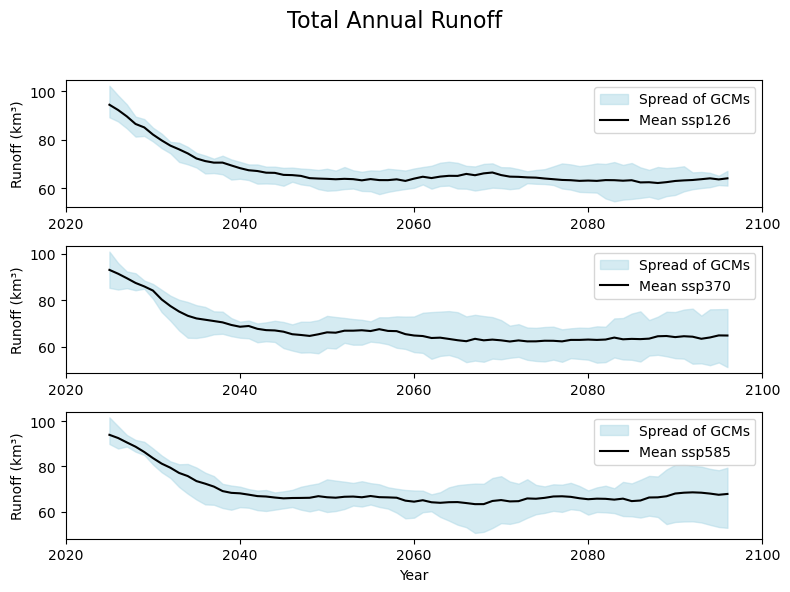

In [55]:
# better visualization of the spread, although this is nothing new
def plot_total_annual_runoff(total_annual_runoff_dict, ssps, window=10):
    plt.figure(figsize=(8, 6))  # Adjusting figure size
    
    for idx, ssp in enumerate(ssps):
        ax = plt.subplot(len(ssps), 1, idx + 1)
        
        ssp_data = [runoff.sel(time=slice(None, '2101')) for scenario, runoff in total_annual_runoff_dict.items() if ssp in scenario]
        
        if ssp_data:
            smoothed_data = [runoff.rolling(time=window, center=True).mean() for runoff in ssp_data]
            
            # Calculate minimum and maximum across GCMs
            min_runoff = xr.concat(smoothed_data, dim='gcm').min(dim='gcm')
            max_runoff = xr.concat(smoothed_data, dim='gcm').max(dim='gcm')
            
            # Plot shaded area between min and max
            years = ssp_data[0]['time'].values  # Assuming the time coordinate is consistent across datasets
            ax.fill_between(years, min_runoff.values, max_runoff.values, color='lightblue', alpha=0.5, label='Spread of GCMs')
            
            # Plot mean runoff
            combined_runoff = xr.concat(smoothed_data, dim='gcm').mean(dim='gcm')
            ax.plot(years, combined_runoff.values, color='black', linewidth=1.5, label=f'Mean {ssp}')
            
        ax.set_ylabel('Runoff (km³)')
        ax.legend()
        
        # Set x-axis ticks to show years in increments of 20
        ax.set_xticks(np.arange(years[0], years[-1] + 1, 20))
        
        # Only set x-axis label for the bottom subplot
        if idx == len(ssps) - 1:
            ax.set_xlabel('Year')
        else:
            ax.set_xlabel('')  # Remove x-axis label for top subplots
    
    plt.suptitle(f'Total Annual Runoff', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to accommodate the suptitle
    plt.show()

# Example usage assuming total_annual_runoff_dict and ssp_list are already defined
plot_total_annual_runoff(total_annual_runoff_dict, ssp_list)


In [61]:
def calculate_variance(total_annual_runoff_dict, ssps, window=20): # smooth with window value
    variance_dict = {}

    for ssp in ssps:
        ssp_data = [runoff.sel(time=slice(None, '2101')) for scenario, runoff in total_annual_runoff_dict.items() if ssp in scenario]
        
        if ssp_data:
            smoothed_data = [runoff.rolling(time=window, center=True).mean() for runoff in ssp_data]
            variance = xr.concat(smoothed_data, dim='gcm').var(dim='gcm')
            variance_dict[ssp] = variance
    
    return variance_dict

# Example usage
variance_dict = calculate_variance(total_annual_runoff_dict, ssp_list)

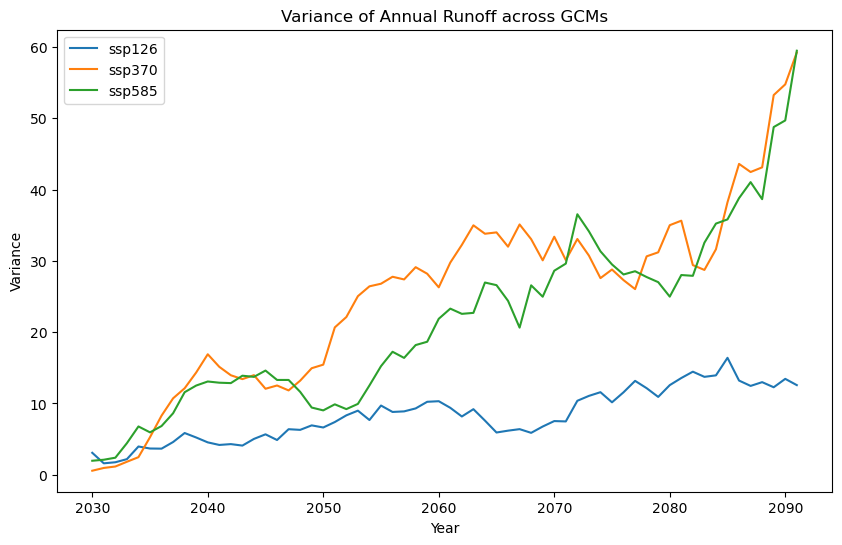

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming variance_dict contains the variance data as shown in your previous messages
# Example of extracting variance data for each SSP
ssp126_variance = variance_dict['ssp126']
ssp370_variance = variance_dict['ssp370']
ssp585_variance = variance_dict['ssp585']

# Time values (assuming time is a coordinate in the DataArray)
time_values = ssp126_variance['time'].values

# Plotting the variances
plt.figure(figsize=(10, 6))

plt.plot(time_values, ssp126_variance, label='ssp126')
plt.plot(time_values, ssp370_variance, label='ssp370')
plt.plot(time_values, ssp585_variance, label='ssp585')

plt.xlabel('Year')
plt.ylabel('Variance')
plt.title('Variance of Annual Runoff across GCMs')
plt.legend()
plt.grid(False)

plt.show()


## Plot annual runoff components

### ssp comparison (one plot for each component)

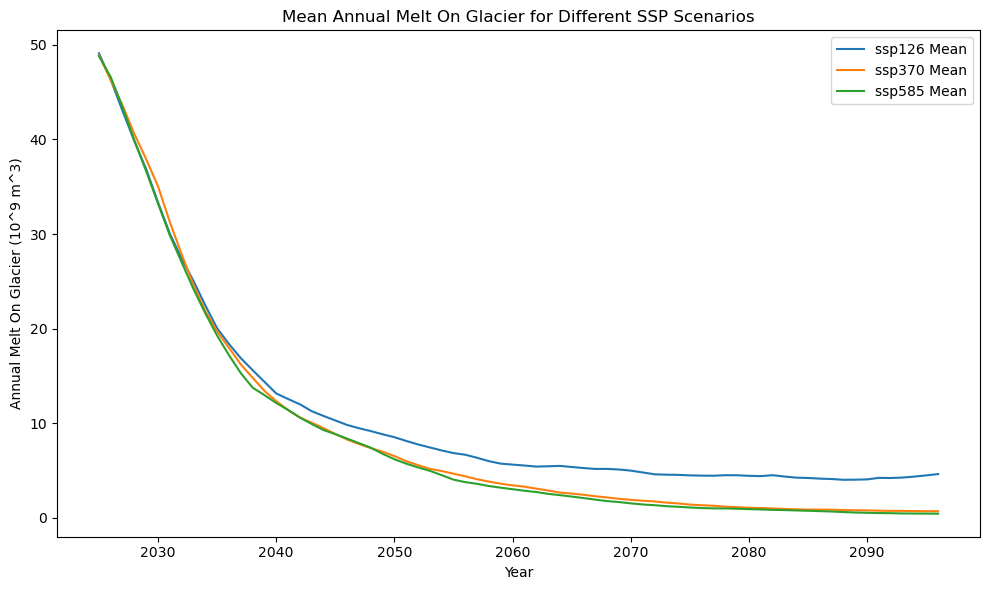

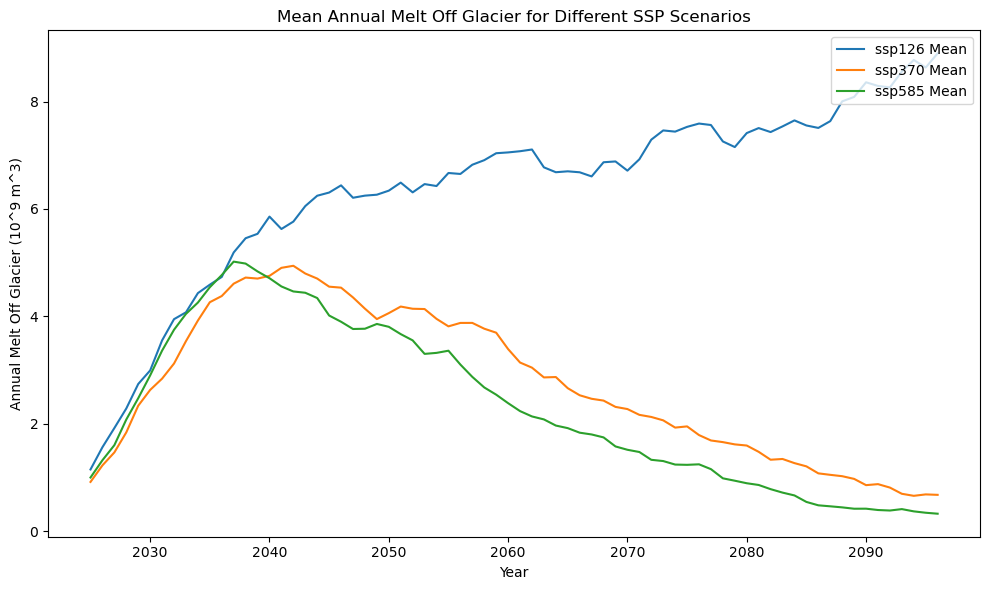

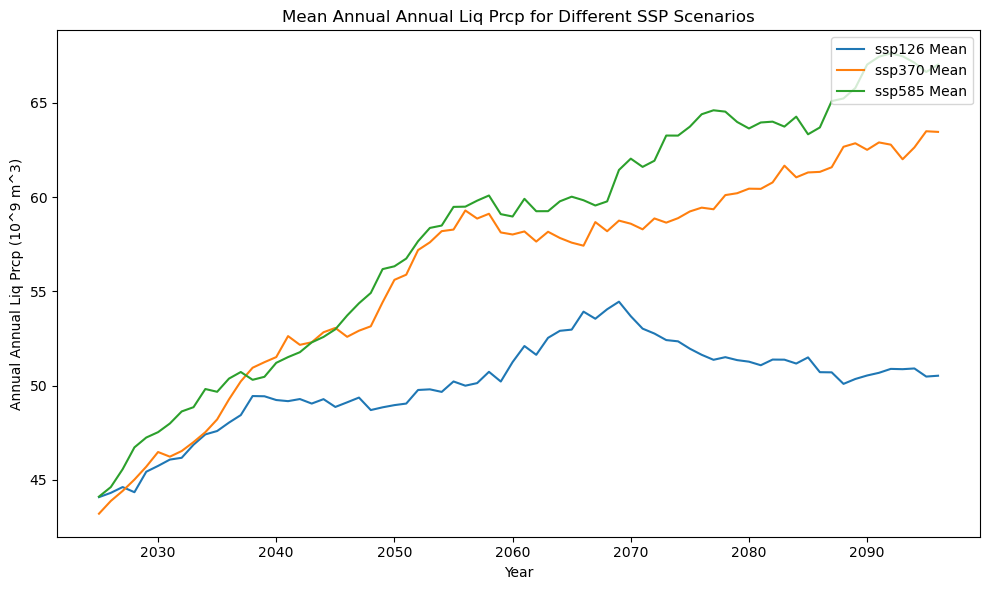

In [31]:
# this would be a useful one to look at individual gcms
import matplotlib.pyplot as plt

# Function to plot the mean annual runoff for each ssp scenario on one plot with smoothing
def plot_mean_annual_runoff(mean_annual_runoff, window=10): # smooth data
    components = list(mean_annual_runoff[next(iter(mean_annual_runoff))].keys())
    
    for component in components:
        plt.figure(figsize=(10, 6))

        for ssp, annual_runoff in mean_annual_runoff.items():
            # Apply rolling average
            smoothed_data = annual_runoff[component].rolling(time=window, center=True).mean()
            years = smoothed_data['time'].values
            runoff_values = smoothed_data.values
            plt.plot(years, runoff_values, label=f'{ssp} Mean')
        
        plt.xlabel('Year')
        plt.ylabel(f'Annual {component.replace("_", " ").title()} (10^9 m^3)')
        plt.title(f'Mean Annual {component.replace("_", " ").title()} for Different SSP Scenarios')
        plt.legend(loc='upper right')
        plt.grid(False)
        plt.tight_layout()
        plt.show()

# List of ssp scenarios
ssps = ['ssp126', 'ssp370', 'ssp585']

# Calculate the mean annual runoff for each ssp scenario
mean_annual_runoff = calculate_mean_annual_runoff(annual_runoff_dict, ssps)

# Call the plotting function
plot_mean_annual_runoff(mean_annual_runoff)

### Component comparison (one plot for each ssp)

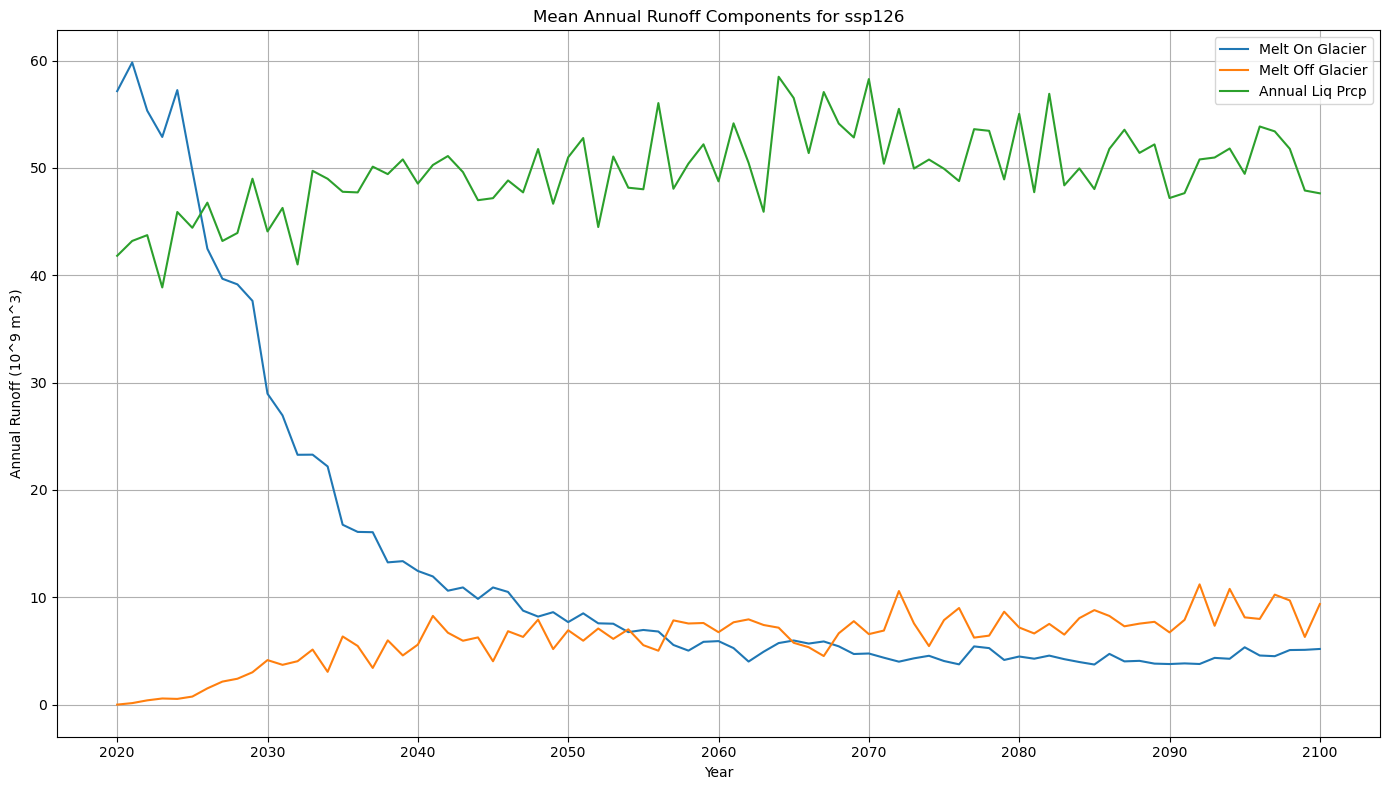

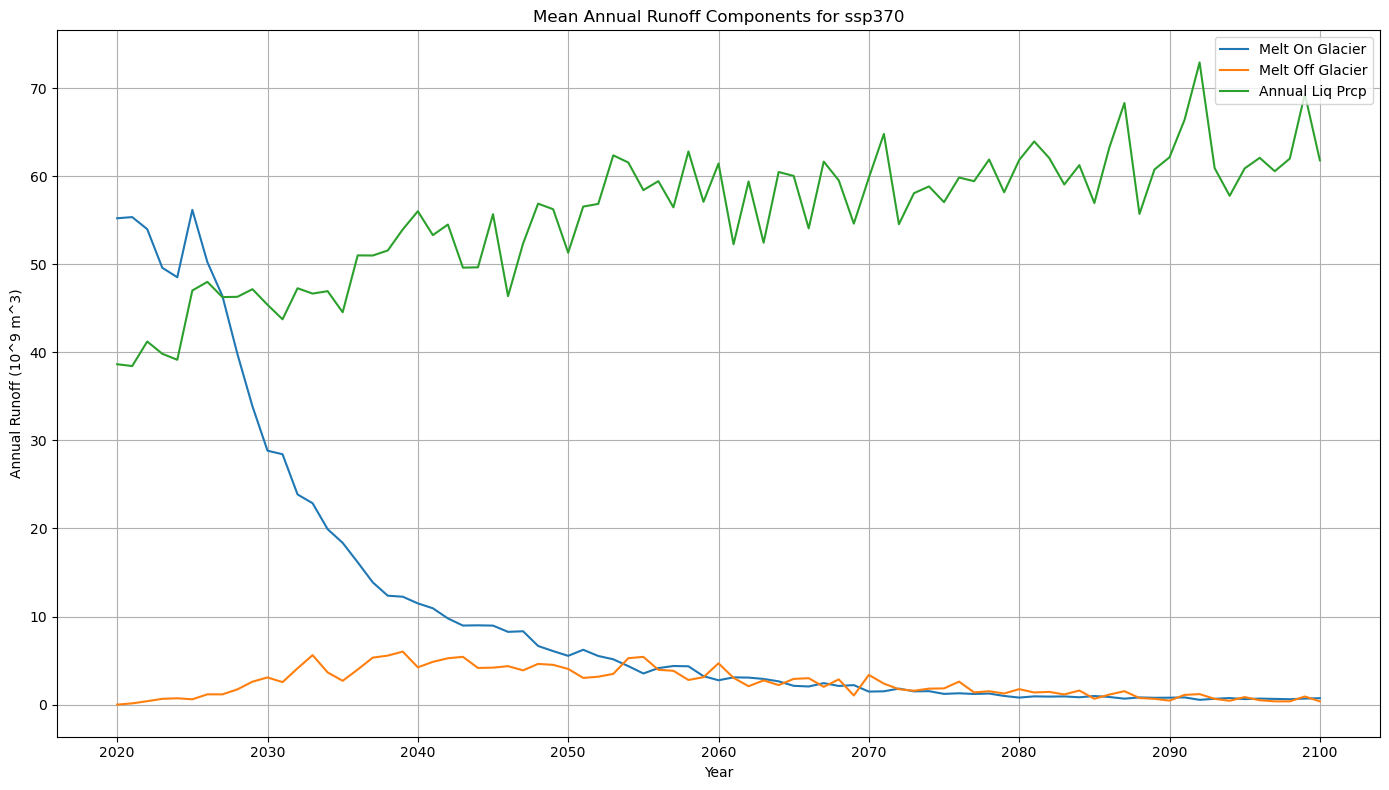

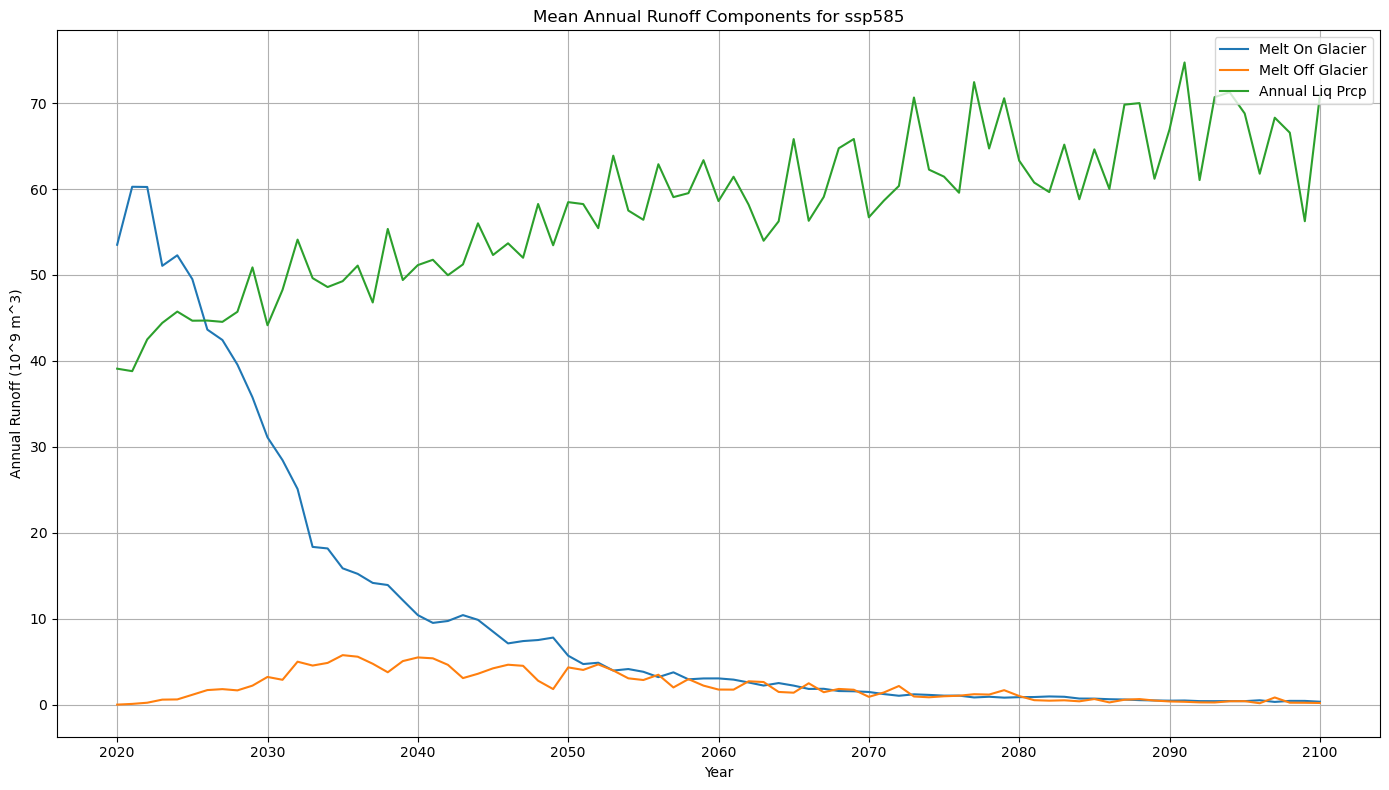

In [32]:
# Colors for runoff components
component_colors = {
    'melt_on_glacier_m': '#d16b6c',
    'melt_off_glacier_m': '#d9985f',
    'total_liq_prcp_m': '#946cbd'
}

# Function to plot the mean annual runoff for each ssp scenario with lines for each runoff component
def plot_mean_annual_runoff(mean_annual_runoff):
    for ssp, annual_runoff in mean_annual_runoff.items():
        plt.figure(figsize=(14, 8))

        for component, data in annual_runoff.items():
            years = data['time'].values
            runoff_values = data.values
            plt.plot(years, runoff_values, label=f'{component.replace("_", " ").title()}')
        
        plt.xlabel('Year')
        plt.ylabel('Annual Runoff (10^9 m^3)')
        plt.title(f'Mean Annual Runoff Components for {ssp}')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


# List of ssp scenarios
ssps = ['ssp126', 'ssp370', 'ssp585']

# Calculate the mean annual runoff for each ssp scenario
mean_annual_runoff = calculate_mean_annual_runoff(annual_runoff_dict, ssps)

# Call the plotting function
plot_mean_annual_runoff(mean_annual_runoff)

### Relative contribution of each component (lines)

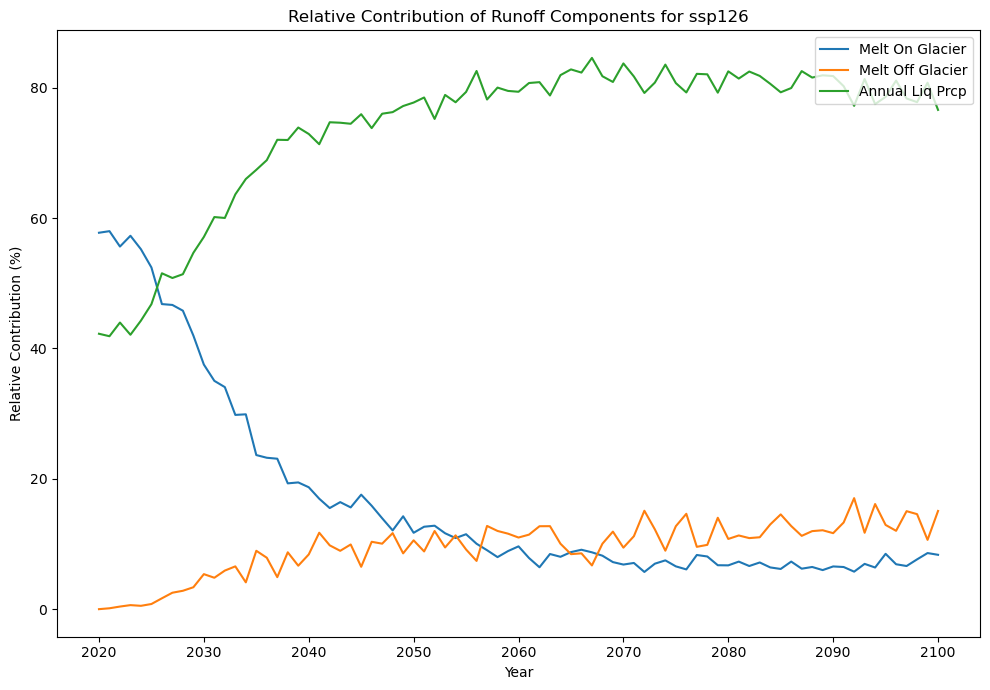

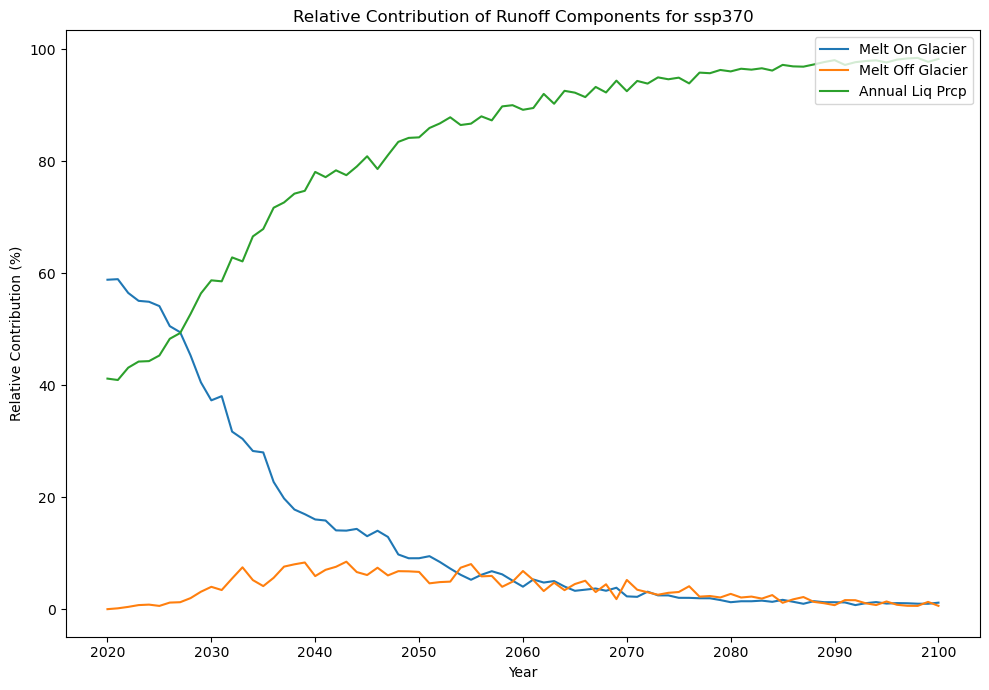

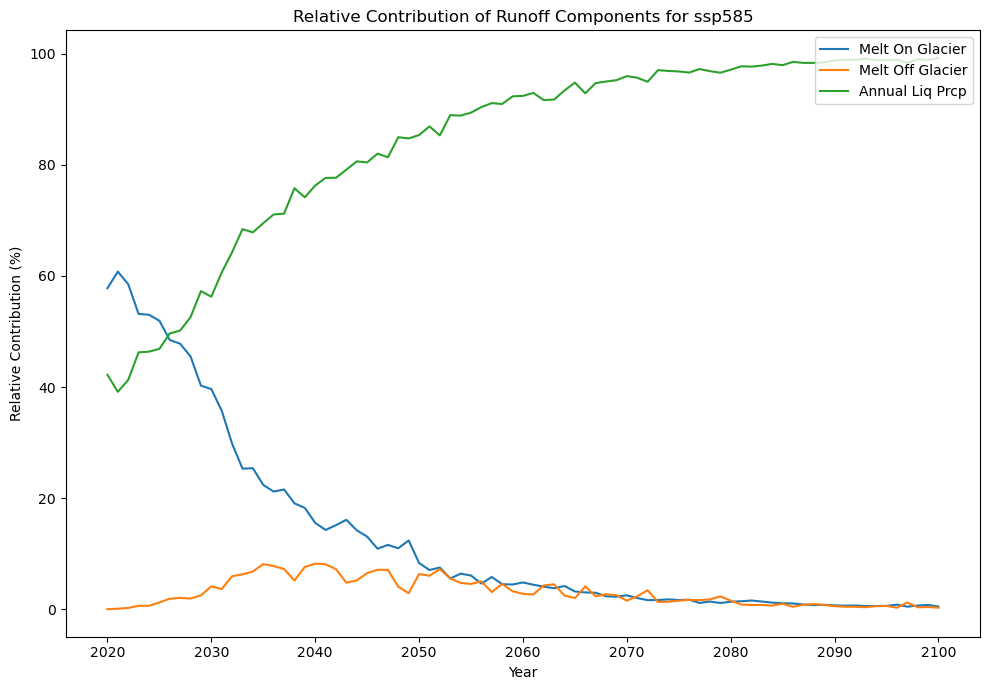

In [33]:
# Function to plot the relative contribution of each runoff component over time
def plot_relative_contribution(mean_annual_runoff):
    for ssp, annual_runoff in mean_annual_runoff.items():
        plt.figure(figsize=(10, 7))

        # Calculate total annual runoff for each year
        total_runoff = sum(annual_runoff[component] for component in annual_runoff)
        
        for component, data in annual_runoff.items():
            years = data['time'].values
            runoff_values = data.values
            # Calculate the relative contribution as a percentage
            relative_contribution = (runoff_values / total_runoff.values) * 100
            plt.plot(years, relative_contribution, label=f'{component.replace("_", " ").title()}')
        
        plt.xlabel('Year')
        plt.ylabel('Relative Contribution (%)')
        plt.title(f'Relative Contribution of Runoff Components for {ssp}')
        plt.legend(loc='upper right')
        plt.grid(False)
        plt.tight_layout()
        plt.show()

# List of ssp scenarios
ssps = ['ssp126', 'ssp370', 'ssp585']

# Calculate the mean annual runoff for each ssp scenario
mean_annual_runoff = calculate_mean_annual_runoff(annual_runoff_dict, ssps)

# Call the plotting function
plot_relative_contribution(mean_annual_runoff)


### Relative contribution of each component (areas)

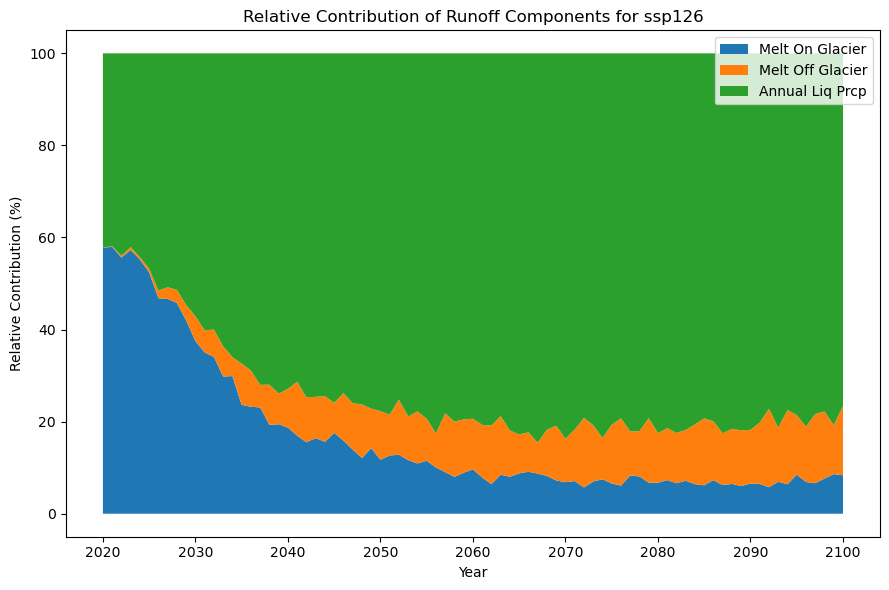

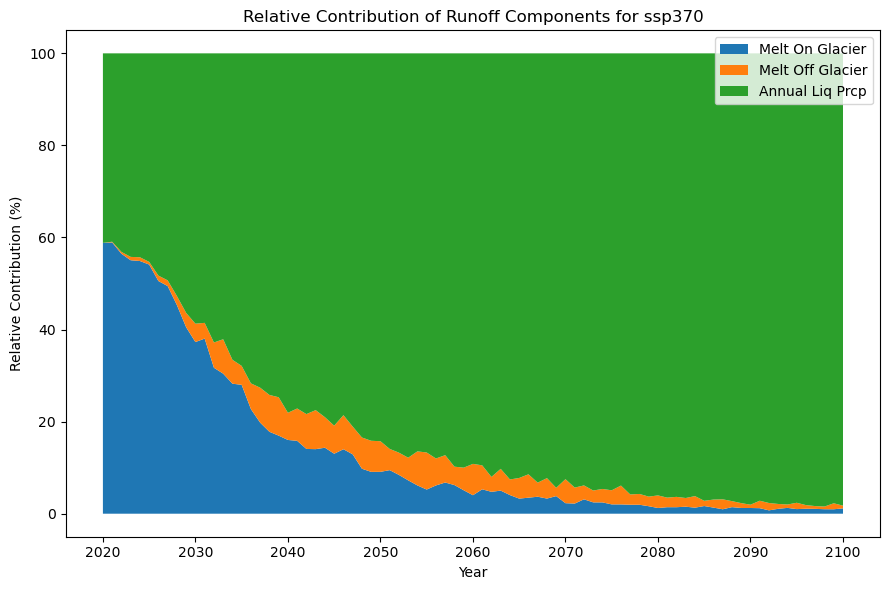

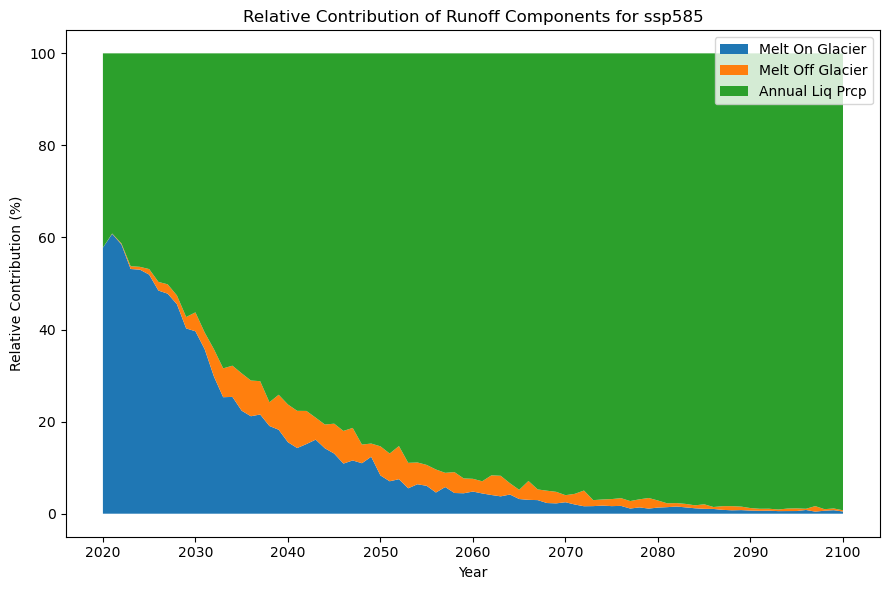

In [34]:
# Function to plot the relative contribution of each runoff component over time as filled areas
def plot_relative_contribution_filled(mean_annual_runoff):
    for ssp, annual_runoff in mean_annual_runoff.items():
        plt.figure(figsize=(9, 6))

        # Calculate total annual runoff for each year
        total_runoff = sum(annual_runoff[component] for component in annual_runoff)

        # Initialize arrays to store lower bounds of filled areas
        lower_bounds = np.zeros_like(total_runoff.values)

        # Plot each component as a filled area
        for component, data in annual_runoff.items():
            years = data['time'].values
            runoff_values = data.values
            # Calculate the relative contribution as a percentage
            relative_contribution = (runoff_values / total_runoff.values) * 100
            # Plot filled area
            plt.fill_between(years, lower_bounds, lower_bounds + relative_contribution, label=f'{component.replace("_", " ").title()}')
            # Update lower bounds for next component
            lower_bounds += relative_contribution
        
        plt.xlabel('Year')
        plt.ylabel('Relative Contribution (%)')
        plt.title(f'Relative Contribution of Runoff Components for {ssp}')
        plt.legend(loc='upper right')
        #plt.grid(True)
        plt.tight_layout()
        plt.show()

# List of ssp scenarios
ssps = ['ssp126', 'ssp370', 'ssp585']

# Calculate the mean annual runoff for each ssp scenario
mean_annual_runoff = calculate_mean_annual_runoff(annual_runoff_dict, ssps)

# Call the plotting function
plot_relative_contribution_filled(mean_annual_runoff)


# 3. Glacier volume

In [35]:
# # Prepare data
# import matplotlib.pyplot as plt
# import xarray as xr
# import os

# # Define the file path, dates, GCMs, and SSPs
# base = '/Users/ziggygoddard/Documents/summer24/' 
# gcm_list = ['mpi-esm1-2-hr_r1i1p1f1', 'mri-esm2-0_r1i1p1f1', 'ipsl-cm6a-lr_r1i1p1f1', 
#             'ukesm1-0-ll_r1i1p1f2', 'gfdl-esm4_r1i1p1f1']
# date_list = ['2024-06-19', '2024-06-20']
# ssp_list = ['ssp126', 'ssp370', 'ssp585']

# # Function to load the dataset
# def open_series(fpath_stem, which_date, which_gcm, which_ssp):
#     this_fpath = fpath_stem + '{}-gcm_data_{}_{}_compiled_output.nc'.format(which_date, which_gcm, which_ssp)
#     if os.path.exists(this_fpath):
#         this_ds = xr.open_dataset(this_fpath)
#         return this_ds
#     else:
#         return None

In [36]:
# Dictionary to store volume data for each GCM and SSP scenario
volume_data_dict = {}

for date in date_list:
    for gcm in gcm_list:
        for ssp in ssp_list:
            filepath = f"{base}{date}-gcm_data_{gcm}_{ssp}_compiled_output.nc"
            if os.path.exists(filepath):
                try:
                    dataset = xr.open_dataset(filepath)
                    k = f"{gcm}-{ssp}"
                    volume_data_dict[k] = dataset['volume']
                    #print(f"Loaded volume data for: {gcm} - {ssp}")  # checks that all GCMs loaded
                except Exception as e:
                    pass
            else:
                pass

# Calculate the mean volume over the GCMs for each SSP
def calculate_mean_volume(volume_data_dict, ssps):
    mean_volume = {}
    for ssp in ssps:
        ssp_data = [volume for key, volume in volume_data_dict.items() if ssp in key]
        if ssp_data:
            combined_volume = xr.concat(ssp_data, dim='gcm').mean(dim='gcm')
            mean_volume[ssp] = combined_volume
    return mean_volume

mean_volume = calculate_mean_volume(volume_data_dict, ssp_list)

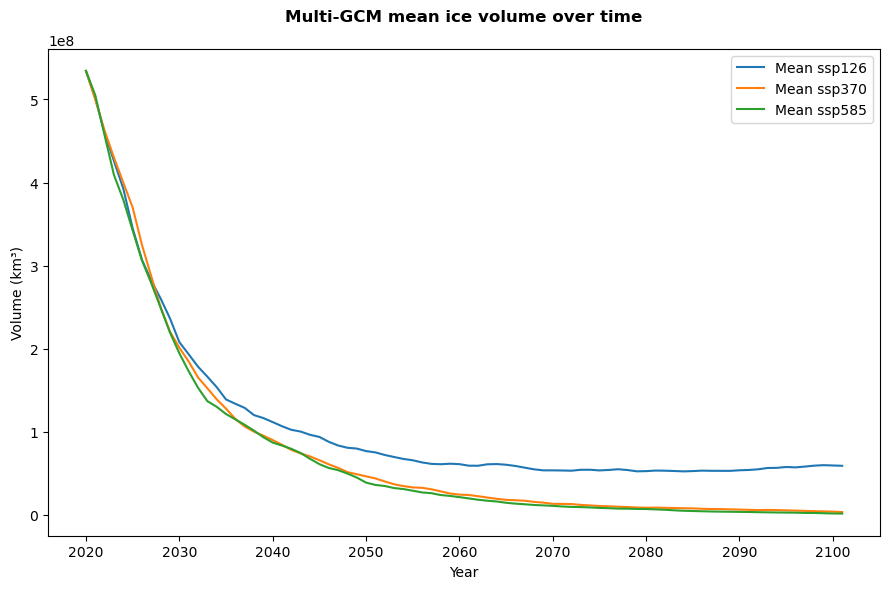

In [37]:
# Plotting the mean volume over time for each SSP
plt.figure(figsize=(9, 6))

# # Customizing the plot with rcParams
# plt.rcParams.update({
#     'font.size': 14,
#     'axes.titlesize': 14,
#     'axes.labelsize': 14,
#     'xtick.labelsize': 12,
#     'ytick.labelsize': 12,
#     'legend.fontsize': 14,
#     'figure.titlesize': 20,
#     'grid.color': 'gray',
#     #'grid.linestyle': '--',
#     'grid.linewidth': 0.5
# })

# # Define colors for each SSP
# ssp_colors = {
#     'ssp126': 'blue',
#     'ssp370': 'green',
#     'ssp585': 'dark orange'
# }

for ssp, volume in mean_volume.items():
    years = volume['time'].values
    mean_values = volume.sum(dim='rgi_id').values  # Summing over 'rgi_id' to get total volume
    plt.plot(years, mean_values, label=f'Mean {ssp}', linewidth=1.5)

plt.title('Multi-GCM mean ice volume over time', pad=20, fontweight = 'bold')  # Adjust title position with 'pad'
plt.xlabel('Year')
plt.ylabel('Volume (km³)')
plt.legend()
#plt.grid(True)  #if I want grid
plt.tight_layout()
plt.show()

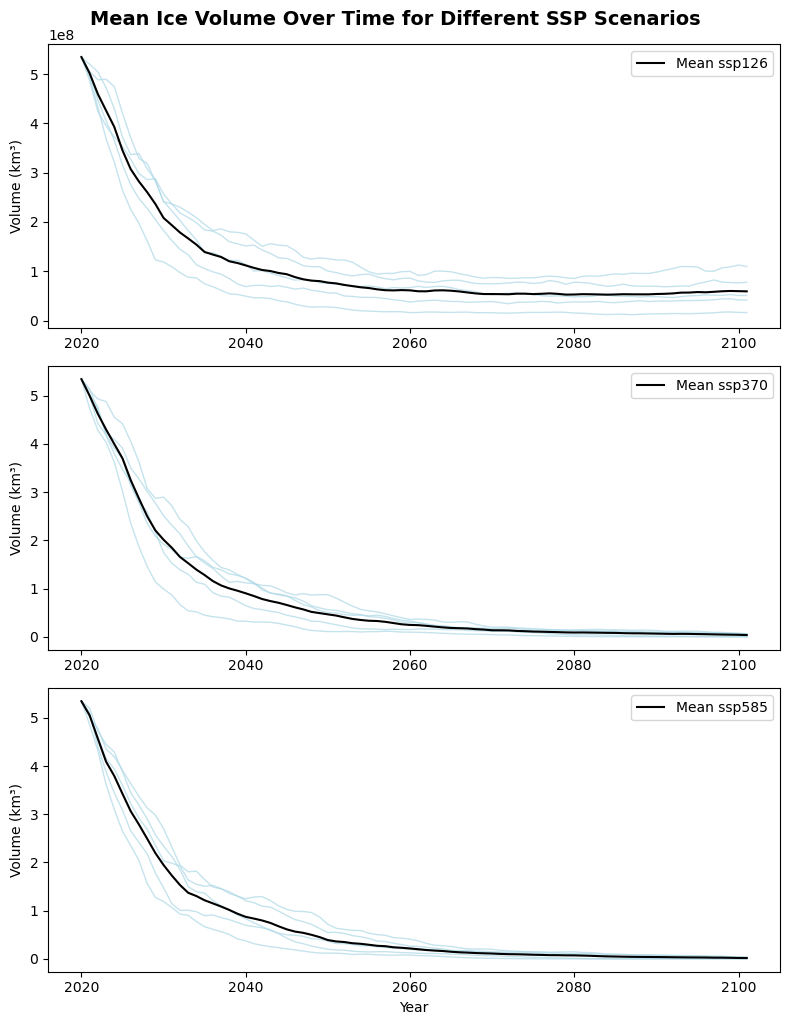

In [38]:
# Function to plot the mean volume over time for each SSP
def plot_mean_volume(mean_volume, ssps):
    plt.figure(figsize=(8, 10))  # Adjusting figure size to accommodate multiple subplots
    
    for idx, ssp in enumerate(ssps):
        ax = plt.subplot(len(ssps), 1, idx + 1)
        
        if idx == 0:  # Top subplot
            ax.yaxis.get_offset_text().set_visible(True)
        else:
            ax.yaxis.get_offset_text().set_visible(False)
    
        ssp_data = [volume for key, volume in mean_volume.items() if ssp in key]
        
        if ssp_data:
            for volume in ssp_data:
                years = volume['time'].values
                values = volume.sum(dim='rgi_id').values  # Summing over 'rgi_id' to get total volume
                ax.plot(years, values, color='lightblue', alpha=0.7, linewidth=1)  # Plot individual GCMs in light blue
                
            combined_volume = xr.concat(ssp_data, dim='gcm').mean(dim='gcm')
            mean_years = combined_volume['time'].values
            mean_values = combined_volume.sum(dim='rgi_id').values  # Summing over 'rgi_id' to get total volume
            ax.plot(mean_years, mean_values, color='black', linewidth=1.5, label=f'Mean {ssp}')  # Plot mean in black
            
        ax.set_ylabel('Volume (km³)')
        ax.legend()
        ax.set_xticks(np.arange(years[0], years[-1] + 1, 20)) # this is how year increments are set
        if idx == len(ssps) - 1:
            ax.set_xlabel('Year')

    plt.suptitle('Mean Ice Volume Over Time for Different SSP Scenarios', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 1.05])  # Adjust layout to accommodate the suptitle
    plt.show()

# Example usage assuming mean_volume and ssp_list are defined
plot_mean_volume(volume_data_dict, ssp_list)

# 4. Data analysis

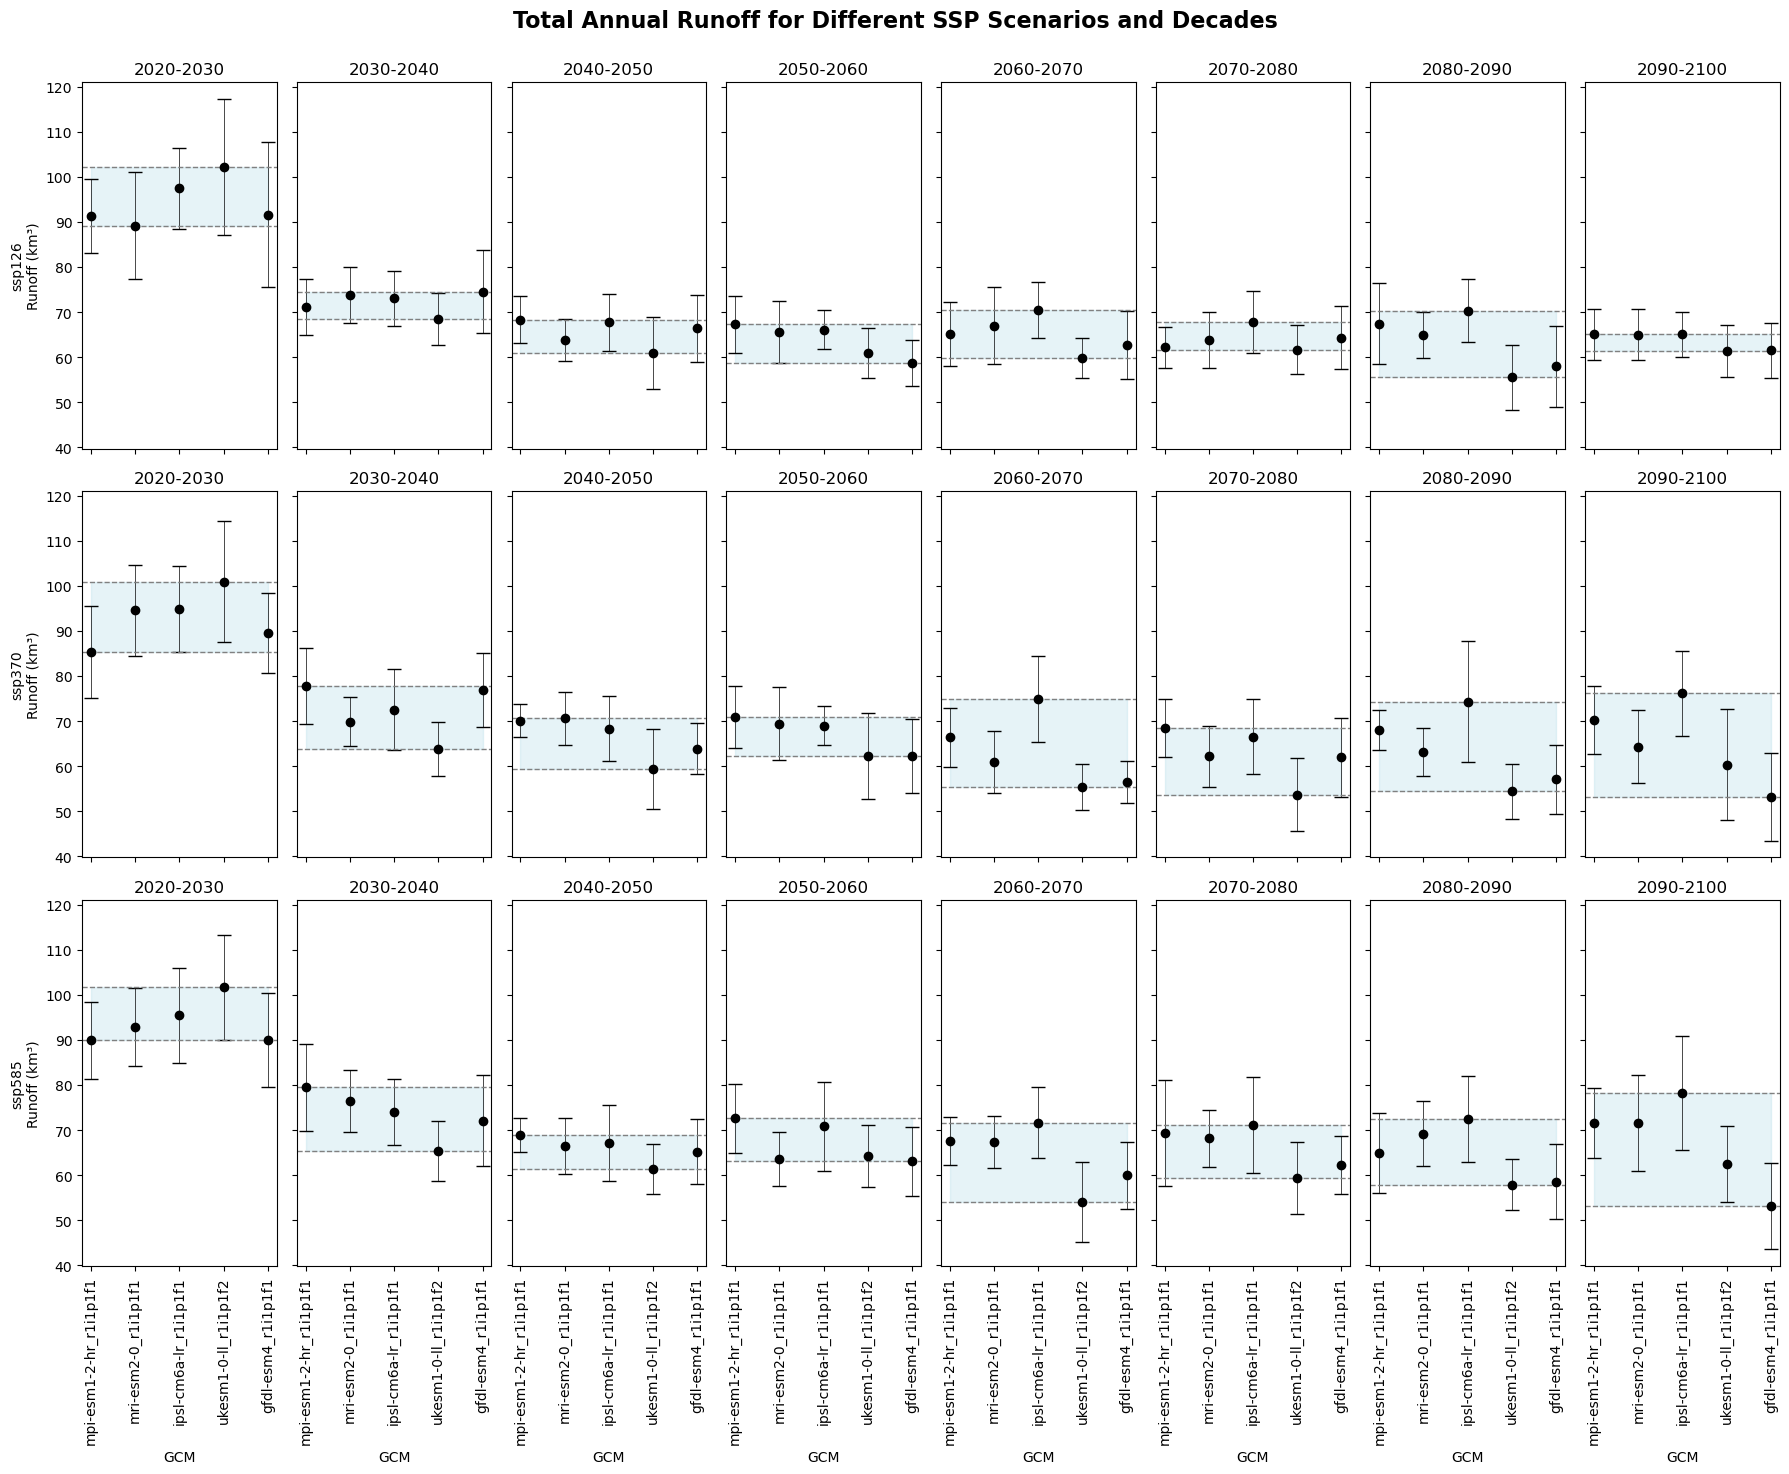

In [21]:
import matplotlib.pyplot as plt

def plot_gcm_statistics_per_decade(total_annual_runoff_dict, ssps, gcms, point_color='black', line_color='black', line_width=0.5):
    decades = [(2020, 2030), (2030, 2040), (2040, 2050), (2050, 2060), (2060, 2070), (2070, 2080), (2080, 2090), (2090, 2100)]
    
    fig, axes = plt.subplots(len(ssps), len(decades), figsize=(18, 15), sharex=True, sharey=True)
    
    for i, ssp in enumerate(ssps):
        ssp_data = {gcm: runoff.sel(time=slice(None, '2101')) for scenario, runoff in total_annual_runoff_dict.items() if ssp in scenario for gcm in gcms if gcm in scenario}
        
        for j, (start, end) in enumerate(decades):
            ax = axes[i, j]
            # Calculate summary statistics for each GCM within the decade
            gcm_stats = {}
            for gcm, runoff in ssp_data.items():
                decade_runoff = runoff.sel(time=slice(str(start), str(end)))
                mean_runoff, std_dev_runoff = calculate_summary_statistics(decade_runoff)
                gcm_stats[gcm] = {'mean': mean_runoff.values, 'std_dev': std_dev_runoff.values}
            
            # Plotting the statistics for the decade
            gcm_names = list(gcm_stats.keys())
            means = [gcm_stats[gcm]['mean'] for gcm in gcm_names]
            std_devs = [gcm_stats[gcm]['std_dev'] for gcm in gcm_names]

            ax.errorbar(gcm_names, means, yerr=std_devs, fmt='o', capsize=5, capthick=1, elinewidth=line_width, markerfacecolor=point_color, markeredgecolor=point_color, ecolor=line_color, label='GCM Runoff')
            
           # ax.errorbar(gcm_names, means, yerr=std_devs, fmt='o', capsize=5, capthick=2, elinewidth=1, label='GCM Runoff')
            ax.set_title(f'{start}-{end}')
            if i == len(ssps) - 1:
                ax.set_xlabel('GCM')
            if j == 0:
                ax.set_ylabel(f'{ssp}\nRunoff (km³)')
            ax.tick_params(axis='x', rotation=90)
            
            # Find the GCM with the lowest and highest mean runoff
            gcm_means = {gcm: stats['mean'] for gcm, stats in gcm_stats.items()}
            min_gcm = min(gcm_means, key=gcm_means.get)
            max_gcm = max(gcm_means, key=gcm_means.get)
            min_mean = gcm_means[min_gcm]
            max_mean = gcm_means[max_gcm]
            
            # Add dashed horizontal lines for lowest and highest GCM
            ax.axhline(y=min_mean, color='gray', linestyle='--', linewidth=1)
            ax.axhline(y=max_mean, color='gray', linestyle='--', linewidth=1)
            
            # Add light blue fill between the lines
            ax.fill_between(gcm_names, min_mean, max_mean, color='lightblue', alpha=0.3)
    
    plt.suptitle('Total Annual Runoff for Different SSP Scenarios and Decades', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# Assuming total_annual_runoff_dict, ssp_list, and gcm_list are already defined
plot_gcm_statistics_per_decade(total_annual_runoff_dict, ssp_list, gcm_list, point_color='black', line_color='black', line_width=0.5)

In [19]:
# Comparison of SSPs
def calculate_summary_statistics(data_array):
    """Calculate mean and standard deviation for a DataArray."""
    mean = data_array.mean(dim='time')
    std_dev = data_array.std(dim='time')
    return mean, std_dev

def calculate_percent_difference(value1, value2):
    """Calculate the percent difference between two values."""
    return (abs(value1 - value2) / ((value1 + value2) / 2)) * 100

def summarize_runoff_statistics(total_annual_runoff_dict, ssps):
    summary_stats = {}
    
    for ssp in ssps:
        ssp_data = [runoff.sel(time=slice(None, '2101')) for scenario, runoff in total_annual_runoff_dict.items() if ssp in scenario]
        if ssp_data:
            combined_runoff = xr.concat(ssp_data, dim='gcm').mean(dim='gcm')
            
            # Calculate summary statistics
            mean_runoff, std_dev_runoff = calculate_summary_statistics(combined_runoff)
            summary_stats[ssp] = {'mean': mean_runoff.values, 'std_dev': std_dev_runoff.values}
    
    # Print summary statistics
    for ssp, stats in summary_stats.items():
        print(f"SSP {ssp}:")
        print(f"  Mean Runoff: {stats['mean']:.2f} km³")
        print(f"  Standard Deviation: {stats['std_dev']:.2f} km³")
        print()
    
    # Calculate percent differences between the mean runoffs
    ssp_combinations = [(ssps[i], ssps[j]) for i in range(len(ssps)) for j in range(i+1, len(ssps))]
    
    for ssp1, ssp2 in ssp_combinations:
        mean1 = summary_stats[ssp1]['mean']
        mean2 = summary_stats[ssp2]['mean']
        percent_diff = calculate_percent_difference(mean1, mean2)
        print(f"Percent difference between SSP {ssp1} and SSP {ssp2}: {percent_diff:.2f}%")

# Assuming total_annual_runoff_dict and ssp_list are already defined
summarize_runoff_statistics(total_annual_runoff_dict, ssp_list)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


SSP ssp126:
  Mean Runoff: 68.86 km³
  Standard Deviation: 10.66 km³

SSP ssp370:
  Mean Runoff: 68.92 km³
  Standard Deviation: 10.27 km³

SSP ssp585:
  Mean Runoff: 70.30 km³
  Standard Deviation: 10.22 km³

Percent difference between SSP ssp126 and SSP ssp370: 0.10%
Percent difference between SSP ssp126 and SSP ssp585: 2.08%
Percent difference between SSP ssp370 and SSP ssp585: 1.98%


In [20]:
# Comparison of SSPs
def calculate_summary_statistics(data_array):
    """Calculate mean and standard deviation for a DataArray."""
    mean = data_array.mean(dim='time')
    std_dev = data_array.std(dim='time')
    return mean, std_dev

def calculate_percent_difference(value1, value2):
    """Calculate the percent difference between two values."""
    return (abs(value1 - value2) / ((value1 + value2) / 2)) * 100

def summarize_runoff_statistics(total_annual_runoff_dict, ssps, decades=None):
    if decades is None:
        decades = [('2020', '2030'), ('2030', '2040'), ('2040', '2050'),
                   ('2050', '2060'), ('2060', '2070'), ('2070', '2080'), ('2080', '2090'), ('2090', '2100')]
    
    summary_stats = {}
    decade_stats = {}
    
    for decade in decades:
        decade_stats[decade] = {}
        for ssp in ssps:
            ssp_data = [runoff.sel(time=slice(decade[0], decade[1])) for scenario, runoff in total_annual_runoff_dict.items() if ssp in scenario]
            
            if ssp_data:
                combined_runoff = xr.concat(ssp_data, dim='gcm').mean(dim='gcm')
                
                # Calculate summary statistics
                mean_runoff, std_dev_runoff = calculate_summary_statistics(combined_runoff)
                decade_stats[decade][ssp] = {'mean': mean_runoff.values.item(), 'std_dev': std_dev_runoff.values.item()}
    
    # Print summary statistics for each decade and SSP
    for decade, stats in decade_stats.items():
        print(f"Decade {decade}:")
        for ssp, values in stats.items():
            print(f"  SSP {ssp}:")
            print(f"    Mean Runoff: {values['mean']:.2f} km³")
            print(f"    Standard Deviation: {values['std_dev']:.2f} km³")
        print()
    
    # Calculate percent differences between SSPs for each decade
    ssp_combinations = [(ssps[i], ssps[j]) for i in range(len(ssps)) for j in range(i+1, len(ssps))]
    
    for decade in decades:
        print(f"Percent differences for Decade {decade}:")
        for ssp1, ssp2 in ssp_combinations:
            mean1 = decade_stats[decade][ssp1]['mean']
            mean2 = decade_stats[decade][ssp2]['mean']
            percent_diff = calculate_percent_difference(mean1, mean2)
            print(f"  Percent difference between SSP {ssp1} and SSP {ssp2}: {percent_diff:.2f}%")
        print()
    
    return decade_stats

# Example usage assuming total_annual_runoff_dict and ssp_list are already defined
decade_stats = summarize_runoff_statistics(total_annual_runoff_dict, ssp_list)


Decade ('2020', '2030'):
  SSP ssp126:
    Mean Runoff: 94.34 km³
    Standard Deviation: 6.46 km³
  SSP ssp370:
    Mean Runoff: 93.03 km³
    Standard Deviation: 5.57 km³
  SSP ssp585:
    Mean Runoff: 93.94 km³
    Standard Deviation: 5.06 km³

Decade ('2030', '2040'):
  SSP ssp126:
    Mean Runoff: 72.20 km³
    Standard Deviation: 3.79 km³
  SSP ssp370:
    Mean Runoff: 72.16 km³
    Standard Deviation: 3.30 km³
  SSP ssp585:
    Mean Runoff: 73.46 km³
    Standard Deviation: 5.46 km³

Decade ('2040', '2050'):
  SSP ssp126:
    Mean Runoff: 65.45 km³
    Standard Deviation: 3.02 km³
  SSP ssp370:
    Mean Runoff: 66.46 km³
    Standard Deviation: 3.63 km³
  SSP ssp585:
    Mean Runoff: 65.83 km³
    Standard Deviation: 1.96 km³

Decade ('2050', '2060'):
  SSP ssp126:
    Mean Runoff: 63.72 km³
    Standard Deviation: 2.79 km³
  SSP ssp370:
    Mean Runoff: 66.74 km³
    Standard Deviation: 3.18 km³
  SSP ssp585:
    Mean Runoff: 66.86 km³
    Standard Deviation: 2.57 km³

Decade (

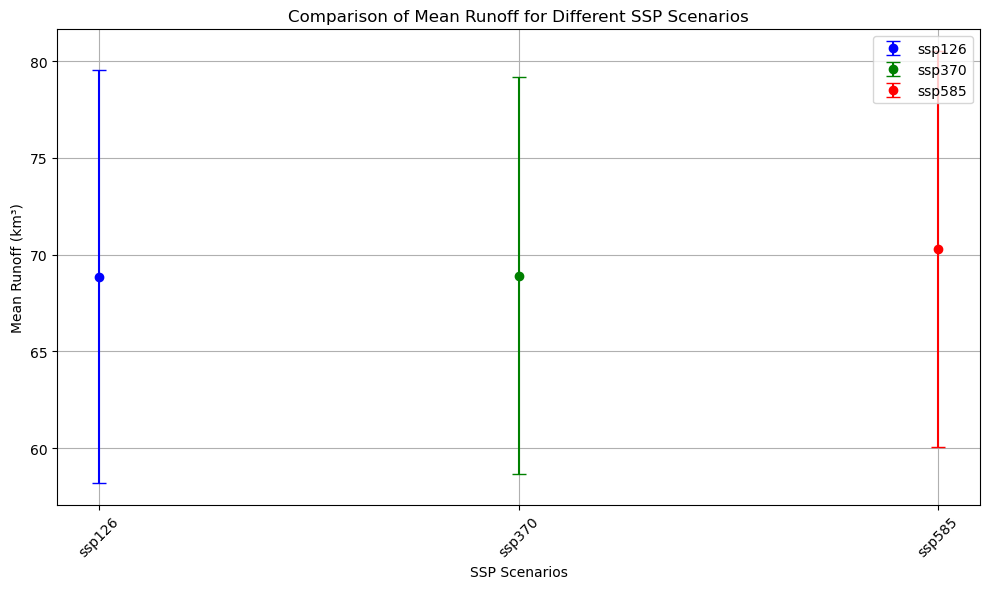

In [41]:
import matplotlib.pyplot as plt

# Example summary_stats (replace with your actual data)
summary_stats = {
    'ssp126': {'mean': 68.86, 'std_dev': 10.66},
    'ssp370': {'mean': 68.92, 'std_dev': 10.27},
    'ssp585': {'mean': 70.3, 'std_dev': 10.22}
}

# Example ssp_list (replace with your actual SSP scenarios)
ssp_list = ['ssp126', 'ssp370', 'ssp585']

def plot_summary_statistics(summary_stats, ssps):
    plt.figure(figsize=(10, 6))
    
    colors = ['blue', 'green', 'red']  # Define colors for each SSP
    
    for idx, ssp in enumerate(ssps):
        mean_runoff = summary_stats[ssp]['mean']
        std_dev_runoff = summary_stats[ssp]['std_dev']
        
        # Plot mean runoff with error bars for standard deviation
        plt.errorbar(ssp, mean_runoff, yerr=std_dev_runoff, fmt='o', color=colors[idx], label=f'{ssp}', capsize=5)
    
    plt.title('Comparison of Mean Runoff for Different SSP Scenarios')
    plt.xlabel('SSP Scenarios')
    plt.ylabel('Mean Runoff (km³)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function with actual data
plot_summary_statistics(summary_stats, ssp_list)


In [42]:
# Statistical summary comparing GCMs for every SSP

import numpy as np

def summarize_gcm_statistics(total_annual_runoff_dict, ssps, gcms):
    for ssp in ssps:
        print(f"\nSSP {ssp} GCM Comparison:")
        ssp_data = {gcm: runoff.sel(time=slice(None, '2101')) for scenario, runoff in total_annual_runoff_dict.items() if ssp in scenario for gcm in gcms if gcm in scenario}
        
        # Calculate summary statistics for each GCM
        gcm_stats = {}
        for gcm, runoff in ssp_data.items():
            mean_runoff, std_dev_runoff = calculate_summary_statistics(runoff)
            gcm_stats[gcm] = {'mean': mean_runoff.values, 'std_dev': std_dev_runoff.values}
            print(f"GCM {gcm}:")
            print(f"  Mean Runoff: {mean_runoff.values:.2f} km³")
            print(f"  Standard Deviation: {std_dev_runoff.values:.2f} km³")
            print()

        # Find the GCM with the lowest and highest mean runoff
        gcm_means = {gcm: stats['mean'] for gcm, stats in gcm_stats.items()}
        min_gcm = min(gcm_means, key=gcm_means.get)
        max_gcm = max(gcm_means, key=gcm_means.get)
        min_mean = gcm_means[min_gcm]
        max_mean = gcm_means[max_gcm]

        # Calculate the percent difference between the lowest and highest mean runoffs
        percent_diff = calculate_percent_difference(min_mean, max_mean)
        print(f"Percent difference between the lowest-value GCM ({min_gcm}) and the highest-value GCM ({max_gcm}): {percent_diff:.2f}%")

# Assuming total_annual_runoff_dict, ssp_list, and gcm_list are already defined
summarize_gcm_statistics(total_annual_runoff_dict, ssp_list, gcm_list)




SSP ssp126 GCM Comparison:
GCM mpi-esm1-2-hr_r1i1p1f1:
  Mean Runoff: 69.61 km³
  Standard Deviation: 10.82 km³

GCM mri-esm2-0_r1i1p1f1:
  Mean Runoff: 69.17 km³
  Standard Deviation: 10.83 km³

GCM ipsl-cm6a-lr_r1i1p1f1:
  Mean Runoff: 72.15 km³
  Standard Deviation: 11.73 km³

GCM ukesm1-0-ll_r1i1p1f2:
  Mean Runoff: 66.23 km³
  Standard Deviation: 15.92 km³

GCM gfdl-esm4_r1i1p1f1:
  Mean Runoff: 67.12 km³
  Standard Deviation: 13.73 km³

Percent difference between the lowest-value GCM (ukesm1-0-ll_r1i1p1f2) and the highest-value GCM (ipsl-cm6a-lr_r1i1p1f1): 8.56%

SSP ssp370 GCM Comparison:
GCM mpi-esm1-2-hr_r1i1p1f1:
  Mean Runoff: 72.05 km³
  Standard Deviation: 9.17 km³

GCM mri-esm2-0_r1i1p1f1:
  Mean Runoff: 69.25 km³
  Standard Deviation: 12.42 km³

GCM ipsl-cm6a-lr_r1i1p1f1:
  Mean Runoff: 74.68 km³
  Standard Deviation: 12.34 km³

GCM ukesm1-0-ll_r1i1p1f2:
  Mean Runoff: 63.70 km³
  Standard Deviation: 17.00 km³

GCM gfdl-esm4_r1i1p1f1:
  Mean Runoff: 64.93 km³
  Standard

In [45]:
import numpy as np

# Define your function to calculate summary statistics
def calculate_summary_statistics(data_array):
    mean = data_array.mean(dim='time')
    std_dev = data_array.std(dim='time')
    return mean, std_dev

# Define your function to calculate percent difference
def calculate_percent_difference(value1, value2):
    return (abs(value1 - value2) / ((value1 + value2) / 2)) * 100

# Define your function to summarize GCM statistics across decades
def summarize_gcm_statistics_decadal(total_annual_runoff_dict, ssps, gcms, decades=None):
    if decades is None:
        decades = [('2020', '2030'), ('2030', '2040'), ('2040', '2050'),
                   ('2050', '2060'), ('2060', '2070'), ('2070', '2080'),
                   ('2080', '2090'), ('2090', '2100')]
    
    for ssp in ssps:
        print(f"\nSSP {ssp} GCM Comparison:")
        
        for decade in decades:
            print(f"\nDecade: {decade[0]}-{decade[1]}")
            ssp_data = {gcm: runoff.sel(time=slice(f'{decade[0]}', f'{decade[1]}')) for scenario, runoff in total_annual_runoff_dict.items() if ssp in scenario for gcm in gcms if gcm in scenario}
            
            if not ssp_data:
                print("No data available for this decade and SSP combination.")
                continue
            
            # Calculate summary statistics for each GCM within the decade
            gcm_stats = {}
            for gcm, runoff in ssp_data.items():
                mean_runoff, std_dev_runoff = calculate_summary_statistics(runoff)
                gcm_stats[gcm] = {'mean': mean_runoff.values.item(), 'std_dev': std_dev_runoff.values.item()}
                print(f"GCM {gcm}:")
                print(f"  Mean Runoff: {mean_runoff.values.item():.2f} km³")
                print(f"  Standard Deviation: {std_dev_runoff.values.item():.2f} km³")
                print()
            
            # Find the GCM with the lowest and highest mean runoff
            gcm_means = {gcm: stats['mean'] for gcm, stats in gcm_stats.items()}
            min_gcm = min(gcm_means, key=gcm_means.get)
            max_gcm = max(gcm_means, key=gcm_means.get)
            min_mean = gcm_means[min_gcm]
            max_mean = gcm_means[max_gcm]
            
            # Calculate the percent difference between the lowest and highest mean runoffs
            percent_diff = calculate_percent_difference(min_mean, max_mean)
            print(f"Percent difference between the lowest-value GCM ({min_gcm}) and the highest-value GCM ({max_gcm}): {percent_diff:.2f}%")
            print()

# Example usage assuming total_annual_runoff_dict, ssp_list, gcm_list, and decades_list are defined
summarize_gcm_statistics_decadal(total_annual_runoff_dict, ssp_list, gcm_list, decades_list)



NameError: name 'decades_list' is not defined

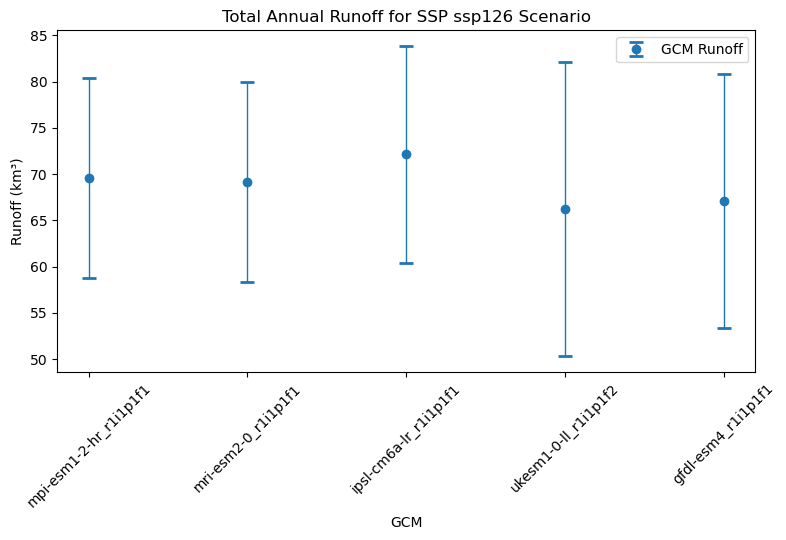

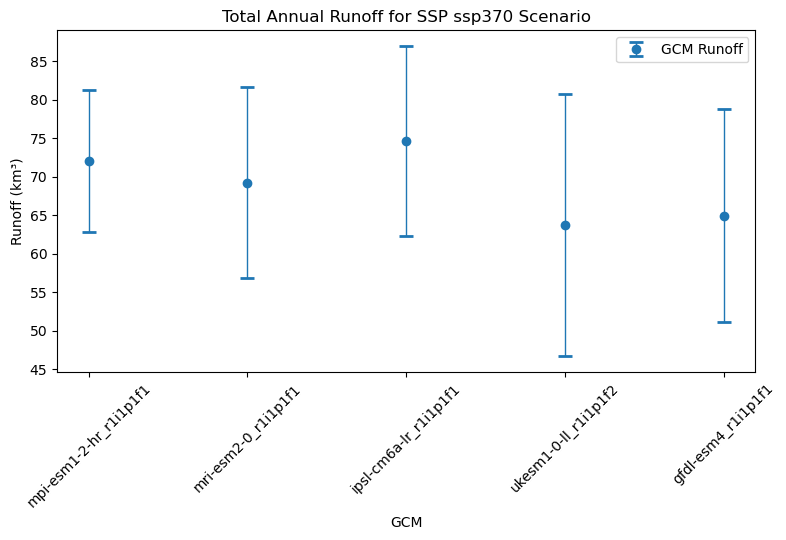

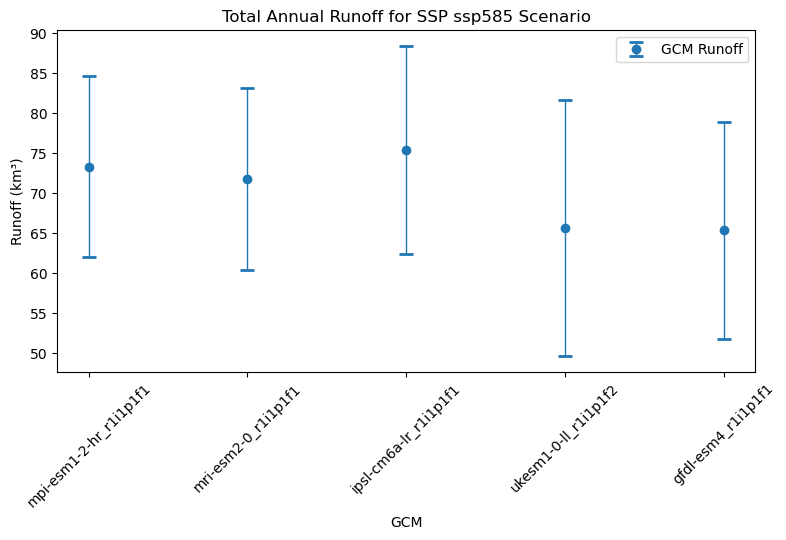

In [42]:
import matplotlib.pyplot as plt

def plot_gcm_statistics(total_annual_runoff_dict, ssps, gcms):
    for ssp in ssps:
        ssp_data = {gcm: runoff.sel(time=slice(None, '2101')) for scenario, runoff in total_annual_runoff_dict.items() if ssp in scenario for gcm in gcms if gcm in scenario}
        
        # Calculate summary statistics for each GCM
        gcm_stats = {}
        for gcm, runoff in ssp_data.items():
            mean_runoff, std_dev_runoff = calculate_summary_statistics(runoff)
            gcm_stats[gcm] = {'mean': mean_runoff.values, 'std_dev': std_dev_runoff.values}
        
        # Plotting the statistics
        plt.figure(figsize=(8, 5.5))
        gcm_names = list(gcm_stats.keys())
        means = [gcm_stats[gcm]['mean'] for gcm in gcm_names]
        std_devs = [gcm_stats[gcm]['std_dev'] for gcm in gcm_names]
        
        plt.errorbar(gcm_names, means, yerr=std_devs, fmt='o', capsize=5, capthick=2, elinewidth=1, label='GCM Runoff')
        plt.xticks(rotation=45)
        plt.title(f'Total Annual Runoff for SSP {ssp} Scenario')
        plt.xlabel('GCM')
        plt.ylabel('Runoff (km³)')
        plt.legend()
        plt.tight_layout()
        plt.show()

# Assuming total_annual_runoff_dict, ssp_list, and gcm_list are already defined
plot_gcm_statistics(total_annual_runoff_dict, ssp_list, gcm_list)


# Stuff I was trying that didn't work

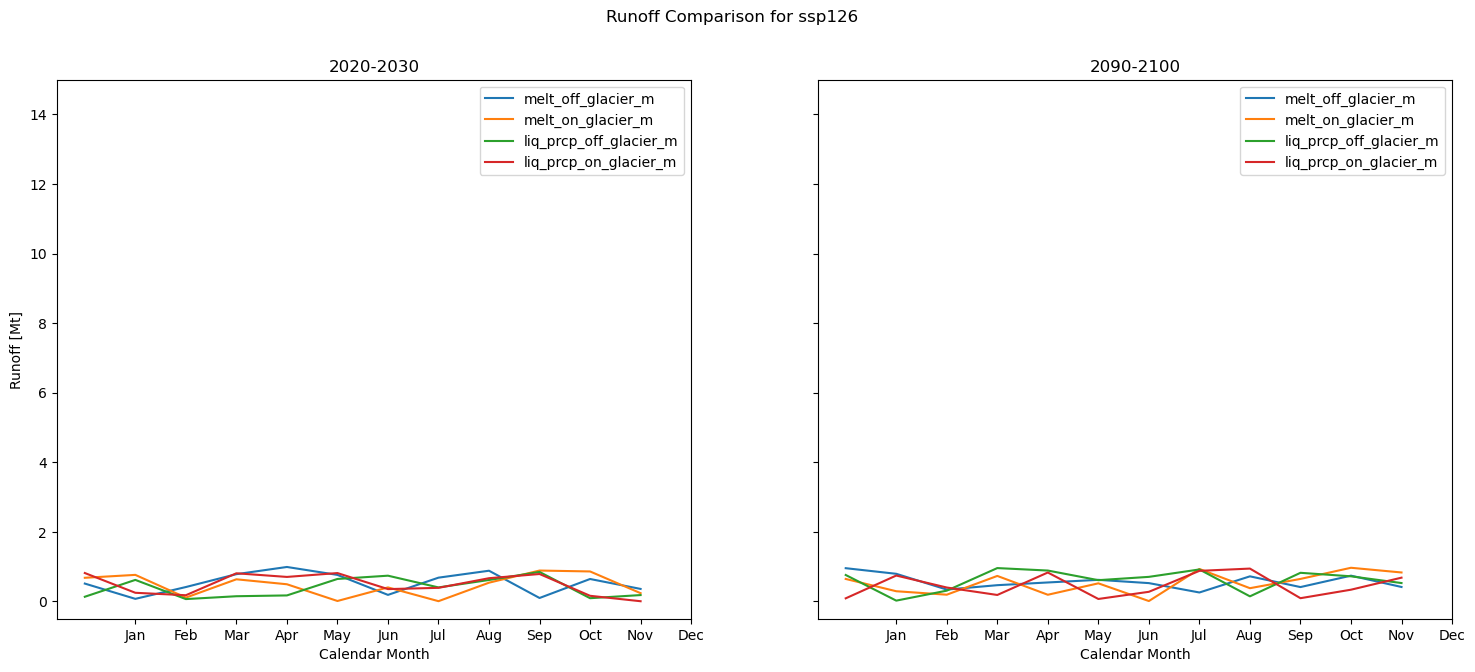

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define function to plot runoff
def plot_runoff(rtype_calc_s, rtype_calc_e, ssp):
    runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
    s_keys = rtype_calc_s.keys()

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
    
    for r in runoff_variables:
        runoff_s = rtype_calc_s[r]
        runoff_e = rtype_calc_e[r]
        ax1.plot(runoff_s.index, runoff_s['mean'], label=r)
        ax2.plot(runoff_e.index, runoff_e['mean'], label=r)

    ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
    ax2.set(title='2090-2100')

    ax1.set_xticks(np.arange(1, 13))
    ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax2.set_xticks(np.arange(1, 13))
    ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

    for ax in (ax1, ax2):
        ax.set_xlabel('Calendar Month')
        ax.legend()

    plt.ylim([-0.5, 15])
    plt.suptitle(f'Runoff Comparison for {ssp}')
    plt.show()

# Sample data structure (replace with actual data)
rtype_calc_s = {
    'melt_off_glacier_m': pd.DataFrame({'mean': np.random.rand(12)}),
    'melt_on_glacier_m': pd.DataFrame({'mean': np.random.rand(12)}),
    'liq_prcp_off_glacier_m': pd.DataFrame({'mean': np.random.rand(12)}),
    'liq_prcp_on_glacier_m': pd.DataFrame({'mean': np.random.rand(12)})
}

rtype_calc_e = {
    'melt_off_glacier_m': pd.DataFrame({'mean': np.random.rand(12)}),
    'melt_on_glacier_m': pd.DataFrame({'mean': np.random.rand(12)}),
    'liq_prcp_off_glacier_m': pd.DataFrame({'mean': np.random.rand(12)}),
    'liq_prcp_on_glacier_m': pd.DataFrame({'mean': np.random.rand(12)})
}

# SSP label
ssp = 'ssp126'

# Call function to plot runoff
plot_runoff(rtype_calc_s, rtype_calc_e, ssp)


## some seasonal runoff plots; nearly there, might need gpt4

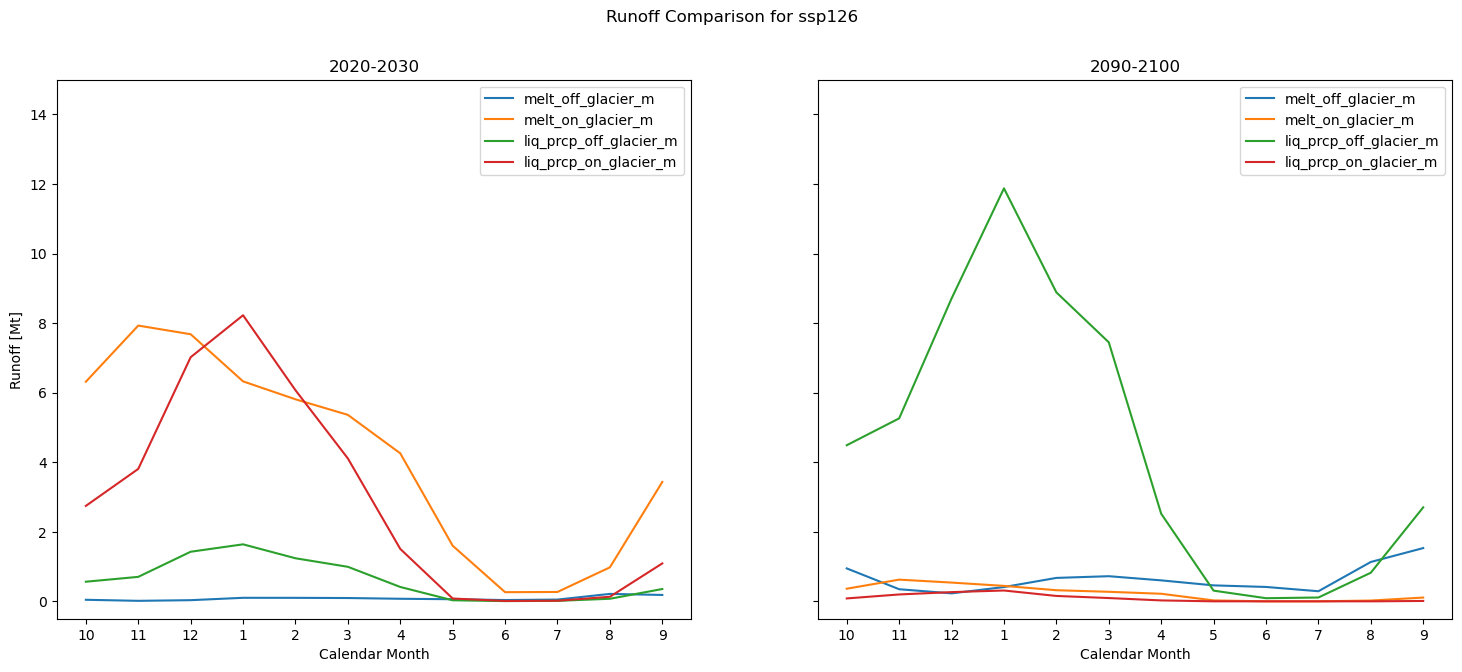

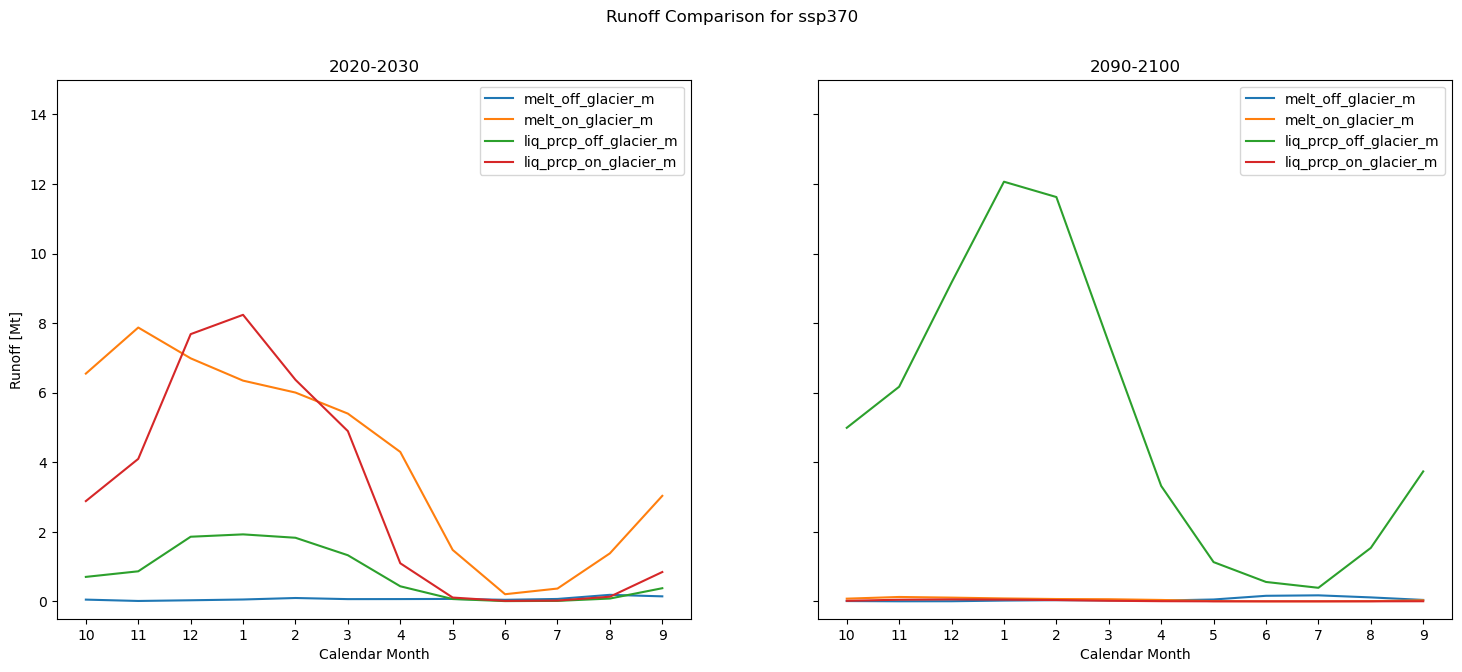

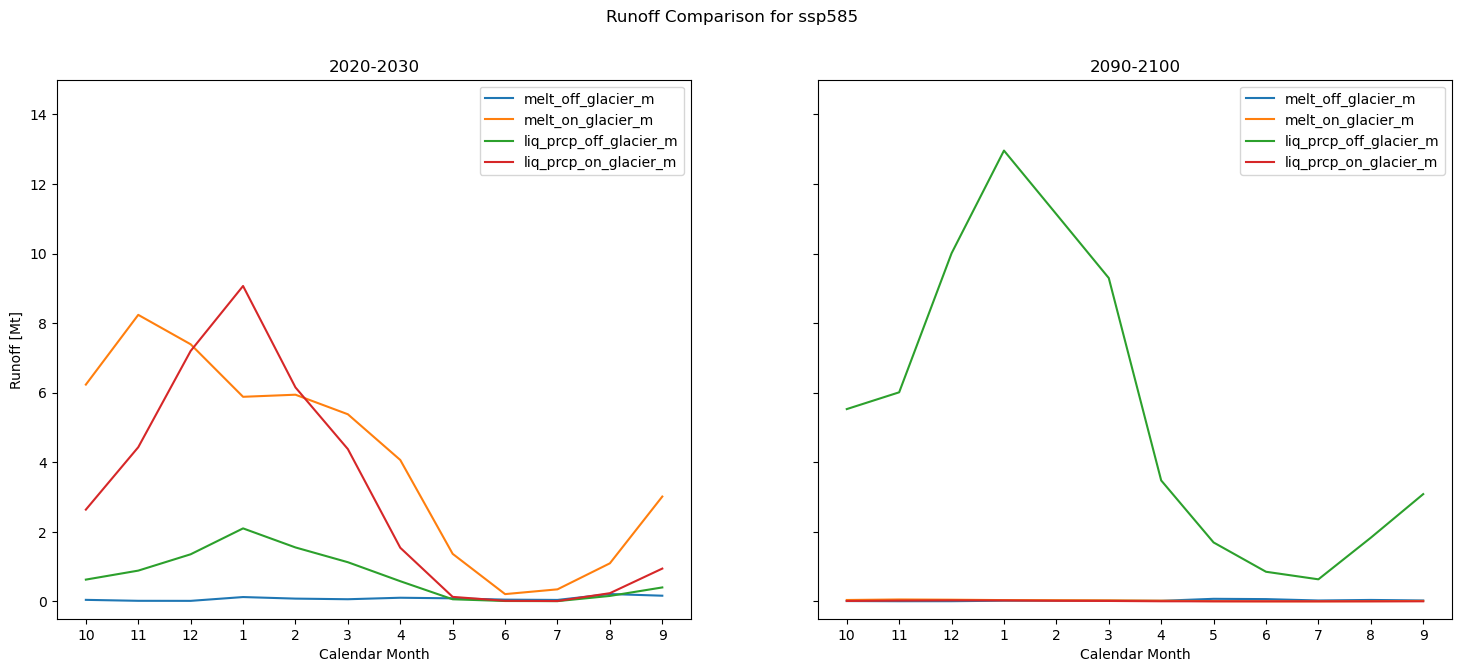

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


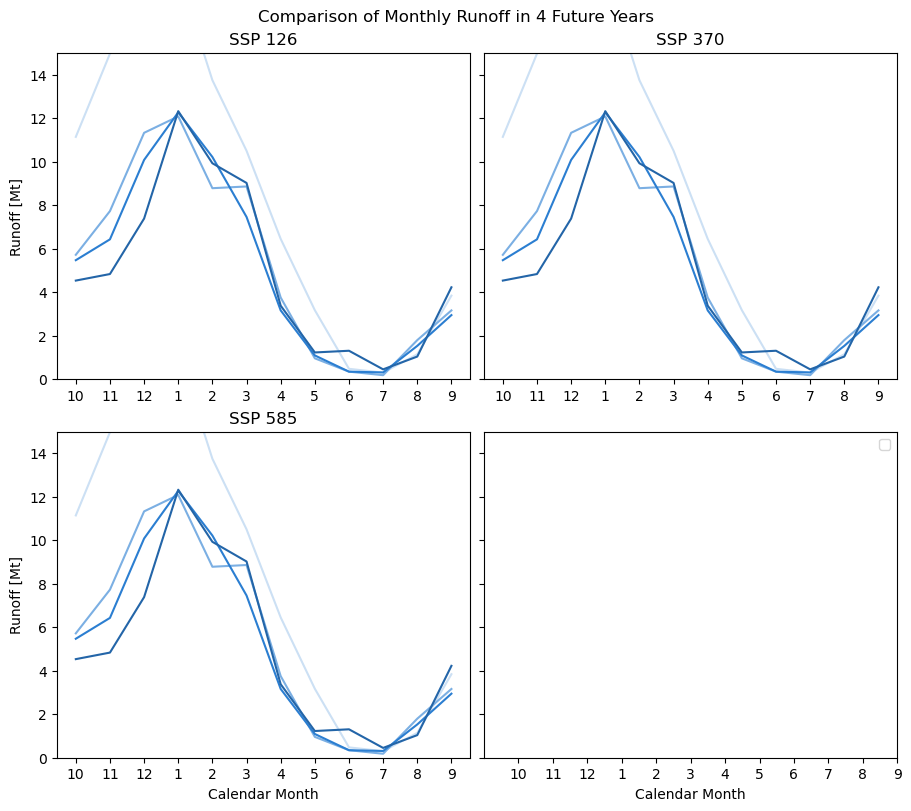

In [44]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import os

# Function to load the dataset
def open_series(fpath_stem, which_date, which_gcm, which_ssp):
    this_fpath = os.path.expanduser(fpath_stem + '{}-gcm_data_{}_{}_compiled_output.nc'.format(which_date, which_gcm, which_ssp))
    return xr.open_dataset(this_fpath)

# Calculate seasonal runoff
def calc_seasonal(this_ds):
    melt1 = this_ds.melt_on_glacier_monthly
    melt2 = this_ds.melt_off_glacier_monthly
    melt3 = this_ds.liq_prcp_off_glacier_monthly
    melt4 = this_ds.liq_prcp_on_glacier_monthly
    
    this_sum = melt1.sum(dim='rgi_id').dropna(dim='time') + melt2.sum(dim='rgi_id').dropna(dim='time') + melt3.sum(dim='rgi_id').dropna(dim='time') + melt4.sum(dim='rgi_id').dropna(dim='time')
    nonzero_sum = this_sum.where(this_sum != 0, drop=True)
    nonzero_sum *= 1e-9
    
    return nonzero_sum

# Select a year and take the mean runoff of all GCMs for this year
def season_sliced(keys, dictionary, time):
    new_df = pd.DataFrame()
    for k in keys:
        new = dictionary[k]
        new = new.isel(time=time)
        new = pd.DataFrame(new)
        new_df[k] = new
        new_df['mean'] = new_df.transpose().mean()
    return new_df

# Calculate monthly runoff for a given runoff value
def rtype_calc_monthly(keys, dictionary, runoff):
    dataframe = pd.DataFrame()
    for k in keys:
        rtype_gcm = dictionary[k]
        rtype = rtype_gcm[runoff]
        rtype = pd.DataFrame(rtype)
        dataframe[k] = rtype
        dataframe['mean'] = dataframe.transpose().mean()
    return dataframe

# Function to calculate and visualize runoff
def plot_runoff(rtype_calc_s, rtype_calc_e, index2, ssp, season_roll, season_roll2):
    runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
    s_keys = rtype_calc_s.keys()
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
    
    for r in runoff_variables:
        runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s, r)
        runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e, r)
        ax1.plot(index2, runoff_s['mean'], label=r)
        ax2.plot(index2, runoff_e['mean'], label=r)
    
    ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
    ax2.set(title='2090-2100')
    
    for ax in (ax1, ax2):
        ax.set(xticks=season_roll['month_2d'].values,
               xticklabels=season_roll2['month_2d'].values,
               xlabel='Calendar Month')
        ax.legend()
    
    plt.ylim([-0.5, 15])
    plt.suptitle(f'Runoff Comparison for {ssp}')
    plt.show()

# Define variables
base = '/Users/ziggygoddard/Documents/summer24/'
gcm_list = ['gfdl-esm4_r1i1p1f1', 'mpi-esm1-2-hr_r1i1p1f1', 'mri-esm2-0_r1i1p1f1',
            'ipsl-cm6a-lr_r1i1p1f1', 'ukesm1-0-ll_r1i1p1f2']
date_list = ['2024-06-12', '2024-06-17']
ssp_list = ['ssp126', 'ssp370', 'ssp585']
n_roll = 3

# Load datasets and calculate seasonal values
all_monthly_dict = {}
season_unroll = {}
for gcm in gcm_list:
    for date in date_list:
        for ssp in ssp_list:
            filepath = base + '{}-gcm_data_{}_{}_compiled_output.nc'.format(date, gcm, ssp)
            if os.path.exists(filepath):
                ssp_value = open_series(fpath_stem=base, which_date=date, which_gcm=gcm, which_ssp=ssp)
                k = '{}-{}'.format(gcm, ssp)
                all_monthly_dict[k] = ssp_value
                season_unroll[k] = calc_seasonal(ssp_value)

# Rolling and summing values
dict_roll = {}
rtype_roll = {}
rtype_calc_s = {}
rtype_calc_e = {}

for k in season_unroll.keys():
    season_roll = season_unroll[k].roll(month_2d=n_roll, roll_coords=False)
    dict_roll[k] = season_roll
    rtype_season = all_monthly_dict[k].roll(month_2d=n_roll, roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_roll[k] = rtype_sum
    
    df_key = rtype_roll[k]
    df_m_s = df_key.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
    df_m_s.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
    df_m_s = df_m_s.clip(0)
    rtype_calc_s[k] = df_m_s
    
    df_m_e = df_key.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
    df_m_e.columns = [c.replace('_monthly', '_m') for c in df_m_e.columns]
    df_m_e = df_m_e.clip(0)
    rtype_calc_e[k] = df_m_e

# Plotting for each SSP
for ssp in ssp_list:
    ssp_keys = [key for key in season_unroll.keys() if ssp in key]
    season_roll2 = season_unroll[ssp_keys[0]].roll(month_2d=n_roll, roll_coords=True)
    index1 = season_unroll[ssp_keys[0]]
    index2 = index1['month_2d']
    
    plot_runoff({k: v for k, v in rtype_calc_s.items() if ssp in k}, 
                {k: v for k, v in rtype_calc_e.items() if ssp in k}, 
                index2, ssp, season_roll, season_roll2)

# Define keys for each SSP
key_dict = {
    'ssp126': list(season_unroll.keys()),
    'ssp370': list(season_unroll.keys()),
    'ssp585': list(season_unroll.keys())
}

# Plot mean seasonal runoff for four selected years
time = [0, 20, 40, 80]
color_ts = ['#cce0f4', '#7bafe3', '#2b7ed1', '#2365a8']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 8), sharey=True, constrained_layout=True)

t_idx = 0
for t in time:
    season_t = season_sliced(key_dict['ssp126'], dict_roll, t)
    xvals = np.asarray(season_t.index) + 1
    ax1.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx += 1

t_idx = 0
for t in time:
    season_t = season_sliced(key_dict['ssp370'], dict_roll, t)
    xvals = np.asarray(season_t.index) + 1
    ax2.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx += 1

t_idx = 0
for t in time:
    season_t = season_sliced(key_dict['ssp585'], dict_roll, t)
    xvals = np.asarray(season_t.index) + 1
    ax3.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx += 1

ax1.set(xticks=season_roll['month_2d'].values,
        xticklabels=season_roll2['month_2d'].values,
        title='SSP 126',
        ylabel='Runoff [Mt]')
ax2.set(xticks=season_roll['month_2d'].values,
        xticklabels=season_roll2['month_2d'].values,
        title='SSP 370')
ax3.set(xticks=season_roll['month_2d'].values,
        xticklabels=season_roll2['month_2d'].values,
        title='SSP 585',
        ylabel='Runoff [Mt]',
        xlabel='Calendar Month')
ax4.set(xticks=season_roll['month_2d'].values,
        xticklabels=season_roll2['month_2d'].values,
        xlabel='Calendar Month')

plt.ylim([0, 15])
plt.suptitle('Comparison of Monthly Runoff in 4 Future Years')
plt.legend()
plt.show()

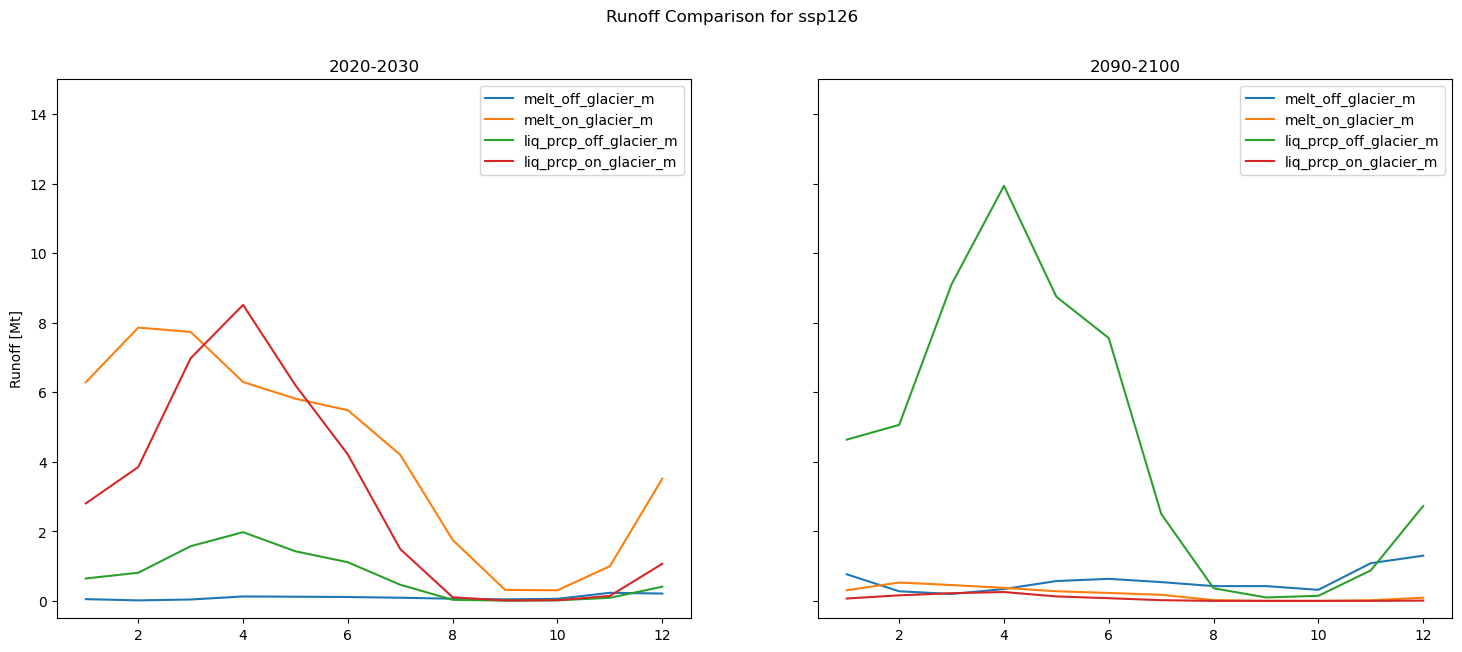

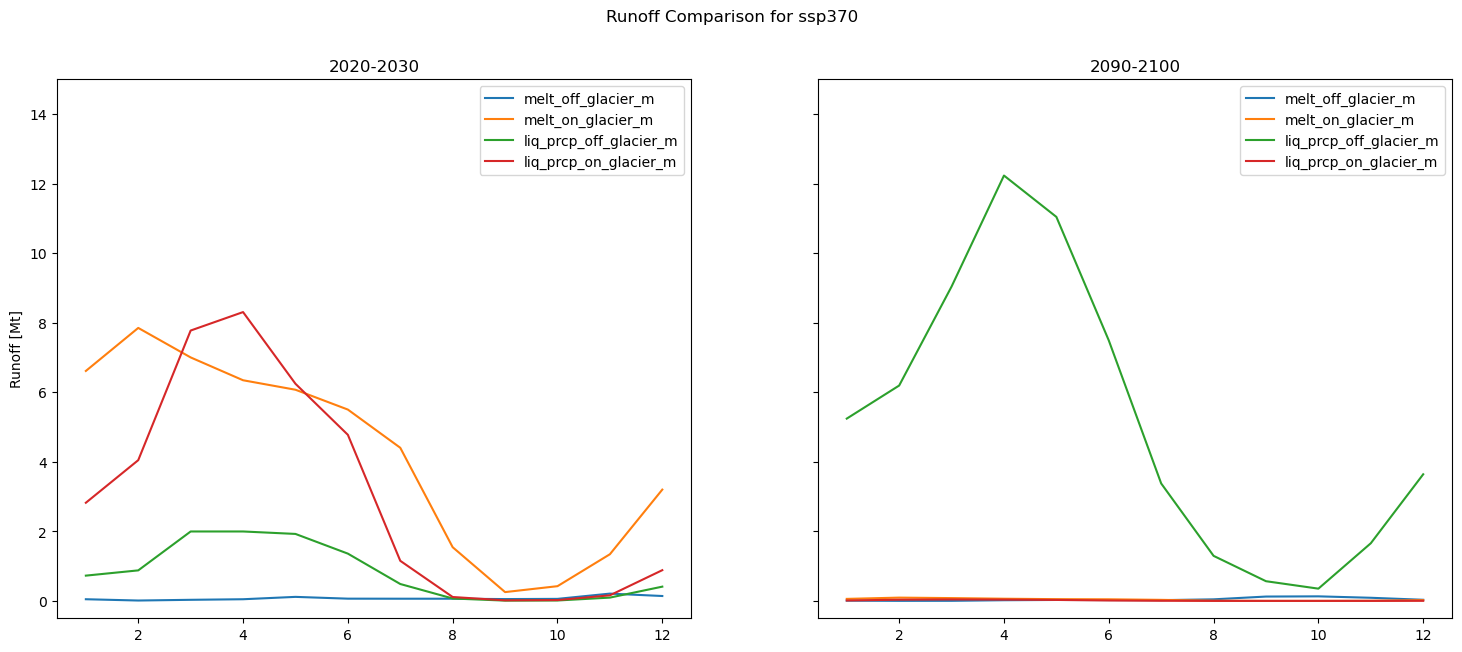

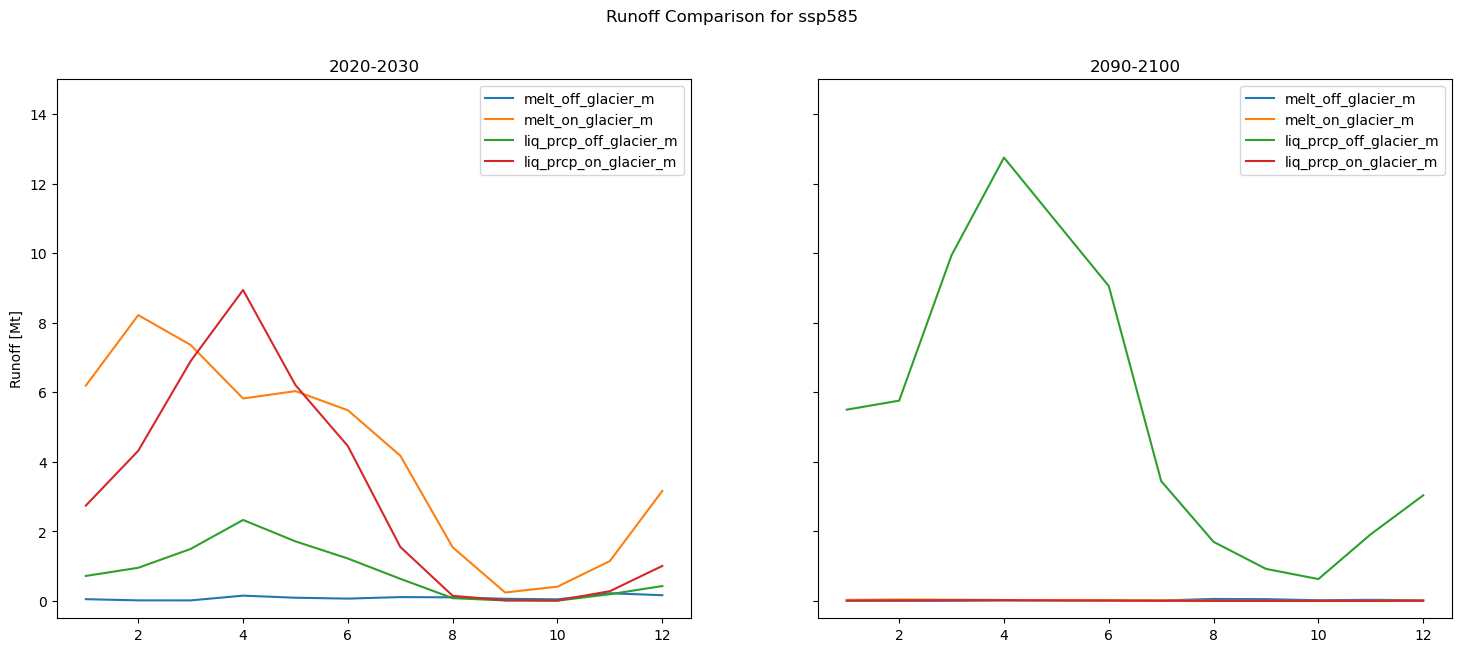

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


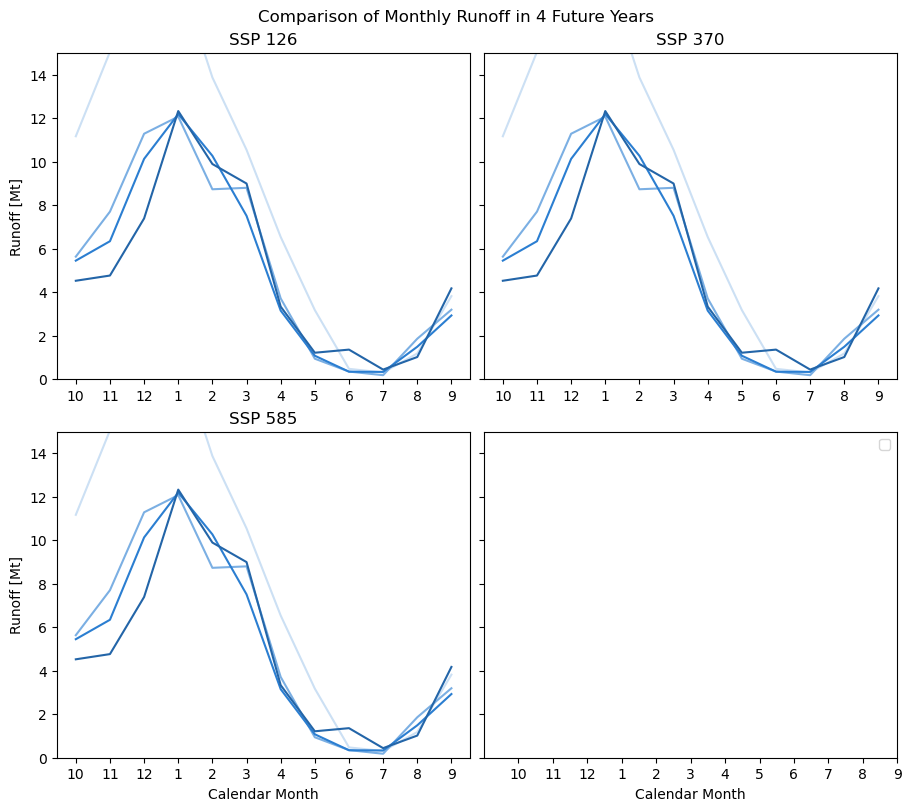

In [45]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import os

# Function to load the dataset
def open_series(fpath_stem, which_date, which_gcm, which_ssp):
    this_fpath = os.path.expanduser(fpath_stem + '{}-gcm_data_{}_{}_compiled_output.nc'.format(which_date, which_gcm, which_ssp))
    return xr.open_dataset(this_fpath)

# Calculate seasonal runoff
def calc_seasonal(this_ds):
    melt1 = this_ds.melt_on_glacier_monthly
    melt2 = this_ds.melt_off_glacier_monthly
    melt3 = this_ds.liq_prcp_off_glacier_monthly
    melt4 = this_ds.liq_prcp_on_glacier_monthly
    
    this_sum = melt1.sum(dim='rgi_id').dropna(dim='time') + melt2.sum(dim='rgi_id').dropna(dim='time') + melt3.sum(dim='rgi_id').dropna(dim='time') + melt4.sum(dim='rgi_id').dropna(dim='time')
    nonzero_sum = this_sum.where(this_sum != 0, drop=True)
    nonzero_sum *= 1e-9
    
    return nonzero_sum

# Select a year and take the mean runoff of all GCMs for this year
# Correcting the season_sliced function to ensure 'mean' key is calculated
def season_sliced(keys, dictionary, time):
    new_df = pd.DataFrame()
    for k in keys:
        new = dictionary[k]
        new = new.isel(time=time)
        new = pd.DataFrame(new)
        new_df[k] = new
    new_df['mean'] = new_df.mean(axis=1)
    return new_df

# Calculate monthly runoff for a given runoff value
def rtype_calc_monthly(keys, dictionary, runoff):
    dataframe = pd.DataFrame()
    for k in keys:
        rtype_gcm = dictionary[k]
        if runoff in rtype_gcm:
            rtype = rtype_gcm[runoff]
            rtype = pd.DataFrame(rtype)
            dataframe[k] = rtype
    if not dataframe.empty:
        dataframe['mean'] = dataframe.mean(axis=1)
    return dataframe

# Use the rtype_calc_monthly function correctly
def rtype_calc_monthly(keys, dictionary, runoff):
    dataframe = pd.DataFrame()
    for k in keys:
        rtype_gcm = dictionary[k]
        rtype = rtype_gcm[runoff]
        rtype = pd.DataFrame(rtype)
        dataframe[k] = rtype
    dataframe['mean'] = dataframe.mean(axis=1)
    return dataframe

# Function to calculate and visualize runoff
# Correcting the plot_runoff function
def plot_runoff(rtype_calc_s, rtype_calc_e, index2, ssp, season_roll, season_roll2):
    runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
    s_keys = rtype_calc_s.keys()
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
    
    for r in runoff_variables:
        runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s, r)
        runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e, r)
        if not runoff_s.empty and not runoff_e.empty:
            ax1.plot(index2, runoff_s['mean'], label=r)
            ax2.plot(index2, runoff_e['mean'], label=r)
    
    ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
    ax2.set(title='2090-2100')
    
    for ax in (ax1, ax2):
        if 'month_2d' in season_roll and 'month_2d' in season_roll2:
            ax.set(xticks=season_roll['month_2d'].values,
                   xticklabels=season_roll2['month_2d'].values,
                   xlabel='Calendar Month')
        ax.legend()
    
    plt.ylim([-0.5, 15])
    plt.suptitle(f'Runoff Comparison for {ssp}')
    plt.show()


# Define variables
base = '/Users/ziggygoddard/Documents/summer24/'
gcm_list = ['gfdl-esm4_r1i1p1f1', 'mpi-esm1-2-hr_r1i1p1f1', 'mri-esm2-0_r1i1p1f1',
            'ipsl-cm6a-lr_r1i1p1f1', 'ukesm1-0-ll_r1i1p1f2']
date_list = ['2024-06-12', '2024-06-17']
ssp_list = ['ssp126', 'ssp370', 'ssp585']
n_roll = 3

# Load datasets and calculate seasonal values
all_monthly_dict = {}
season_unroll = {}
for gcm in gcm_list:
    for date in date_list:
        for ssp in ssp_list:
            filepath = base + '{}-gcm_data_{}_{}_compiled_output.nc'.format(date, gcm, ssp)
            if os.path.exists(filepath):
                ssp_value = open_series(fpath_stem=base, which_date=date, which_gcm=gcm, which_ssp=ssp)
                k = '{}-{}'.format(gcm, ssp)
                all_monthly_dict[k] = ssp_value
                season_unroll[k] = calc_seasonal(ssp_value)

# Rolling and summing values
dict_roll = {}
rtype_roll = {}
rtype_calc_s = {}
rtype_calc_e = {}

for k in season_unroll.keys():
    season_roll = season_unroll[k].roll(month_2d=n_roll, roll_coords=False)
    dict_roll[k] = season_roll
    rtype_season = all_monthly_dict[k].roll(month_2d=n_roll, roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_roll[k] = rtype_sum
    
    df_key = rtype_roll[k]
    df_m_s = df_key.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
    df_m_s.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
    df_m_s = df_m_s.clip(0)
    rtype_calc_s[k] = df_m_s
    
    df_m_e = df_key.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
    df_m_e.columns = [c.replace('_monthly', '_m') for c in df_m_e.columns]
    df_m_e = df_m_e.clip(0)
    rtype_calc_e[k] = df_m_e

# Plotting for each SSP
for ssp in ssp_list:
    ssp_keys = [key for key in season_unroll.keys() if ssp in key]
    season_roll2 = season_unroll[ssp_keys[0]].roll(month_2d=n_roll, roll_coords=True)
    index1 = season_unroll[ssp_keys[0]]
    index2 = index1['month_2d']
    
    plot_runoff({k: v for k, v in rtype_calc_s.items() if ssp in k}, 
                {k: v for k, v in rtype_calc_e.items() if ssp in k}, 
                index2, ssp, season_roll, season_roll2)

# Define keys for each SSP
key_dict = {
    'ssp126': list(season_unroll.keys()),
    'ssp370': list(season_unroll.keys()),
    'ssp585': list(season_unroll.keys())
}

# Plot mean seasonal runoff for four selected years
time = [0, 20, 40, 80]
color_ts = ['#cce0f4', '#7bafe3', '#2b7ed1', '#2365a8']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 8), sharey=True, constrained_layout=True)

t_idx = 0
for t in time:
    season_t = season_sliced(key_dict['ssp126'], dict_roll, t)
    xvals = np.asarray(season_t.index) + 1
    ax1.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx += 1

t_idx = 0
for t in time:
    season_t = season_sliced(key_dict['ssp370'], dict_roll, t)
    xvals = np.asarray(season_t.index) + 1
    ax2.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx += 1

t_idx = 0
for t in time:
    season_t = season_sliced(key_dict['ssp585'], dict_roll, t)
    xvals = np.asarray(season_t.index) + 1
    ax3.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx += 1

ax1.set(xticks=season_roll['month_2d'].values,
        xticklabels=season_roll2['month_2d'].values,
        title='SSP 126',
        ylabel='Runoff [Mt]')
ax2.set(xticks=season_roll['month_2d'].values,
        xticklabels=season_roll2['month_2d'].values,
        title='SSP 370')
ax3.set(xticks=season_roll['month_2d'].values,
        xticklabels=season_roll2['month_2d'].values,
        title='SSP 585',
        ylabel='Runoff [Mt]',
        xlabel='Calendar Month')
ax4.set(xticks=season_roll['month_2d'].values,
        xticklabels=season_roll2['month_2d'].values,
        xlabel='Calendar Month')

plt.ylim([0, 15])
plt.suptitle('Comparison of Monthly Runoff in 4 Future Years')
plt.legend()
plt.show()

In [46]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import os

# Function to load the dataset
def open_series(fpath_stem, which_date, which_gcm, which_ssp):
    this_fpath = os.path.expanduser(fpath_stem + '{}-gcm_data_{}_{}_compiled_output.nc'.format(which_date, which_gcm, which_ssp))
    return xr.open_dataset(this_fpath)

# Calculate seasonal runoff
def calc_seasonal(this_ds):
    melt1 = this_ds.melt_on_glacier_monthly
    melt2 = this_ds.melt_off_glacier_monthly
    melt3 = this_ds.liq_prcp_off_glacier_monthly
    melt4 = this_ds.liq_prcp_on_glacier_monthly
    
    this_sum = melt1.sum(dim='rgi_id').dropna(dim='time') + melt2.sum(dim='rgi_id').dropna(dim='time') + melt3.sum(dim='rgi_id').dropna(dim='time') + melt4.sum(dim='rgi_id').dropna(dim='time')
    nonzero_sum = this_sum.where(this_sum != 0, drop=True)
    nonzero_sum *= 1e-9
    
    return nonzero_sum

# Select a year and take the mean runoff of all GCMs for this year
def season_sliced(keys, dictionary, time):
    new_df = pd.DataFrame()
    for k in keys:
        new = dictionary[k]
        if time < len(new.time):  # Ensure time index is valid
            new = new.isel(time=time)
            new = pd.DataFrame(new)
            new_df[k] = new
    if not new_df.empty:
        new_df['mean'] = new_df.mean(axis=1)
    return new_df

# Calculate monthly runoff for a given runoff value
def rtype_calc_monthly(keys, dictionary, runoff):
    dataframe = pd.DataFrame()
    for k in keys:
        rtype_gcm = dictionary[k]
        if runoff in rtype_gcm:
            rtype = rtype_gcm[runoff]
            rtype = pd.DataFrame(rtype)
            dataframe[k] = rtype
    if not dataframe.empty:
        dataframe['mean'] = dataframe.mean(axis=1)
    return dataframe

# Function to calculate and visualize runoff
def plot_runoff(rtype_calc_s, rtype_calc_e, index2, ssp, season_roll, season_roll2):
    runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
    s_keys = rtype_calc_s.keys()
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
    
    for r in runoff_variables:
        runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s, r)
        runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e, r)
        if not runoff_s.empty and not runoff_e.empty:
            ax1.plot(index2, runoff_s['mean'], label=r)
            ax2.plot(index2, runoff_e['mean'], label=r)
    
    ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
    ax2.set(title='2090-2100')
    
    for ax in (ax1, ax2):
        if 'month_2d' in season_roll and 'month_2d' in season_roll2:
            ax.set(xticks=season_roll['month_2d'].values,
                   xticklabels=season_roll2['month_2d'].values,
                   xlabel='Calendar Month')
        ax.legend()
    
    plt.ylim([-0.5, 15])
    plt.suptitle(f'Runoff Comparison for {ssp}')
    plt.show()

# Define variables
base = '/Users/ziggygoddard/Documents/summer24/'
gcm_list = ['gfdl-esm4_r1i1p1f1', 'mpi-esm1-2-hr_r1i1p1f1', 'mri-esm2-0_r1i1p1f1',
            'ipsl-cm6a-lr_r1i1p1f1', 'ukesm1-0-ll_r1i1p1f2']
date_list = ['2024-06-12', '2024-06-17']
ssp_list = ['ssp126', 'ssp370', 'ssp585']
n_roll = 3

# Load datasets and calculate seasonal values
all_monthly_dict = {}
season_unroll = {}
for gcm in gcm_list:
    for date in date_list:
        for ssp in ssp_list:
            filepath = base + '{}-gcm_data_{}_{}_compiled_output.nc'.format(date, gcm, ssp)
            if os.path.exists(filepath):
                ssp_value = open_series(fpath_stem=base, which_date=date, which_gcm=gcm, which_ssp=ssp)
                k = '{}-{}'.format(gcm, ssp)
                all_monthly_dict[k] = ssp_value
                season_unroll[k] = calc_seasonal(ssp_value)

# Rolling and summing values
dict_roll = {}
rtype_roll = {}
rtype_calc_s = {}
rtype_calc_e = {}

for k in season_unroll.keys():
    season_roll = season_unroll[k].roll(month_2d=n_roll, roll_coords=False)
    dict_roll[k] = season_roll
    rtype_season = all_monthly_dict[k].roll(month_2d=n_roll, roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_roll[k] = rtype_sum
    
    df_key = rtype_roll[k].mean(dim='time')
    df_key_e = rtype_roll[k].sel(time=slice('2090', '2100')).mean(dim='time')
    
    rtype_calc_s[k] = df_key
    rtype_calc_e[k] = df_key_e



NameError: name 'rtype_calc_s126' is not defined

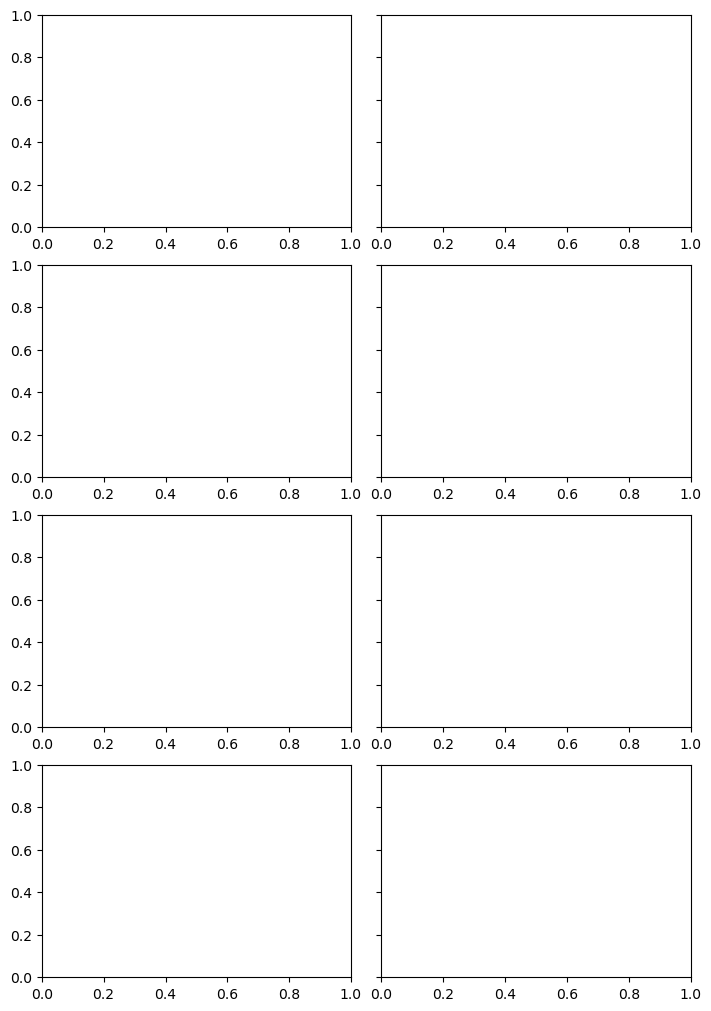

In [47]:
# Make this into a visual
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m']
sum_vars = ['liq_prep_off_glacier_m', 'liq_prep_on_glacier_m']

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(7, 10), sharey=True, constrained_layout=True)

color_pr = '#946cbd'
color_m = ('#d9985f', '#d16b6c')

s_keys = rtype_calc_s126.keys()
ct = 0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s126, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e126, r)
    xvals = index2
    ax1.plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
    ax2.plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
    ct += 1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s126, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e126, sum_vars[0], sum_vars[1])
xvals = index2
ax1.plot(xvals, runoff_s['mean'], label=r, color=color_pr)
ax2.plot(xvals, runoff_e['mean'], label=r, color=color_pr)

s_keys = rtype_calc_s370.keys()
ct = 0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s370, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e370, r)
    xvals = index2
    ax3.plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
    ax4.plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
    ct += 1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s370, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e370, sum_vars[0], sum_vars[1])
xvals = index2
ax3.plot(xvals, runoff_s['mean'], label=r, color=color_pr)
ax4.plot(xvals, runoff_e['mean'], label=r, color=color_pr)

s_keys = rtype_calc_s585.keys()
ct = 0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s585, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e585, r)
    xvals = index2
    ax5.plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
    ax6.plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
    ct += 1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s585, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e585, sum_vars[0], sum_vars[1])
xvals = index2
ax5.plot(xvals, runoff_s['mean'], label=r, color=color_pr)
ax6.plot(xvals, runoff_e['mean'], label=r, color=color_pr)

ax8.plot(xvals, runoff_e['mean'], label=r, color=color_pr)

ax1.set(ylabel='Runoff [Mt]', title='2020-2030') # this title and the next one are overwritten by my addition
ax2.set(title='2090-2100')
ax3.set(ylabel='Runoff [Mt]')
ax5.set(ylabel='Runoff [Mt]')
ax7.set(ylabel='Runoff [Mt]', xlabel='Month')
ax8.set(xlabel='Month')

# THIS WORKS
for ax in (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8):
    ax.set(xticks=season_roll['month_2d'].values,
           xticklabels=season_roll2['month_2d'].values,  # here, we want calendar year values
           )

ax1.text(0.03, 0.9, 'ssp 2.6', transform=ax1.transAxes)
ax2.text(0.03, 0.9, 'ssp 2.6', transform=ax2.transAxes)
ax3.text(0.03, 0.9, 'ssp 4.5', transform=ax3.transAxes)
ax4.text(0.03, 0.9, 'ssp 4.5', transform=ax4.transAxes)
ax5.text(0.03, 0.9, 'ssp 6.0', transform=ax5.transAxes)
ax6.text(0.03, 0.9, 'ssp 6.0', transform=ax6.transAxes)
ax7.text(0.03, 0.9, 'ssp 8.5', transform=ax7.transAxes)
ax8.text(0.03, 0.9, 'ssp 8.5', transform=ax8.transAxes)

plt.suptitle('Decadal seasonal runoff averages by runoff component', fontweight='bold', fontsize=14)

plt.show()

In [ ]:
# Calculating mean runoff values for each SSP
rtype_calc_s126 = {}
rtype_calc_e126 = {}
rtype_calc_s370 = {}
rtype_calc_e370 = {}
rtype_calc_s585 = {}
rtype_calc_e585 = {}

In [ ]:
# Set up the dictionaries with values to use in the summing function
s_keys_dict = {}
s_keys_dict['ssp126'] = rtype_calc_s126.keys()
s_keys_dict['ssp370'] = rtype_calc_s370.keys()
s_keys_dict['ssp585'] = rtype_calc_s585.keys()

rtype_calc_dict_s = {}
rtype_calc_dict_s['ssp126'] = rtype_calc_s126
rtype_calc_dict_s['ssp370'] = rtype_calc_s370
rtype_calc_dict_s['ssp585'] = rtype_calc_s585

rtype_calc_dict_e = {}
rtype_calc_dict_e['ssp126'] = rtype_calc_e126
rtype_calc_dict_e['ssp370'] = rtype_calc_e370
rtype_calc_dict_e['ssp585'] = rtype_calc_e585

In [ ]:
# Make a function that calculates a given runoff value, which I can visualize later
def rtype_calc_monthly_2vars(keys, dictionary, runoff1, runoff2):
    dataframe = pd.DataFrame()
    for k in keys:
        rtype_gcm = dictionary[k]
        rtype1 = rtype_gcm[runoff1]
        rtype2 = rtype_gcm[runoff2]
        rsum = rtype1 + rtype2
        rtype_sum = pd.DataFrame(rsum)
        dataframe[k] = rtype_sum
    dataframe['mean'] = dataframe.transpose().mean()
    return dataframe

In [ ]:
ssp = ('ssp126', 'ssp370', 'ssp585')

all_ssp_dict_s = {}

for r in ssp:
    melt_on = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_s[r], 'melt_on_glacier_m')
    melt_off = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_s[r], 'melt_off_glacier_m')
    liq = rtype_calc_monthly_2vars(s_keys_dict[r], rtype_calc_dict_s[r], 'liq_prep_off_glacier_m', 'liq_prep_on_glacier_m')
    summed = melt_on + melt_off + liq
    m_on_name = 'm-on-{}'.format(r)
    m_off_name = 'm-off-{}'.format(r)
    liq_name = 'liq-{}'.format(r)
    sum_name = 'sum-{}'.format(r)
    all_ssp_dict_s[m_on_name] = melt_on
    all_ssp_dict_s[m_off_name] = melt_off
    all_ssp_dict_s[liq_name] = liq
    all_ssp_dict_s[sum_name] = summed

all_ssp_dict_e = {}

for r in ssp:
    melt_on = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_e[r], 'melt_on_glacier_m')
    melt_off = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_e[r], 'melt_off_glacier_m')
    liq = rtype_calc_monthly_2vars(s_keys_dict[r], rtype_calc_dict_e[r], 'liq_prep_off_glacier_m', 'liq_prep_on_glacier_m')
    summed = melt_on + melt_off + liq
    m_on_name = 'm-on-{}'.format(r)
    m_off_name = 'm-off-{}'.format(r)
    liq_name = 'liq-{}'.format(r)
    sum_name = 'sum-{}'.format(r)
    all_ssp_dict_e[m_on_name] = melt_on
    all_ssp_dict_e[m_off_name] = melt_off
    all_ssp_dict_e[liq_name] = liq
    all_ssp_dict_e[sum_name] = summed

In [ ]:
# Graph of relative importance of runoff for each part of the seasonal cycle (decade 1 and last)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(9, 11), sharey=True, constrained_layout = True);

color_pr = '#946cbd'
color_m = ('#d9985f', '#d16b6c')

xvals = index2

# ssp 2.6
ssp_key = 'ssp126'
ax1.stackplot(xvals, all_ssp_dict_s['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_s['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_s['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax2.stackplot(xvals, all_ssp_dict_e['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_e['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_e['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

# ssp4.5
ssp_key = 'ssp370'
ax3.stackplot(xvals, all_ssp_dict_s['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_s['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_s['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax4.stackplot(xvals, all_ssp_dict_e['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_e['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_e['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

# ssp6.0
ssp_key = 'ssp585'
ax5.stackplot(xvals, all_ssp_dict_s['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_s['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_s['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax6.stackplot(xvals, all_ssp_dict_e['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_e['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_e['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);


plt.suptitle('Relative seasonal contribution of runoff components', fontweight = 'bold', fontsize = 14);

ax1.set(ylabel='% Total runoff', title='2020-2030')
ax2.set(title='2090-2100')
ax3.set(ylabel='% Total runoff')
ax5.set(ylabel='% Total runoff')
ax7.set(ylabel='% Total runoff', xlabel = 'Month')
ax8.set(xlabel = 'Month')
# THIS WORKS
for ax in (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values #here, we want calendar year values
          );
# Add ssp labels as titles (from chatgpt)
ax1.set_title('ssp 2.6: 2020-2030', fontsize=10)
ax2.set_title('ssp 2.6: 2090-2100', fontsize=10)
ax3.set_title('ssp 4.5: 2020-2030', fontsize=10)
ax4.set_title('ssp 4.5: 2090-2100', fontsize=10)
ax5.set_title('ssp 6.0: 2020-2030', fontsize=10)
ax6.set_title('ssp 6.0: 2090-2100', fontsize=10)

#plt.savefig('Figures/Seasonal/Decade_av/4x2_relative_importance_newMay4.png', bbox_inches='tight')

## ignore this for now, starting fresh

In [ ]:
# Calculating mean runoff values for each SSP
rtype_calc_s126 = {}
rtype_calc_e126 = {}
rtype_calc_s370 = {}
rtype_calc_e370 = {}
rtype_calc_s585 = {}
rtype_calc_e585 = {}

In [ ]:
# this code is from ChatGPT

import matplotlib.pyplot as plt

# Define the runoff variables and colors
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m']
sum_vars = ['liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
color_pr = '#946cbd'
color_m = ['#d9985f', '#d16b6c']

# Create subplots with shared y-axis
fig, axes = plt.subplots(4, 2, figsize=(8, 10.5), sharey=True)
(ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8) = axes

# Adjust the space between subplots
plt.subplots_adjust(wspace=0.05, hspace=0.2)

# Plotting function to avoid repetition
def plot_runoff(ax, rtype_calc_s, rtype_calc_e, s_keys, rtype_label):
    ct = 0
    for r in runoff_variables:
        runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s, r)
        runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e, r)
        xvals = index2
        ax[0].plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
        ax[1].plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
        ct += 1
    runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s, sum_vars[0], sum_vars[1])
    runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e, sum_vars[0], sum_vars[1])
    ax[0].plot(xvals, runoff_s['mean'], label='Total liquid precipitation', color=color_pr)
    ax[1].plot(xvals, runoff_e['mean'], label='Total liquid precipitation', color=color_pr)
    ax[0].set(ylabel='Runoff [Mt]')
    ax[0].text(0.03, 0.9, rtype_label, transform=ax[0].transAxes)
    ax[1].text(0.03, 0.9, rtype_label, transform=ax[1].transAxes)

# Plot each ssp scenario
plot_runoff([ax1, ax2], rtype_calc_s126, rtype_calc_e126, rtype_calc_s126.keys(), 'ssp 126')
plot_runoff([ax3, ax4], rtype_calc_s370, rtype_calc_e370, rtype_calc_s370.keys(), 'ssp 370')
plot_runoff([ax5, ax6], rtype_calc_s585, rtype_calc_e585, rtype_calc_s585.keys(), 'ssp 585')

# Set titles for the columns
ax1.set(title='2020-2030')
ax2.set(title='2090-2100')

# Set x-axis labels and ticks
for ax in (ax7, ax8):
    ax.set(xlabel='Month')
for ax in (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8):
    ax.set(xticks=season_roll['month_2d'].values, xticklabels=season_roll2['month_2d'].values)

# Add a single legend to the right of the plots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.19, 0.84), borderaxespad=0.)

# Add a ssper title with adjusted vertical position
fig.suptitle('Decadal seasonal runoff averages by runoff component', fontweight='bold', fontsize=14, y=0.94)

plt.show()

In [ ]:
# Set up the dictionaries with values to use in the summing function
s_keys_dict = {}
s_keys_dict['ssp126'] = rtype_calc_s126.keys()
s_keys_dict['ssp370'] = rtype_calc_s370.keys()
s_keys_dict['ssp585'] = rtype_calc_s585.keys()

rtype_calc_dict_s = {}
rtype_calc_dict_s['ssp126'] = rtype_calc_s126
rtype_calc_dict_s['ssp370'] = rtype_calc_s370
rtype_calc_dict_s['ssp585'] = rtype_calc_s585

rtype_calc_dict_e = {}
rtype_calc_dict_e['ssp126'] = rtype_calc_e126
rtype_calc_dict_e['ssp370'] = rtype_calc_e370
rtype_calc_dict_e['ssp585'] = rtype_calc_e585

In [ ]:
# Make a function that calculates a given runoff value, which I can visualize later
def rtype_calc_monthly_2vars(keys, dictionary, runoff1, runoff2):
    dataframe = pd.DataFrame()
    for k in keys:
        rtype_gcm = dictionary[k]
        rtype1 = rtype_gcm[runoff1]
        rtype2 = rtype_gcm[runoff2]
        rsum = rtype1 + rtype2
        rtype_sum = pd.DataFrame(rsum)
        dataframe[k] = rtype_sum
    dataframe['mean'] = dataframe.transpose().mean()
    return dataframe

In [ ]:
ssp = ('ssp126', 'ssp370', 'ssp585')

all_ssp_dict_s = {}

for r in ssp:
    melt_on = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_s[r], 'melt_on_glacier_m')
    melt_off = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_s[r], 'melt_off_glacier_m')
    liq = rtype_calc_monthly_2vars(s_keys_dict[r], rtype_calc_dict_s[r], 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m')
    summed = melt_on + melt_off + liq
    m_on_name = 'm-on-{}'.format(r)
    m_off_name = 'm-off-{}'.format(r)
    liq_name = 'liq-{}'.format(r)
    sum_name = 'sum-{}'.format(r)
    all_ssp_dict_s[m_on_name] = melt_on
    all_ssp_dict_s[m_off_name] = melt_off
    all_ssp_dict_s[liq_name] = liq
    all_ssp_dict_s[sum_name] = summed

all_ssp_dict_e = {}

for r in ssp:
    melt_on = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_e[r], 'melt_on_glacier_m')
    melt_off = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_e[r], 'melt_off_glacier_m')
    liq = rtype_calc_monthly_2vars(s_keys_dict[r], rtype_calc_dict_e[r], 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m')
    summed = melt_on + melt_off + liq
    m_on_name = 'm-on-{}'.format(r)
    m_off_name = 'm-off-{}'.format(r)
    liq_name = 'liq-{}'.format(r)
    sum_name = 'sum-{}'.format(r)
    all_ssp_dict_e[m_on_name] = melt_on
    all_ssp_dict_e[m_off_name] = melt_off
    all_ssp_dict_e[liq_name] = liq
    all_ssp_dict_e[sum_name] = summed

In [ ]:
# Graph of relative importance of runoff for each part of the seasonal cycle (decade 1 and last)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(9, 11), sharey=True, constrained_layout = True);

color_pr = '#946cbd'
color_m = ('#d9985f', '#d16b6c')

xvals = index2

# ssp 2.6
ssp_key = 'ssp126'
ax1.stackplot(xvals, all_ssp_dict_s['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_s['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_s['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax2.stackplot(xvals, all_ssp_dict_e['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_e['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_e['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

# ssp4.5
ssp_key = 'ssp370'
ax3.stackplot(xvals, all_ssp_dict_s['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_s['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_s['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax4.stackplot(xvals, all_ssp_dict_e['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_e['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_e['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

# ssp6.0
ssp_key = 'ssp585'
ax5.stackplot(xvals, all_ssp_dict_s['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_s['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_s['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax6.stackplot(xvals, all_ssp_dict_e['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_e['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_e['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

#ax1.legend(bbox_to_anchor=(0.44, 0.95));

plt.ssptitle('Relative seasonal contribution of runoff components', fontweight = 'bold', fontsize = 14);

ax1.set(ylabel='% Total runoff', title='2020-2030')
ax2.set(title='2090-2100')
ax3.set(ylabel='% Total runoff')
ax5.set(ylabel='% Total runoff')
ax7.set(ylabel='% Total runoff', xlabel = 'Month')
ax8.set(xlabel = 'Month')
# THIS WORKS
for ax in (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values #here, we want calendar year values
          );
# Add ssp labels as titles (from chatgpt)
ax1.set_title('ssp 2.6: 2020-2030', fontsize=10)
ax2.set_title('ssp 2.6: 2090-2100', fontsize=10)
ax3.set_title('ssp 4.5: 2020-2030', fontsize=10)
ax4.set_title('ssp 4.5: 2090-2100', fontsize=10)
ax5.set_title('ssp 6.0: 2020-2030', fontsize=10)
ax6.set_title('ssp 6.0: 2090-2100', fontsize=10)
ax7.set_title('ssp 8.5: 2020-2030', fontsize=10)
ax8.set_title('ssp 8.5: 2090-2100', fontsize=10)


In [ ]:
# from chatgpt to make the following code run; maybe this should go earlier
# Function to calculate seasonal values for a given SSP dictionary
def calculate_seasonal_for_ssp(ssp_dict):
    season_unroll = {}
    for k in ssp_dict.keys():
        calculation = calc_seasonal(ssp_dict[k])
        z = '{}-calc'.format(k)
        season_unroll[z] = calculation
    return season_unroll

# Dictionary of SSP dictionaries
ssp_dicts = {
    'ssp126': ssp_monthly_dict126,
    'ssp245': ssp_monthly_dict245,
    'ssp370': ssp_monthly_dict370
}

# Dictionary to store results for all SSPs
all_season_unrolls = {}

# Calculate seasonal values for each SSP
for ssp_name, ssp_dict in ssp_dicts.items():
    all_season_unrolls[ssp_name] = calculate_seasonal_for_ssp(ssp_dict)

# Now, all_season_unrolls will contain the results for all three SSPs
season_unroll126 = all_season_unrolls['ssp126']
season_unroll245 = all_season_unrolls['ssp245']
season_unroll370 = all_season_unrolls['ssp370']

# Example: Print results for verification
print(season_unroll126)
print(season_unroll245)
print(season_unroll370)


In [ ]:
time = [0, 20, 40, 80]

from matplotlib import cm
#color_ts = ('#c2f2f2', '#81cfdb', '#4c858f', '#23393d')
#New colors 5/4/23
color_ts = ('#cce0f4', '#7bafe3', '#2b7ed1', '#2365a8')

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16)) = plt.subplots(4, 4, figsize=(10, 9), sharex=True, sharey=True, constrained_layout = True)

# Make first row of ssps for time t=0
t = time[0]
for k in season_unroll126.keys():
    color_idx = 0
    season_t = season_sliced(key_dict['ssp126'], dict_roll126, t)
    xvals = np.asarray(season_t.index)+1
    ax1.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.8)
ax1.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll370.keys():
    color_idx = 0
    season_t = season_sliced(key_dict['ssp370'], dict_roll370, t)
    xvals = np.asarray(season_t.index)+1
    ax2.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.8)
ax2.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll585.keys():
    color_idx = 0
    season_t = season_sliced(key_dict['ssp585'], dict_roll585, t)
    xvals = np.asarray(season_t.index)+1
    ax3.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.8)
ax3.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

# Make second row of ssps for time t=20
t = time[1]
for k in season_unroll26.keys():
    color_idx = 1
    season_t = season_sliced(key_dict['ssp126'], dict_roll126, t)
    xvals = np.asarray(season_t.index)+1
    ax5.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax5.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll370.keys():
    color_idx = 1
    season_t = season_sliced(key_dict['ssp370'], dict_roll370, t)
    xvals = np.asarray(season_t.index)+1
    ax6.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax6.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll585.keys():
    color_idx = 1
    season_t = season_sliced(key_dict['ssp585'], dict_roll585, t)
    xvals = np.asarray(season_t.index)+1
    ax7.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax7.plot(xvals, season_t['mean'], color='k', linewidth=1.5)


# Make third row of ssps for time t=40
t = time[2]
for k in season_unroll126.keys():
    color_idx = 2
    season_t = season_sliced(key_dict['ssp126'], dict_roll216, t)
    xvals = np.asarray(season_t.index)+1
    ax9.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax9.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll370.keys():
    color_idx = 2
    season_t = season_sliced(key_dict['ssp370'], dict_roll370, t)
    xvals = np.asarray(season_t.index)+1
    ax10.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax10.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll60.keys():
    color_idx = 2
    season_t = season_sliced(key_dict['ssp585'], dict_roll585, t)
    xvals = np.asarray(season_t.index)+1
    ax11.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax11.plot(xvals, season_t['mean'], color='k', linewidth=1.5)


# Make fourth row of ssps for time t=80
t = time[3]
for k in season_unroll126.keys():
    color_idx = 3
    season_t = season_sliced(key_dict['ssp126'], dict_roll126, t)
    xvals = np.asarray(season_t.index)+1
    ax13.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax13.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll370.keys():
    color_idx = 3
    season_t = season_sliced(key_dict['ssp370'], dict_roll370, t)
    xvals = np.asarray(season_t.index)+1
    ax14.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax14.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll585.keys():
    color_idx = 3
    season_t = season_sliced(key_dict['ssp585'], dict_roll585, t)
    xvals = np.asarray(season_t.index)+1
    ax15.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax15.plot(xvals, season_t['mean'], color='k', linewidth=1.5)
    
ax1.set(xticks = season_roll['month_2d'].values,
       xticklabels = season_roll2['month_2d'].values,
       title = 'ssp 126');
ax2.set(xticks = season_roll['month_2d'].values,
       xticklabels = season_roll2['month_2d'].values,
       title = 'ssp 370');
ax3.set(xticks = season_roll['month_2d'].values,
       xticklabels = season_roll2['month_2d'].values,
       title = 'ssp 585');

ax1.set(ylabel = 'Runoff [Mt]')
ax5.set(ylabel = 'Runoff [Mt]')
ax9.set(ylabel = 'Runoff [Mt]')
ax13.set(ylabel = 'Runoff [Mt]',
        xlabel = 'Month')
ax14.set(xlabel = 'Month')
ax15.set(xlabel = 'Month')
ax16.set(xlabel = 'Month')

ax13.tick_params(axis='x', which='major', labelsize=8)
ax14.tick_params(axis='x', which='major', labelsize=8)
ax15.tick_params(axis='x', which='major', labelsize=8)
ax16.tick_params(axis='x', which='major', labelsize=8)

plt.suptitle('Multi-GCM seasonal runoff for four selected years', fontweight = 'bold', fontsize = 14);

In [ ]:
# Plotting total annual runoff
def plot_total_annual_runoff(total_annual_runoff_dict, ssps):
    plt.figure(figsize=(14, 7))
    
    for ssp in ssps:
        ssp_data = [runoff.sel(time=slice(None, '2101')) for scenario, runoff in total_annual_runoff_dict.items() if ssp in scenario]
        if ssp_data:
            combined_runoff = xr.concat(ssp_data, dim='gcm').mean(dim='gcm')
            combined_runoff.plot(label=ssp)

    plt.title('Total Annual Runoff for Different ssp Scenarios')
    plt.xlabel('Year')
    plt.ylabel('Runoff (km³)')
    plt.legend()
    plt.show()

plot_total_annual_runoff(total_annual_runoff_dict, ssp_list)

In [ ]:
# This plots values for both GCMs rather than mean. Bad visual, but useful to see how to do it.

def plot_total_annual_runoff(total_annual_runoff_dict, ssps, plot_individual_gcms=False):
    plt.figure(figsize=(14, 7))
    
    for ssp in ssps:
        if plot_individual_gcms:
            for scenario, runoff in total_annual_runoff_dict.items():
                if ssp in scenario:
                    runoff.sel(time=slice(None, '2101')).plot(label=f'{scenario}')
        else:
            ssp_data = [runoff.sel(time=slice(None, '2101')) for scenario, runoff in total_annual_runoff_dict.items() if ssp in scenario]
            if ssp_data:
                combined_runoff = xr.concat(ssp_data, dim='gcm').mean(dim='gcm')
                combined_runoff.plot(label=ssp)

    plt.title('Total Annual Runoff for Different ssp Scenarios')
    plt.xlabel('Year')
    plt.ylabel('Runoff (km³)')
    plt.legend()
    plt.show()

plot_total_annual_runoff(total_annual_runoff_dict, ssp_list, plot_individual_gcms=True)